<a href="https://colab.research.google.com/github/annkvth/kompleteNetze/blob/main/03b_international_robustness_with_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install traffic

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import networkx as nx
from functools import partialmethod
from google.colab import drive
import os
import glob
from traffic.data import airports
import altair as alt
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox


define lists of airports with more than 50k passengers


In [3]:
# Deutschland
icaolistD=["EDDB", "EDVE", "EDDW", "EDLW", "EDDC", "EDDL", "EDDE", "EDDF", "EDFH", "EDNY", "EDDH", "EDDV", "EDSB", "EDVK", "EDDK", "EDDP", "EDHL", "EDJA", "EDDM", "EDDG", "EDLV", "EDDN", "EDLP", "ETNL", "EDDR", "EDDS", "EDXW"]
markerD='o-'
colorD='red'

# Italien
icaolistI=["LIRF", "LIMC", "LIME", "LIRN", "LIPZ", "LICC", "LIPE", "LIML", "LICJ", "LIBD", "LIRP", "LIEE", "LIMF", "LIRA", "LIPX", "LIEO", "LIBR", "LIRQ", "LIPH", "LICA", "LIEA", "LICT", "LIMJ", "LIPQ", "LIBP", "LIRZ", "LIPY", "LICD", "LICB", "LICR", "LIPR", "LIBC", "LIPK", "LIMP", "LIMZ", "LICG"]
markerI='v-'
colorI='firebrick'

# Spanien - die, die nicht mit LE anfangen, sind abseits des Festlands, vor allem Canaren
icaolistS=["LEZL", "LEZG", "LEXJ", "LEVX", "LEVT", "LEVD", "LEVC", "LEST", "LESO", "LERS", "LEPP", "LEPA", "LEMI", "LEMH", "LEMG", "LEMD", "LELN", "LEJR", "LEIB", "LEGR", "LEGE", "LECO", "LEBZ", "LEBL", "LEBB", "LEAS", "LEAM", "LEAL", "GEML", "GCXO", "GCTS", "GCRR", "GCLP", "GCLA", "GCHI", "GCGM", "GCFV"]
markerS='d-'
colorS='peru'

# Frankreich - alles was nicht LF ist ist Übersee
icaolistF=["LFBD", "LFBE", "LFBH", "LFBL", "LFBO", "LFBP", "LFBT", "LFBZ", "LFGJ", "LFJL", "LFKB", "LFKC", "LFKF", "LFKJ", "LFLB", "LFLC", "LFLL", "LFLS", "LFMK", "LFML", "LFMN", "LFMP", "LFMT", "LFMU", "LFOB", "LFOT", "LFPB", "LFPG", "LFPO", "LFQQ", "LFRB", "LFRK", "LFRN", "LFRS", "LFSB", "LFST", "LFTH", "LFTW", "NTAA", "NTTB", "NTTG", "NTTH", "NTTR", "NWWL", "NWWM", "NWWW", "SOCA", "TFFF", "TFFG", "TFFJ", "TFRR", "FMCZ", "FMEE"]
markerF='^-'
colorF='darkorange'


pick which country to analyse in this runtime

In [4]:
option = 1 # 1=Deutschland, 2=Italien, 3=Spanien, 4=Frankreich
if option == 1:
  icaolist = icaolistD
  countryname = "deutschland"
  markerToUse = markerD
  colorToUse = colorD
elif option == 2:
  icaolist = icaolistI
  countryname = "italien"
  markerToUse = markerI
  colorToUse = colorI
elif option == 3:
  icaolist = icaolistS
  countryname = "spanien"
  markerToUse = markerS
  colorToUse = colorS
elif option  == 4:
  icaolist = icaolistF
  countryname = "frankreich"
  markerToUse = markerF
  colorToUse = colorF


where to read and save the data (and making sure that the directory exist)

In [5]:
drive.mount('/content/drive')
folder_path = "/content/drive/My Drive/2024KomplexeNetze/Daten"
if not os.path.exists(folder_path):
    print(f'No such folder: {folder_path}')
csv_files = sorted(glob.glob(os.path.join(folder_path, f"*{countryname}.csv")))
print(csv_files)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/My Drive/2024KomplexeNetze/Daten/2018-01-01_2018-04-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2018-04-01_2018-07-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2018-07-01_2018-10-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2018-10-01_2019-01-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-01-01_2019-04-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-04-01_2019-07-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-07-01_2019-10-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-10-01_2020-01-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2020-01-01_2020-04-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2020-04-01_2020-07-0

In [6]:
# always useful
pd.DataFrame.query = partialmethod(pd.DataFrame.query, engine="python")

let's define some functions we will use later. First:

Function to calculate international efficiency using the graph

In [7]:
def analyze_graph_IE(graph):
    total_reciprocal_shortest_paths = {}

    for icao in icaolist:
        if icao in graph: # Check if icao is in the graph
            total_reciprocal_shortest_path_for_icao = 0
            shortest_paths = nx.single_source_shortest_path_length(graph, source=icao)
            for arrival_airport in international_list:
                if arrival_airport in shortest_paths:
                    total_reciprocal_shortest_path_for_icao += 1/shortest_paths[arrival_airport]
                    total_reciprocal_shortest_paths[icao] = total_reciprocal_shortest_path_for_icao

    sum_of_reciprocals = sum(total_reciprocal_shortest_paths.values())
    IE = sum_of_reciprocals * 1/(len(international_list) * len(icaolist))
    #print(f"The international effiency of the given graph is: {IE}")

    return IE


Function to processes the input graph by creating subgraphs, reducing edge weights, and removing edges until no more destination nodes remain in the inputgraph that are not part of icaolist.
  

In [8]:
def process_graph(inputgraph, icaolist):
  subgraph_list = []

  while True:
      # Check if there are any destination nodes left that are not in icaolist
      destination_nodes_outside_icaolist = False
      for u, v, data in inputgraph.edges(data=True):
        if v not in icaolist:
            destination_nodes_outside_icaolist = True
            break

      if not destination_nodes_outside_icaolist or inputgraph.number_of_edges() == 0:
        break

      subgraph = nx.DiGraph()
      for u, v, data in inputgraph.edges(data=True):
          subgraph.add_edge(u, v, weight=1)

      subgraph_list.append(subgraph)

      edges_to_remove = []
      for u, v, data in inputgraph.edges(data=True):
          new_weight = data.get('weight', 1) - 1
          if new_weight <= 0:
              edges_to_remove.append((u, v))
          else:
              inputgraph[u][v]['weight'] = new_weight

      inputgraph.remove_edges_from(edges_to_remove)

  #print("Subgraph history length:", len(subgraph_list))
  return subgraph_list


And finally:
Function for the Weighted International Efficiency

*To clarify: what is the "number of connections between i and j" - per day, month, year, average?

Using per month I get WIE=3, using the average per week I get WIE=1.14 for 2024-01-01_2024-04-01.csv

In the Zhou 2021 paper they have 1.5 for Germany, but don't specify which "number of connections" they use.
... or maybe it doesn't matter, as long as we keep the same timeframe as base for comparisons. *


In [9]:
def analyze_graph_WIE(graph):
    decomposed_subgraphs = process_graph(graph, icaolist)

    total_ie = 0
    for subnet in decomposed_subgraphs:
      ie = analyze_graph_IE(subnet)
      total_ie += ie
    return total_ie


Another function that is needied as step 1 for international robustness:
remove the airport with the highest number of international connections


In [10]:
def remove_highest_degree_node(graph, icaolist):
    # check if domestic airports remain: create a subgraph containing only nodes from the icaolist
    subgraph = graph.subgraph(icaolist)
    if not subgraph.nodes():
      return graph

    # Find the node with the highest outgoing degree in the graph
    degreelist=list(graph.out_degree(weight="weight"))
    # Filter degreelist to keep only nodes present in icaolist
    degreelist = [(node, degree) for node, degree in degreelist if node in icaolist]
    # [('EDDF', 15044), ('EDDM', 12554), ...]
    max_grade = max(degreelist, key=lambda x: x[1])[1]
    max_grade_nodes_list = [node[0] for node in graph.out_degree(weight='weight') if node[1] == max_grade]
    highest_degree_node = max_grade_nodes_list[0]
    #print(degreelist[:3])

    # Create a copy of the graph to avoid modifying the original
    modified_graph = graph.copy()

    # Remove the node and its connected edges from the modified graph
    removed_name = f"{highest_degree_node}"
    modified_graph.remove_node(highest_degree_node)


    return modified_graph, removed_name


--------------------------------------------

## Main Part

--------------------------------------------

now loop over the csv files, processing them one by one:
 - create directed graph
 - call my functions to determine WIE for each of them


/content/drive/My Drive/2024KomplexeNetze/Daten/2018-01-01_2018-04-01_deutschland.csv


airports @ourairports.com:   0%|          | 0/3584 [00:00<?, ?it/s]

Number of nodes (airports): 577
Number of edges (flight routes): 3526, sum of weights (flights) 47461.0
Found 793 international airports to check against
WIE_post has become zero.
International robustness for 2018-01: 0.6623856995153067


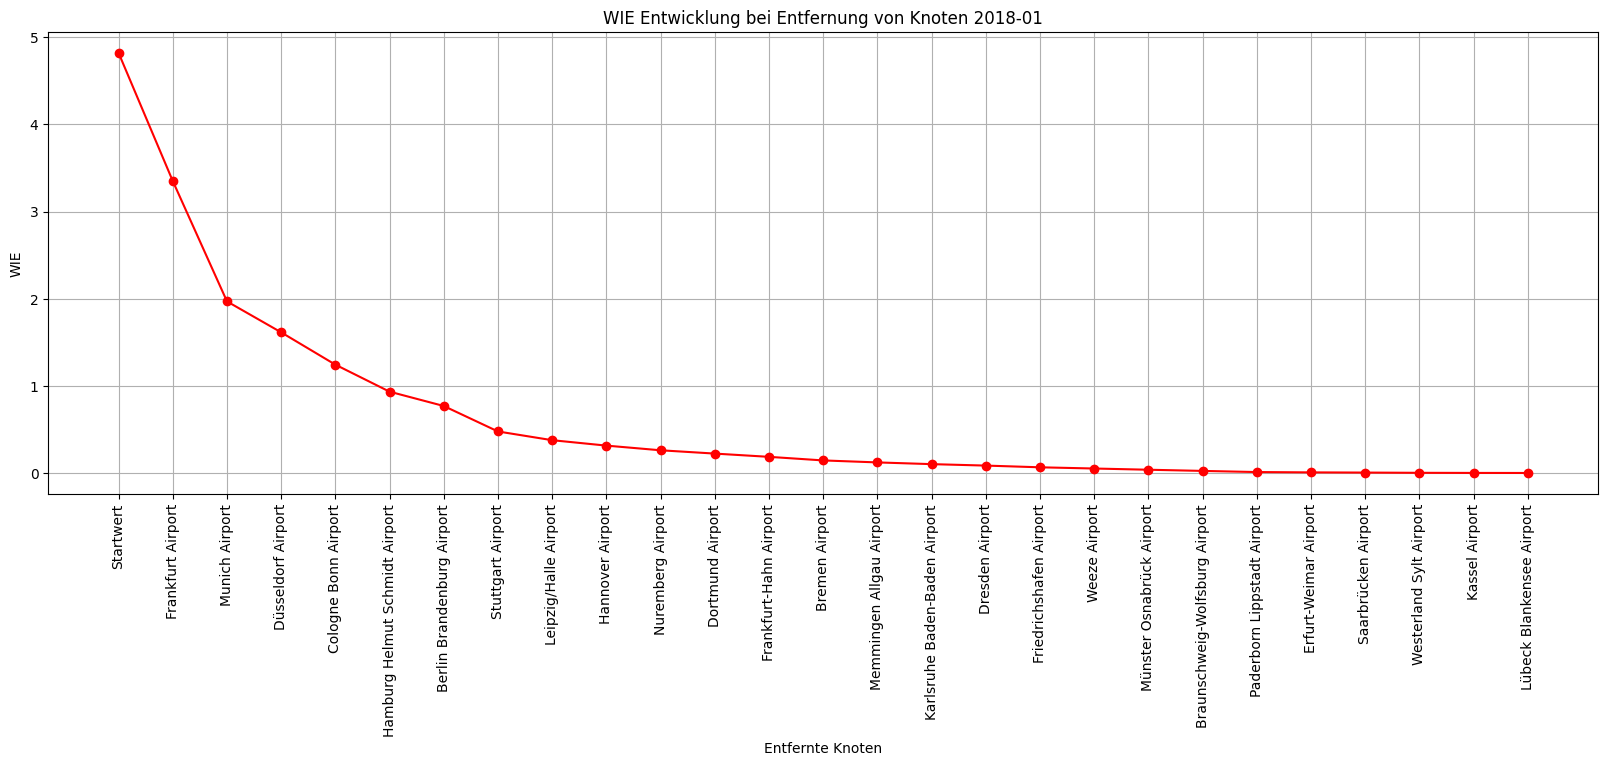

Number of nodes (airports): 589
Number of edges (flight routes): 3578, sum of weights (flights) 47451.0
Found 793 international airports to check against
WIE_post has become zero.
International robustness for 2018-02: 0.6642082368977646


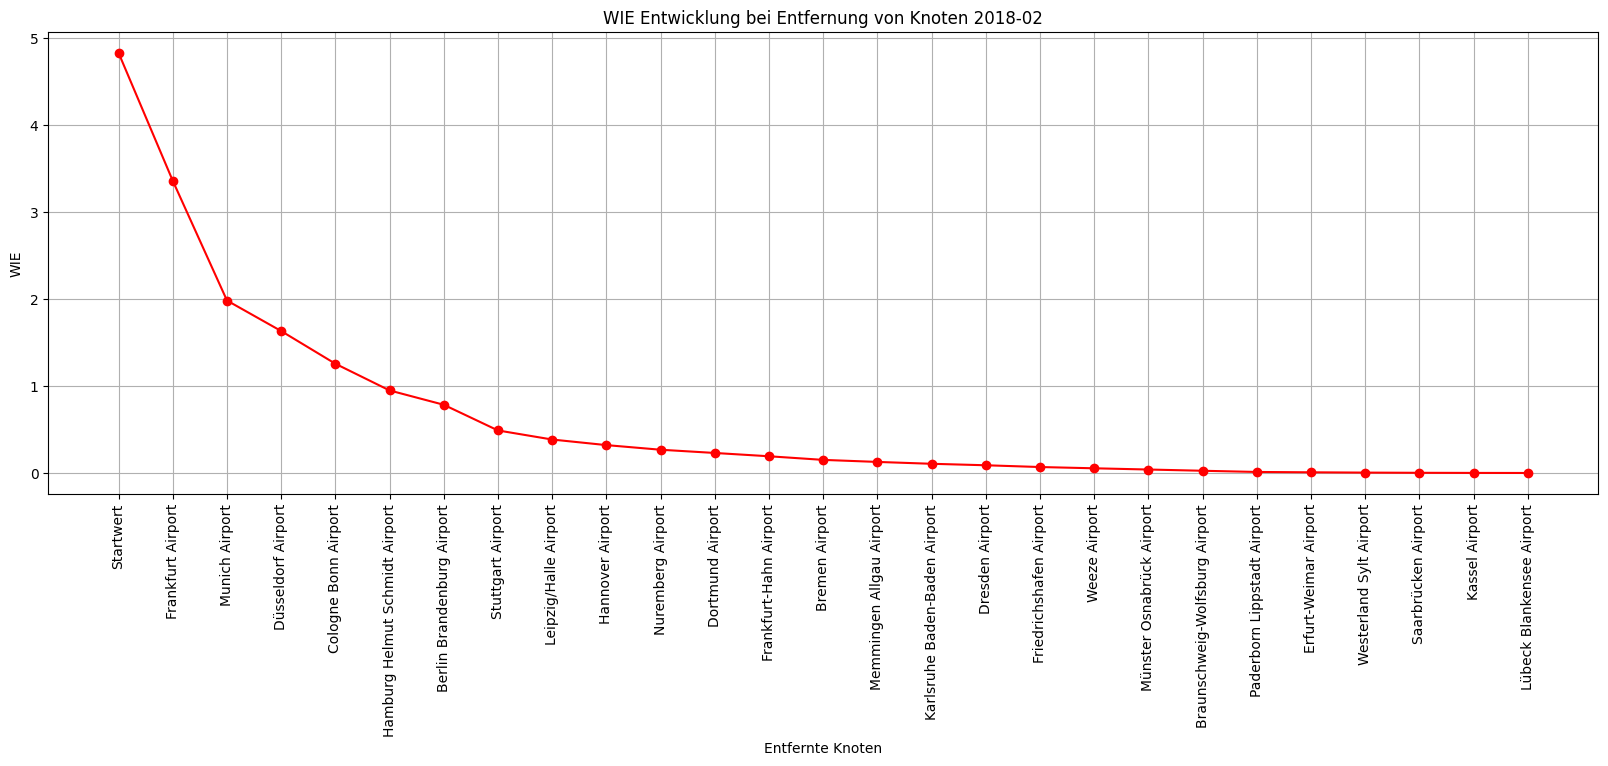

Number of nodes (airports): 618
Number of edges (flight routes): 3669, sum of weights (flights) 47453.0
Found 793 international airports to check against
WIE_post has become zero.
International robustness for 2018-03: 0.6656489726019652


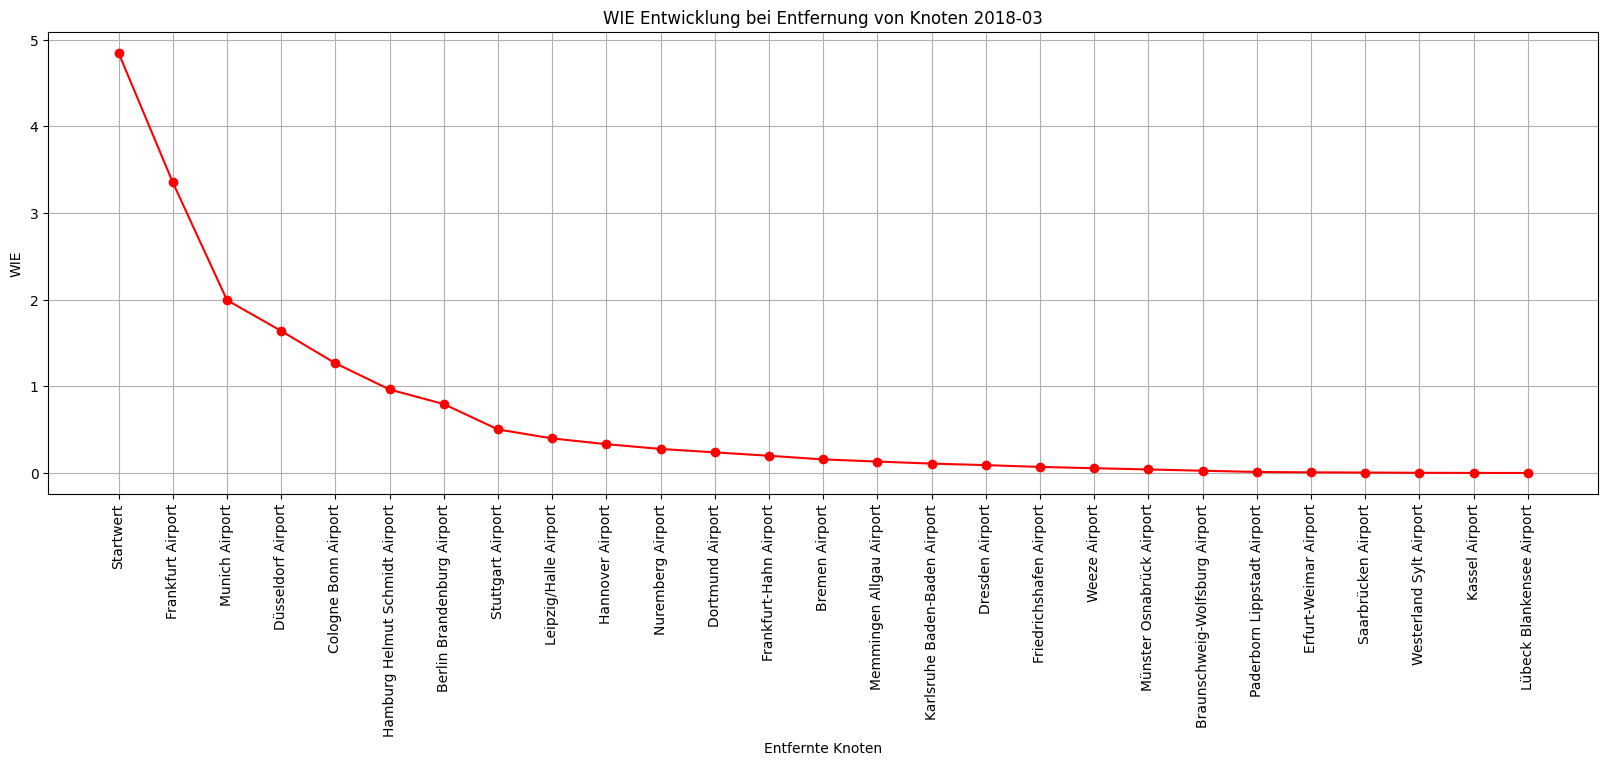

/content/drive/My Drive/2024KomplexeNetze/Daten/2018-04-01_2018-07-01_deutschland.csv
Number of nodes (airports): 702
Number of edges (flight routes): 4406, sum of weights (flights) 49851.0
Found 1287 international airports to check against
WIE_post has become zero.
International robustness for 2018-04: 0.6916006918843739


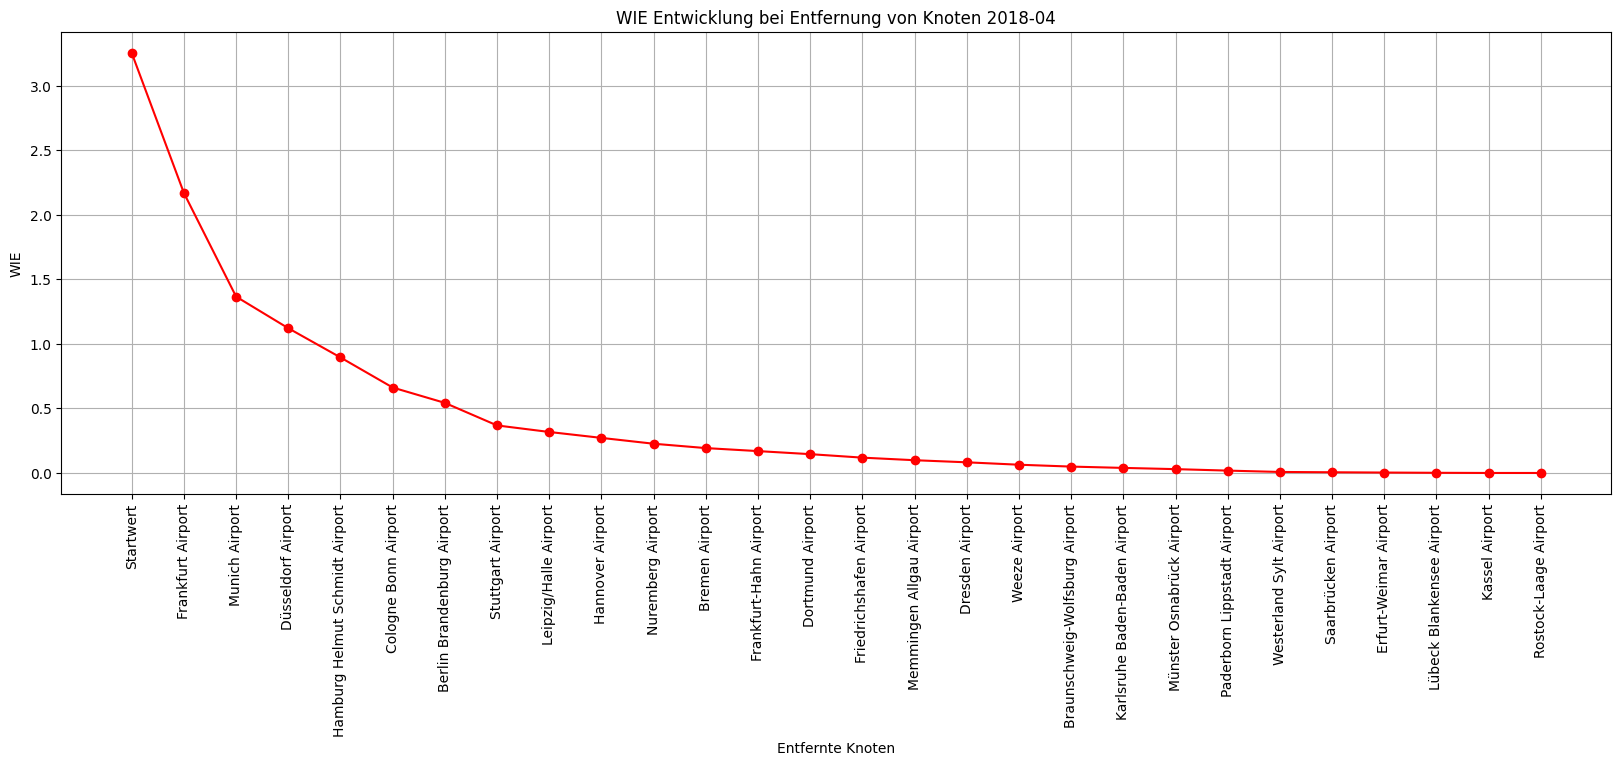

Number of nodes (airports): 877
Number of edges (flight routes): 5132, sum of weights (flights) 54218.0
Found 1287 international airports to check against
WIE_post has become zero.
International robustness for 2018-05: 0.6912560990049542


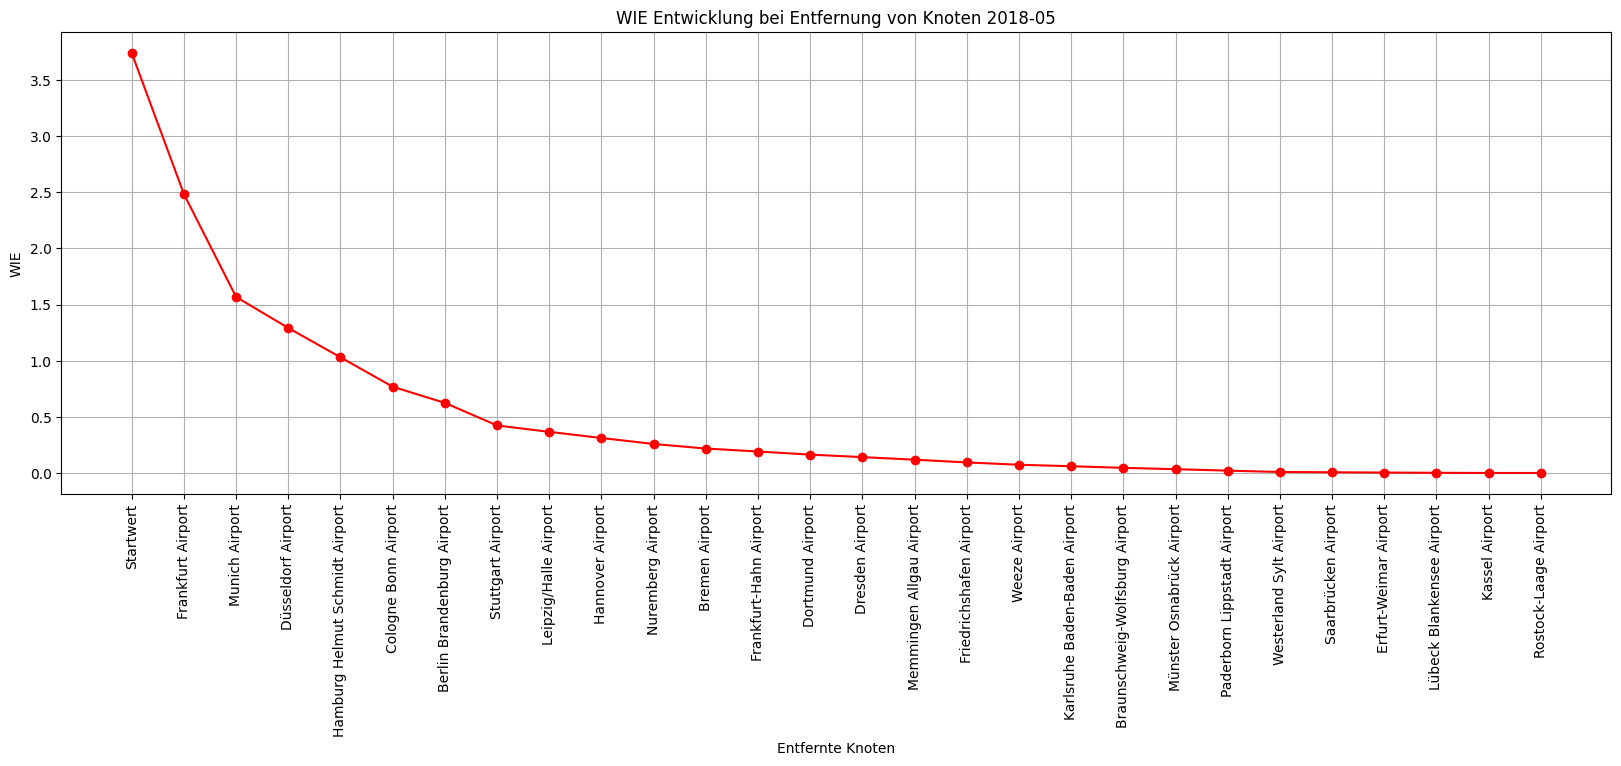

Number of nodes (airports): 994
Number of edges (flight routes): 5176, sum of weights (flights) 54201.0
Found 1287 international airports to check against
WIE_post has become zero.
International robustness for 2018-06: 0.6960620584436124


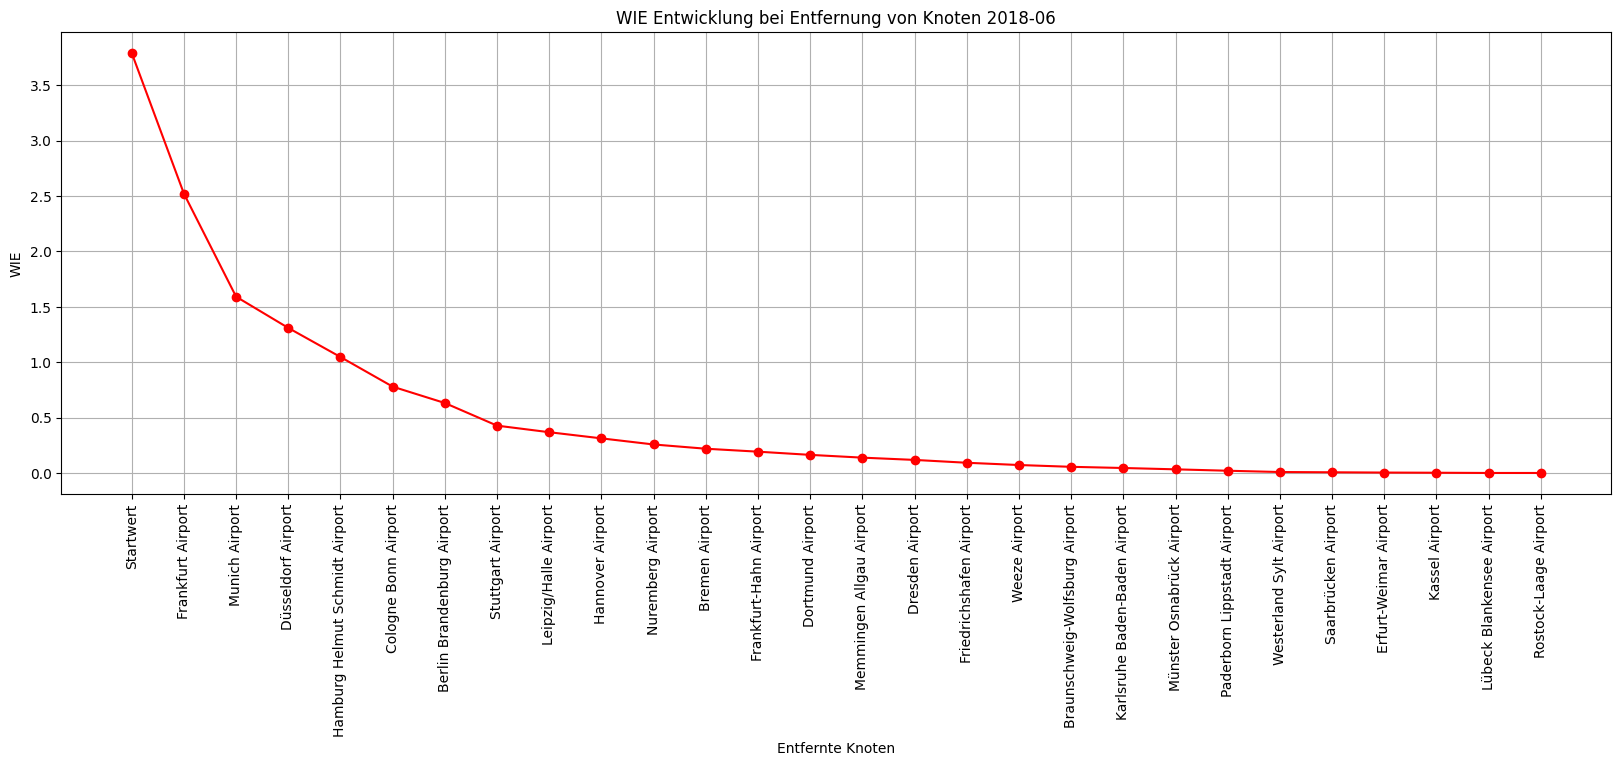

/content/drive/My Drive/2024KomplexeNetze/Daten/2018-07-01_2018-10-01_deutschland.csv
Number of nodes (airports): 988
Number of edges (flight routes): 5243, sum of weights (flights) 51929.0
Found 1379 international airports to check against
WIE_post has become zero.
International robustness for 2018-07: 0.7014738609869136


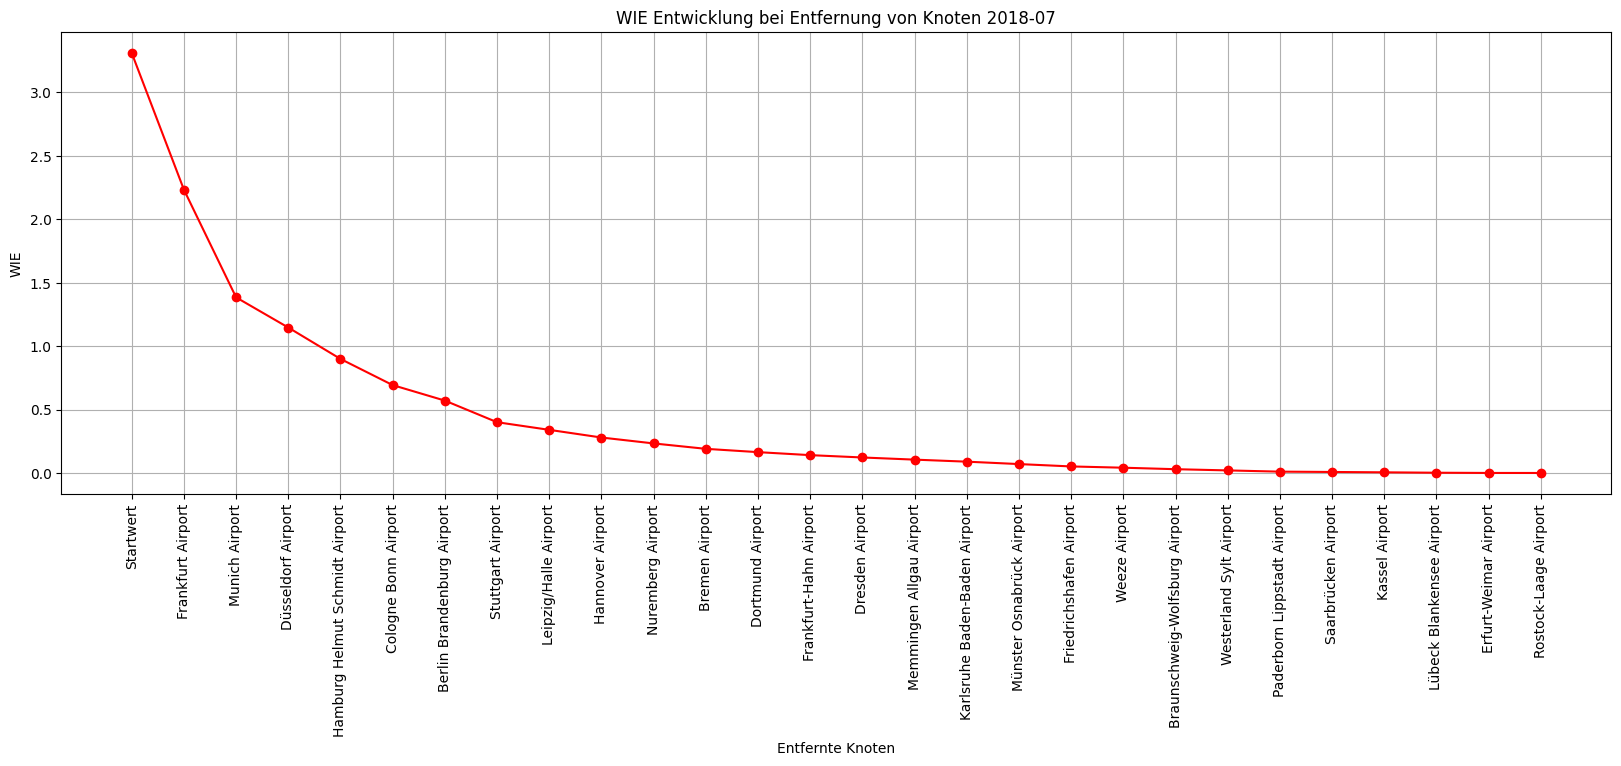

Number of nodes (airports): 991
Number of edges (flight routes): 5293, sum of weights (flights) 52368.0
Found 1379 international airports to check against
WIE_post has become zero.
International robustness for 2018-08: 0.7032278559985703


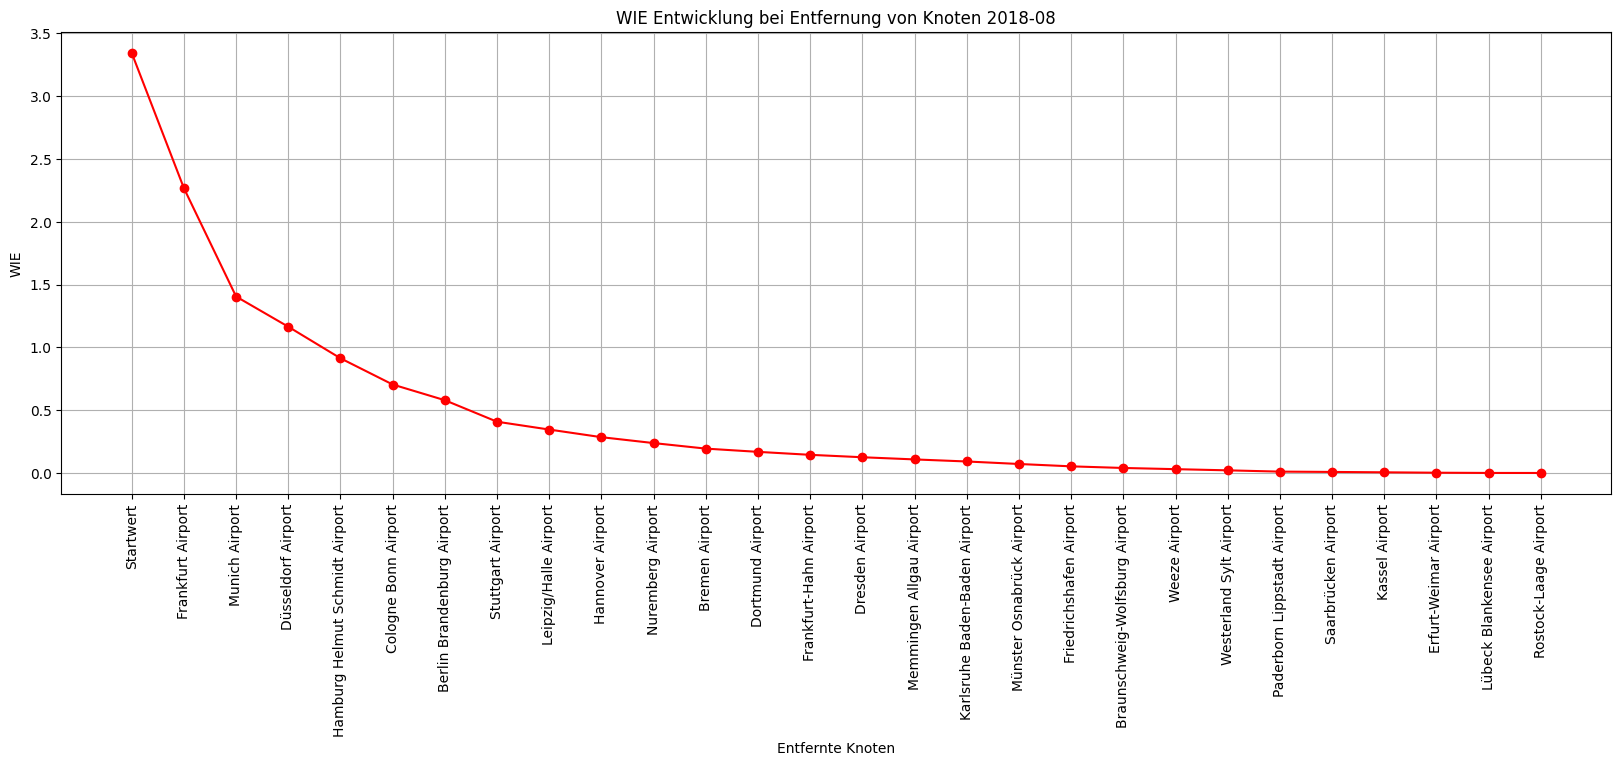

Number of nodes (airports): 962
Number of edges (flight routes): 5183, sum of weights (flights) 51976.0
Found 1379 international airports to check against
WIE_post has become zero.
International robustness for 2018-09: 0.7021714332480383


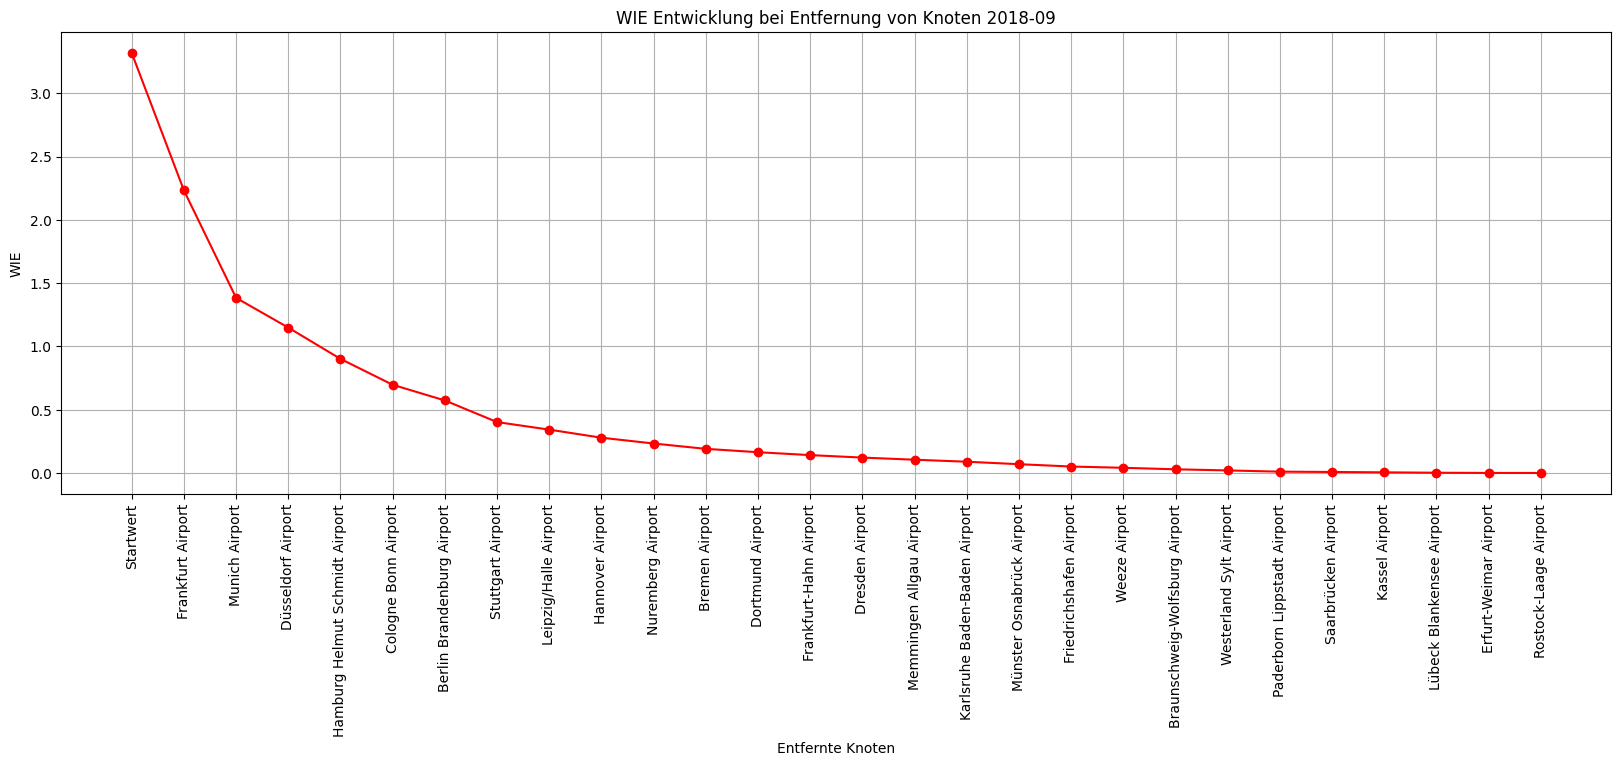

/content/drive/My Drive/2024KomplexeNetze/Daten/2018-10-01_2019-01-01_deutschland.csv
Number of nodes (airports): 952
Number of edges (flight routes): 4913, sum of weights (flights) 49215.0
Found 1238 international airports to check against
WIE_post has become zero.
International robustness for 2018-10: 0.6973651651847698


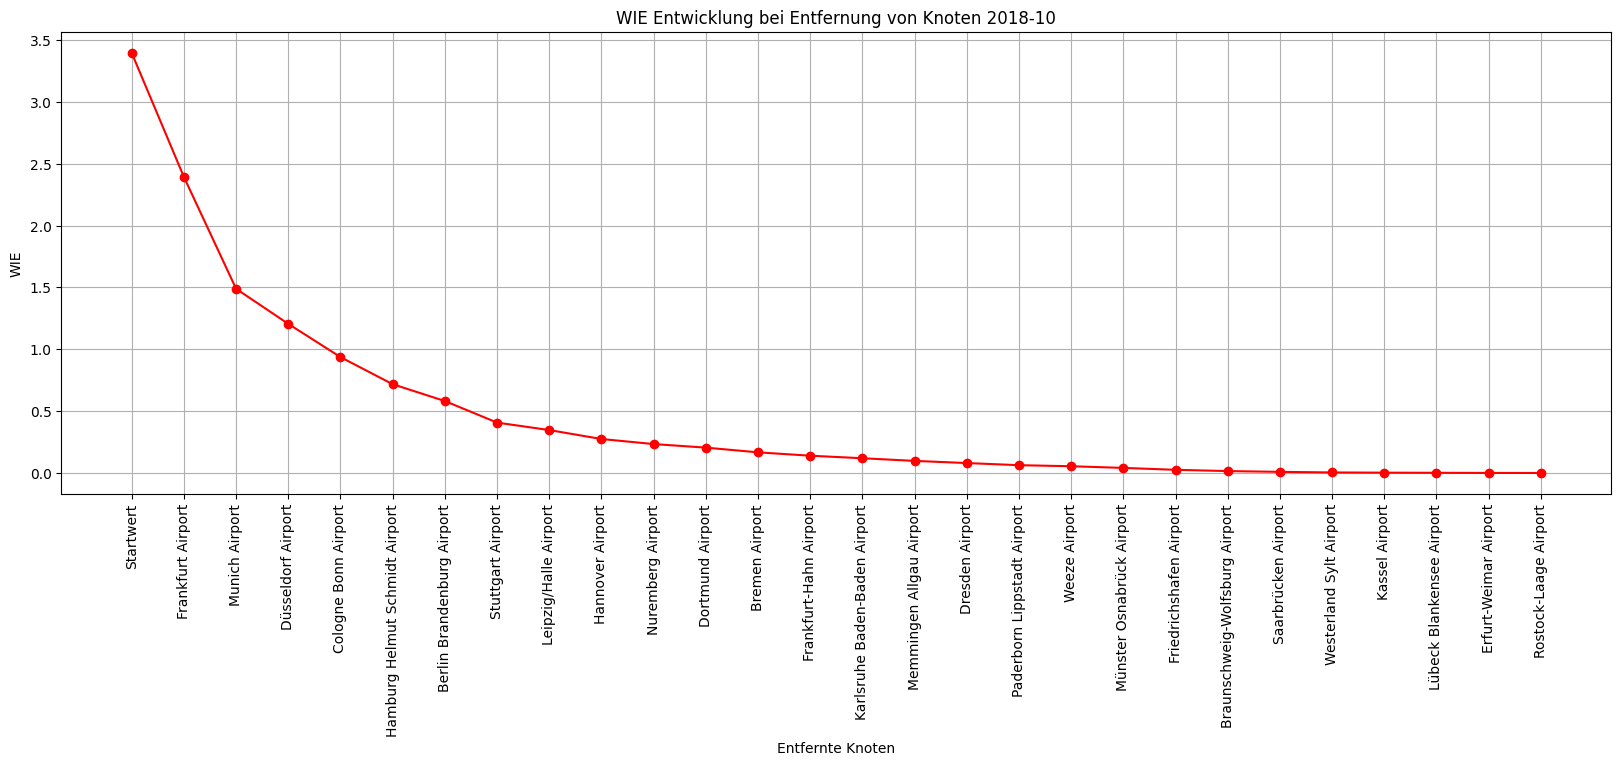

Number of nodes (airports): 807
Number of edges (flight routes): 4621, sum of weights (flights) 48709.0
Found 1238 international airports to check against
WIE_post has become zero.
International robustness for 2018-11: 0.6937261662868794


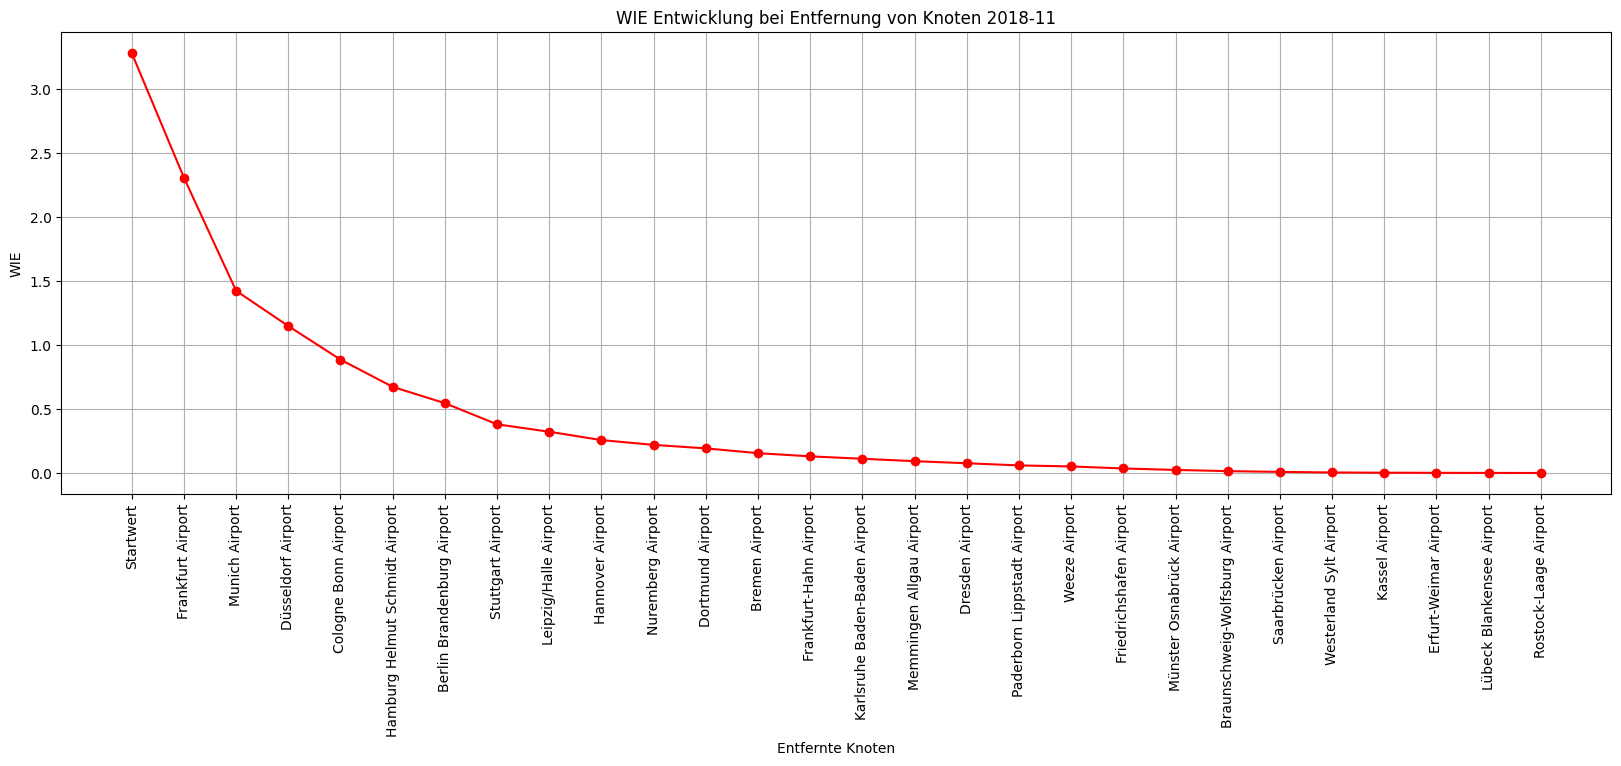

Number of nodes (airports): 770
Number of edges (flight routes): 4539, sum of weights (flights) 48628.0
Found 1238 international airports to check against
WIE_post has become zero.
International robustness for 2018-12: 0.6910900330588399


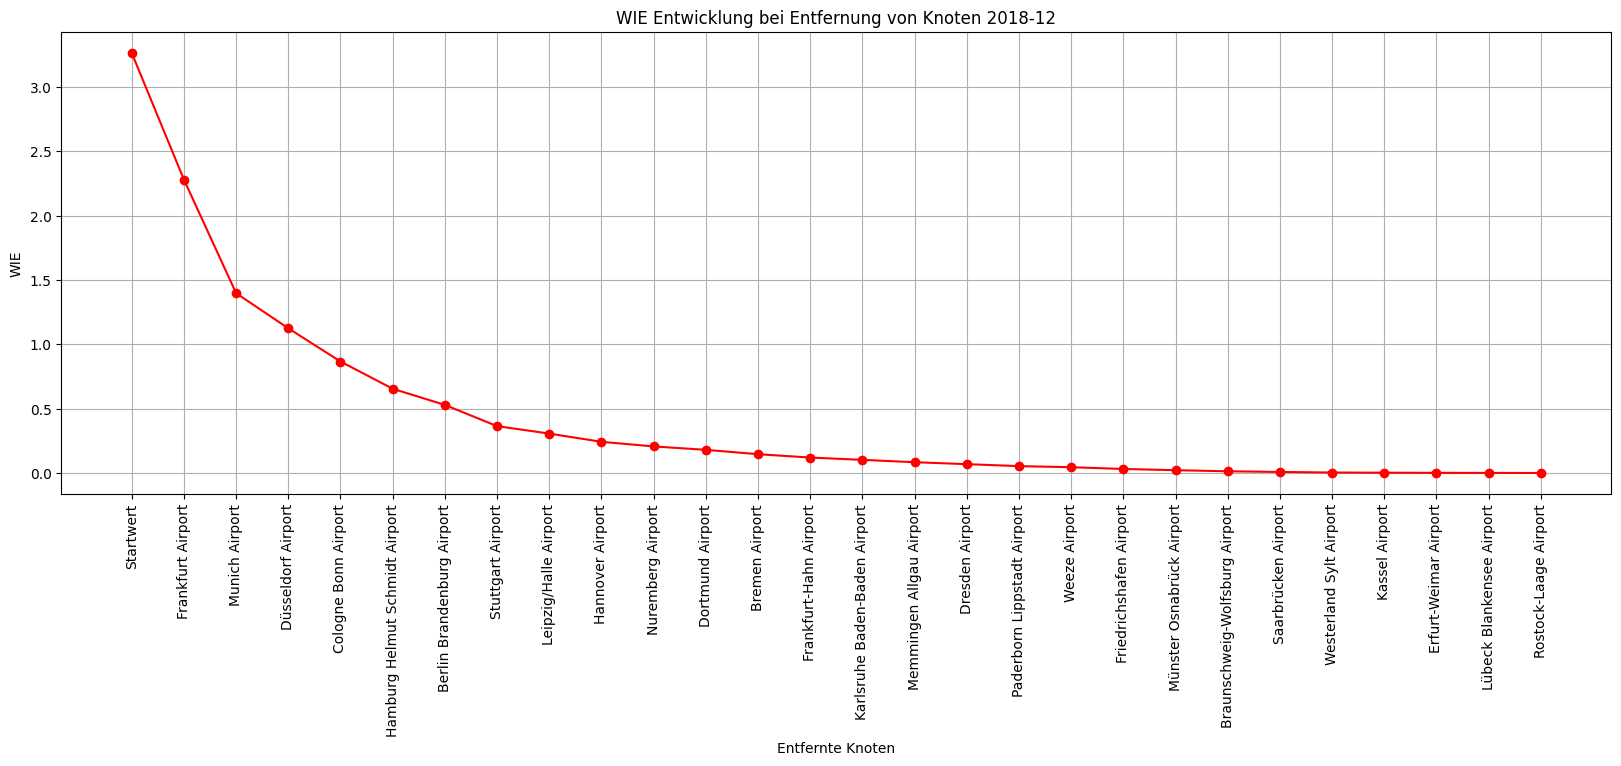

/content/drive/My Drive/2024KomplexeNetze/Daten/2019-01-01_2019-04-01_deutschland.csv
Number of nodes (airports): 809
Number of edges (flight routes): 4367, sum of weights (flights) 54488.0
Found 1214 international airports to check against
WIE_post has become zero.
International robustness for 2019-01: 0.7040690332769098


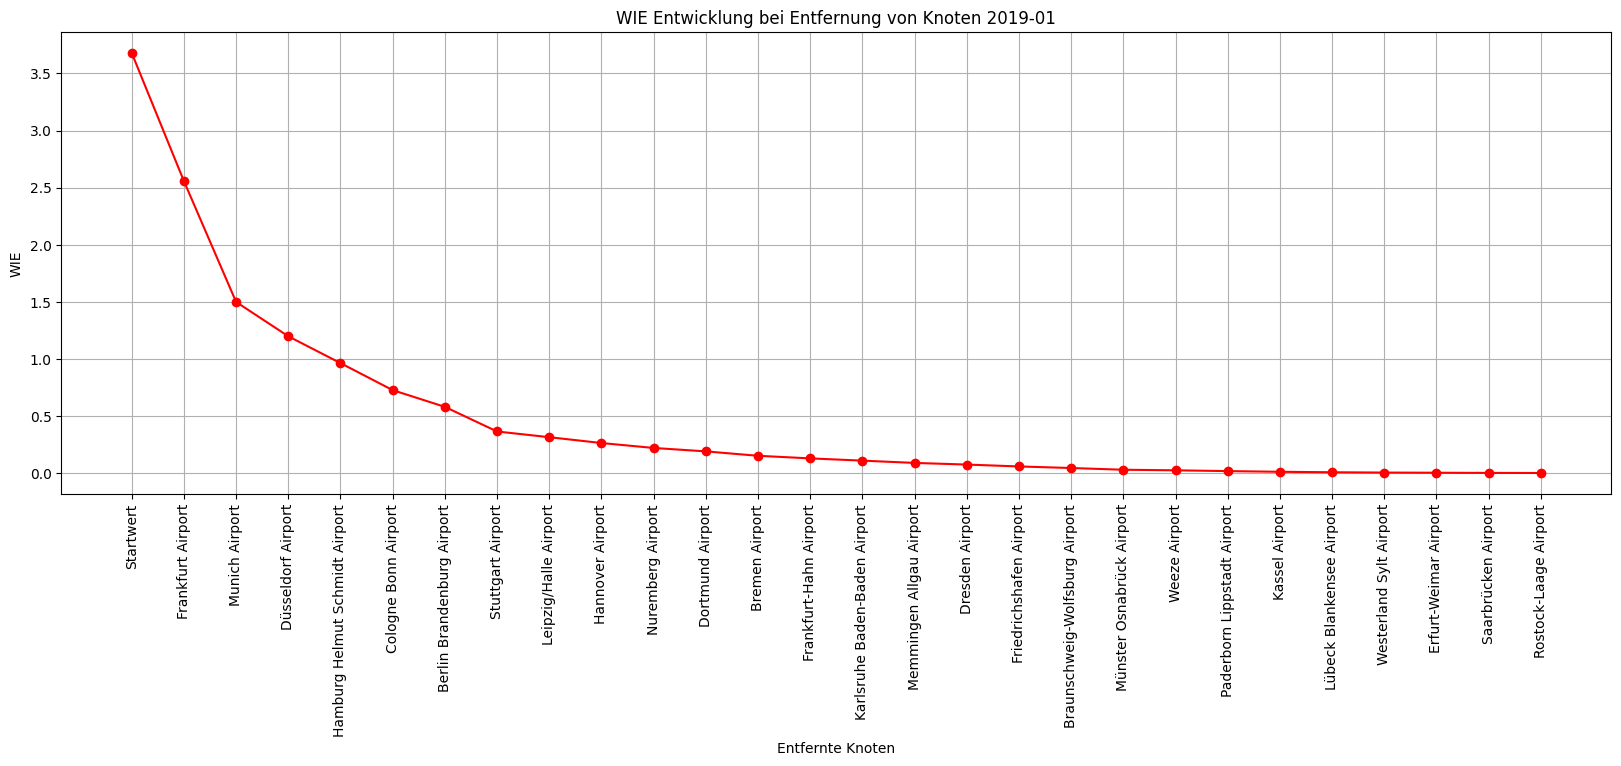

Number of nodes (airports): 850
Number of edges (flight routes): 4444, sum of weights (flights) 54683.0
Found 1214 international airports to check against
WIE_post has become zero.
International robustness for 2019-02: 0.7018098377574965


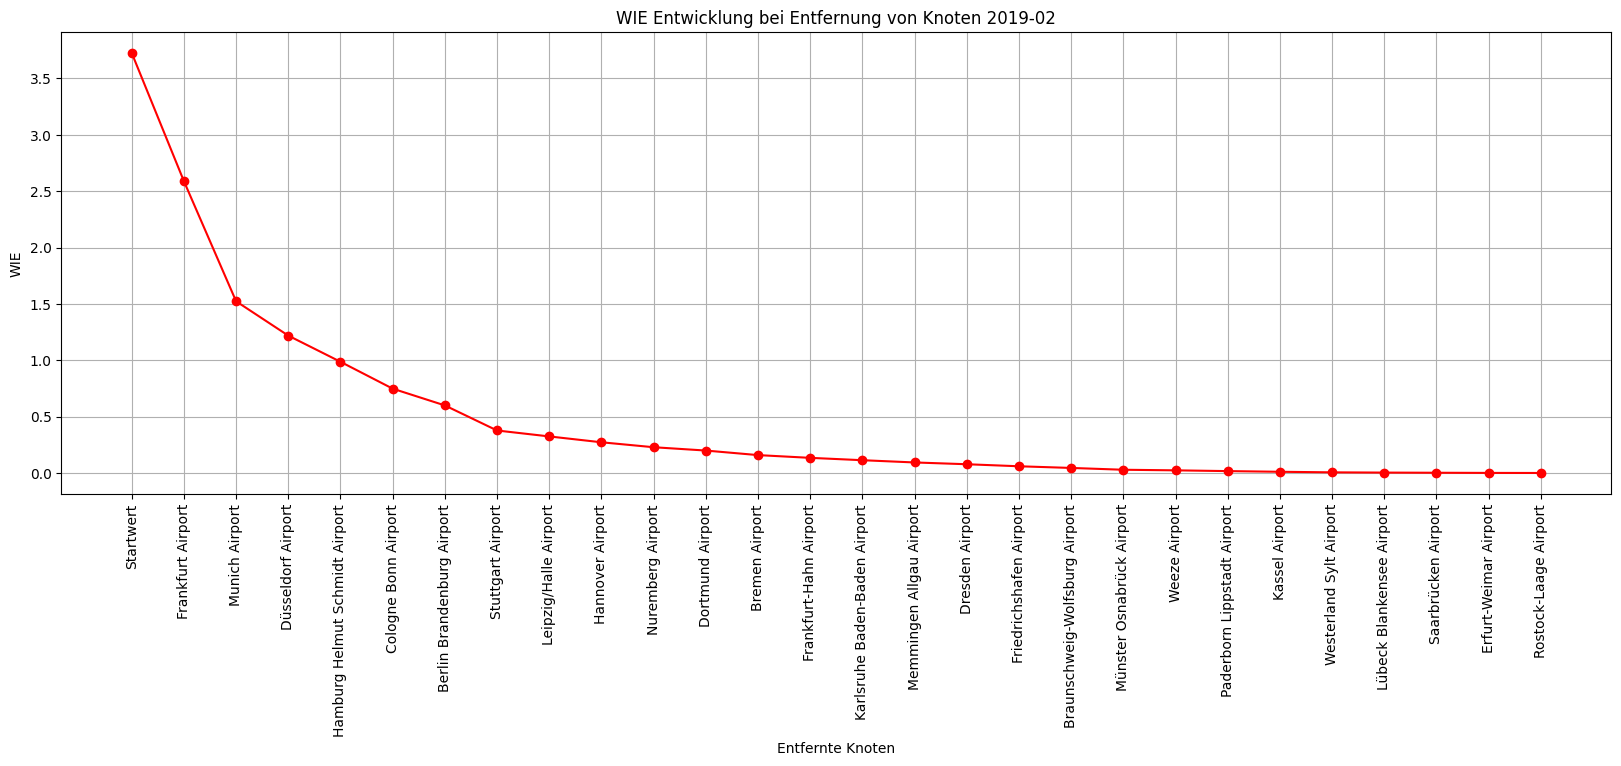

Number of nodes (airports): 810
Number of edges (flight routes): 4377, sum of weights (flights) 54866.0
Found 1214 international airports to check against
WIE_post has become zero.
International robustness for 2019-03: 0.7018844365630251


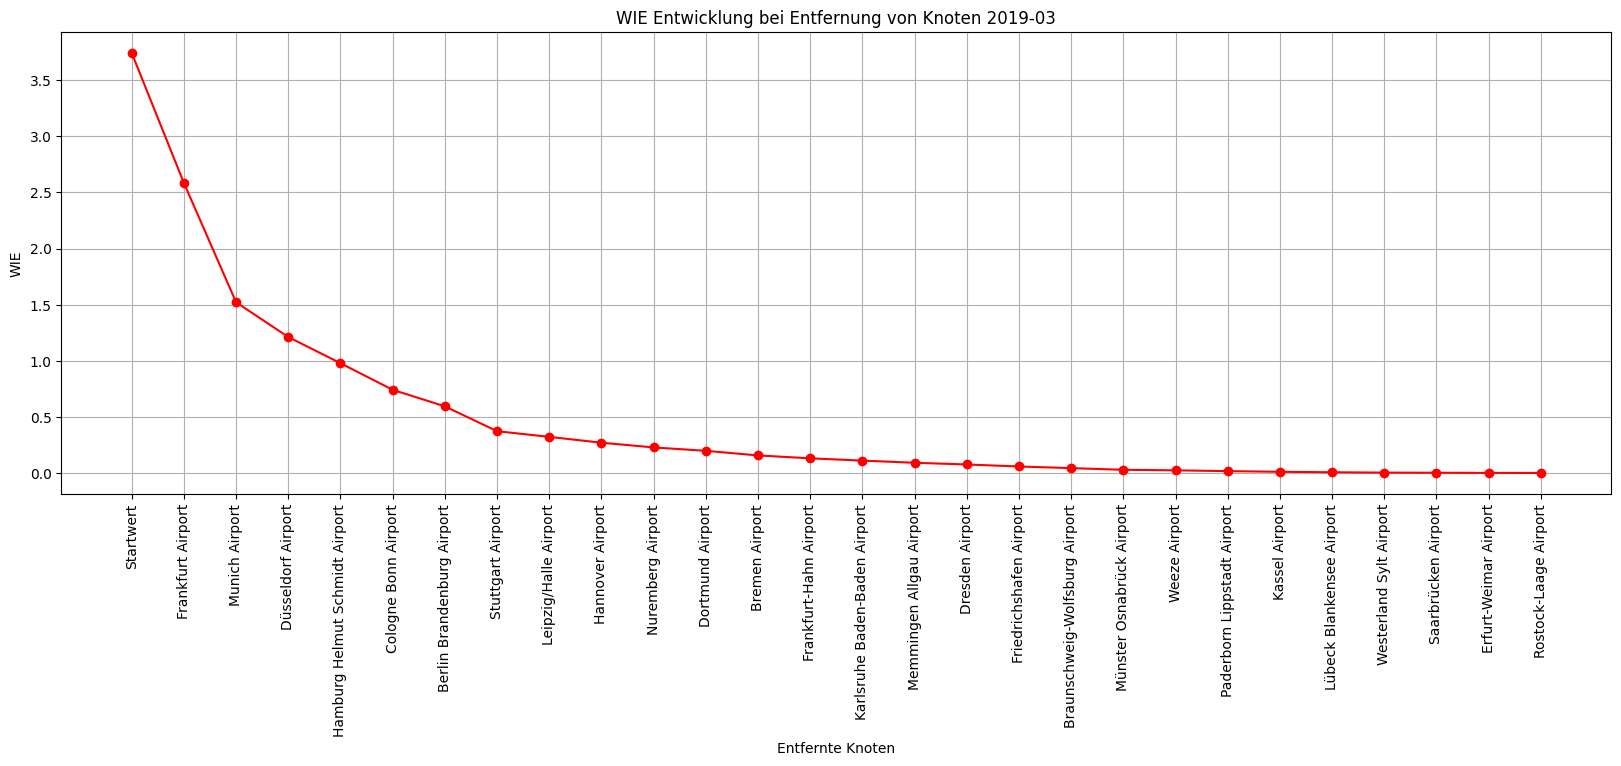

/content/drive/My Drive/2024KomplexeNetze/Daten/2019-04-01_2019-07-01_deutschland.csv
Number of nodes (airports): 924
Number of edges (flight routes): 5375, sum of weights (flights) 59049.0
Found 1386 international airports to check against
WIE_post has become zero.
International robustness for 2019-04: 0.7313068907738924


Number of nodes (airports): 988
Number of edges (flight routes): 5558, sum of weights (flights) 59897.0
Found 1386 international airports to check against
WIE_post has become zero.
International robustness for 2019-05: 0.7320069372093623


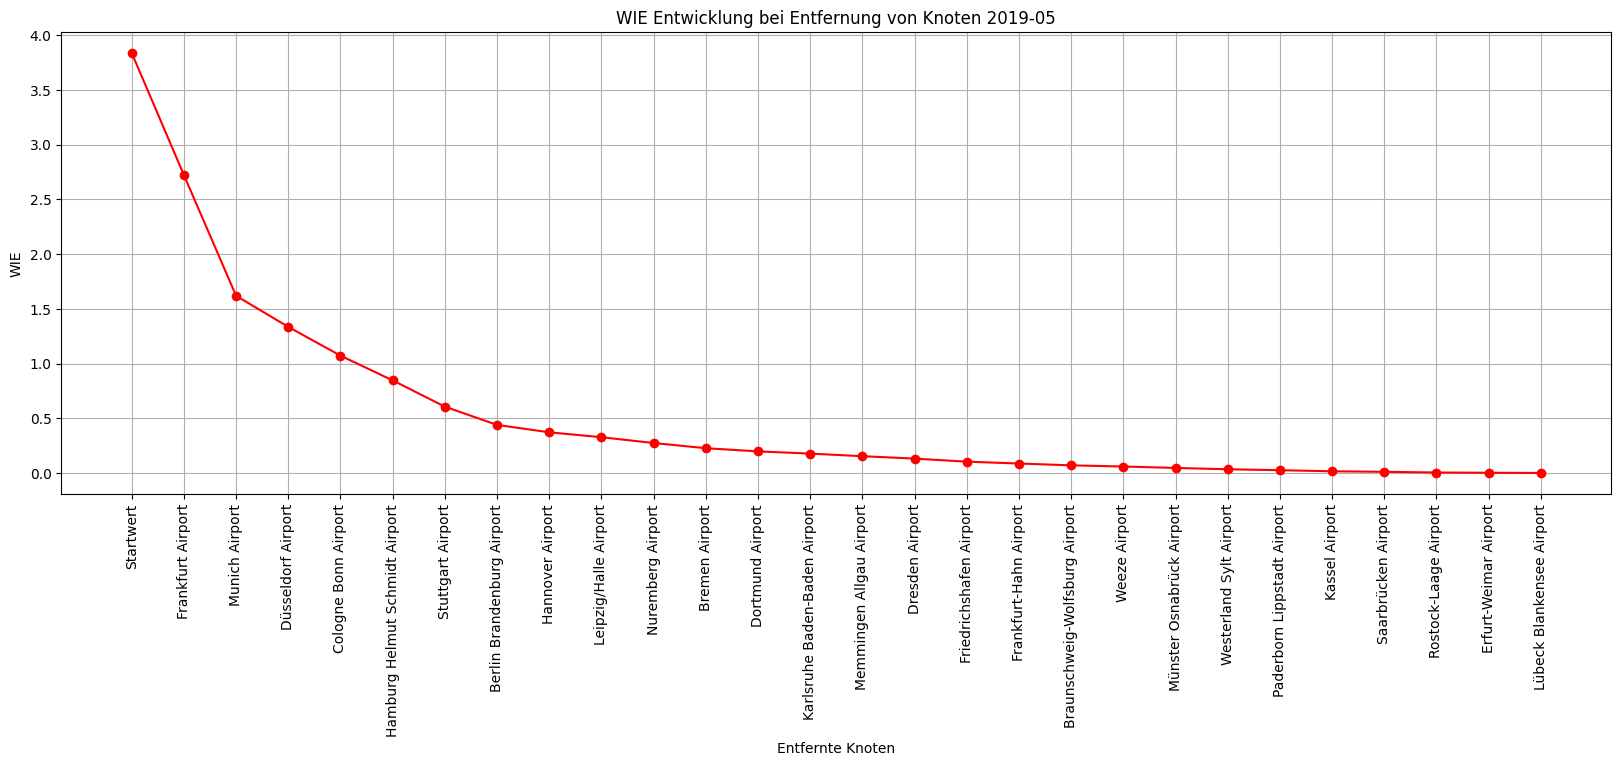

Number of nodes (airports): 1038
Number of edges (flight routes): 5618, sum of weights (flights) 59902.0
Found 1386 international airports to check against
WIE_post has become zero.
International robustness for 2019-06: 0.7333830913702755


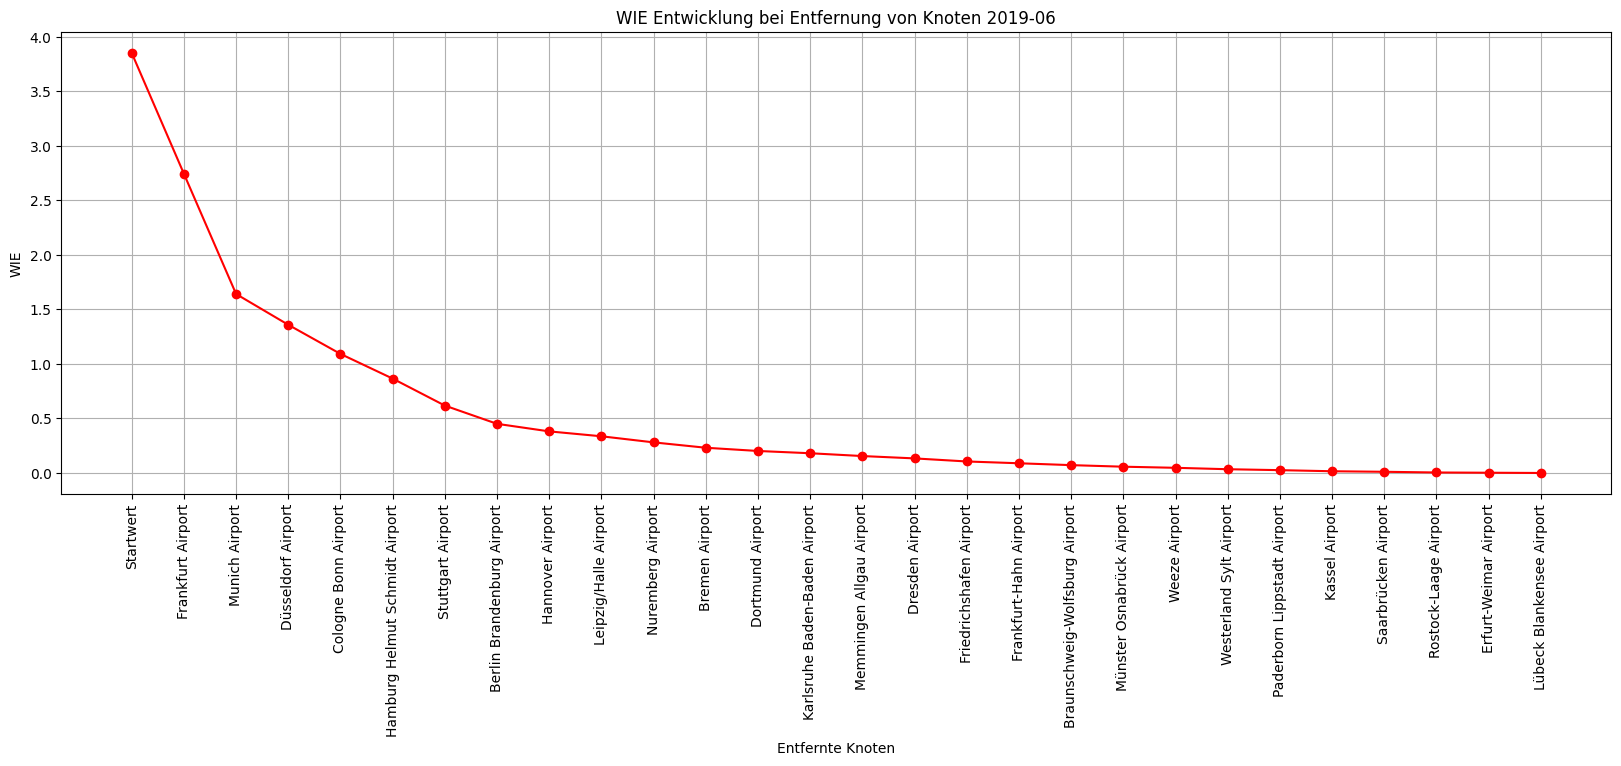

/content/drive/My Drive/2024KomplexeNetze/Daten/2019-07-01_2019-10-01_deutschland.csv
Number of nodes (airports): 1019
Number of edges (flight routes): 5483, sum of weights (flights) 65897.0
Found 1382 international airports to check against
WIE_post has become zero.
International robustness for 2019-07: 0.7138841177818899


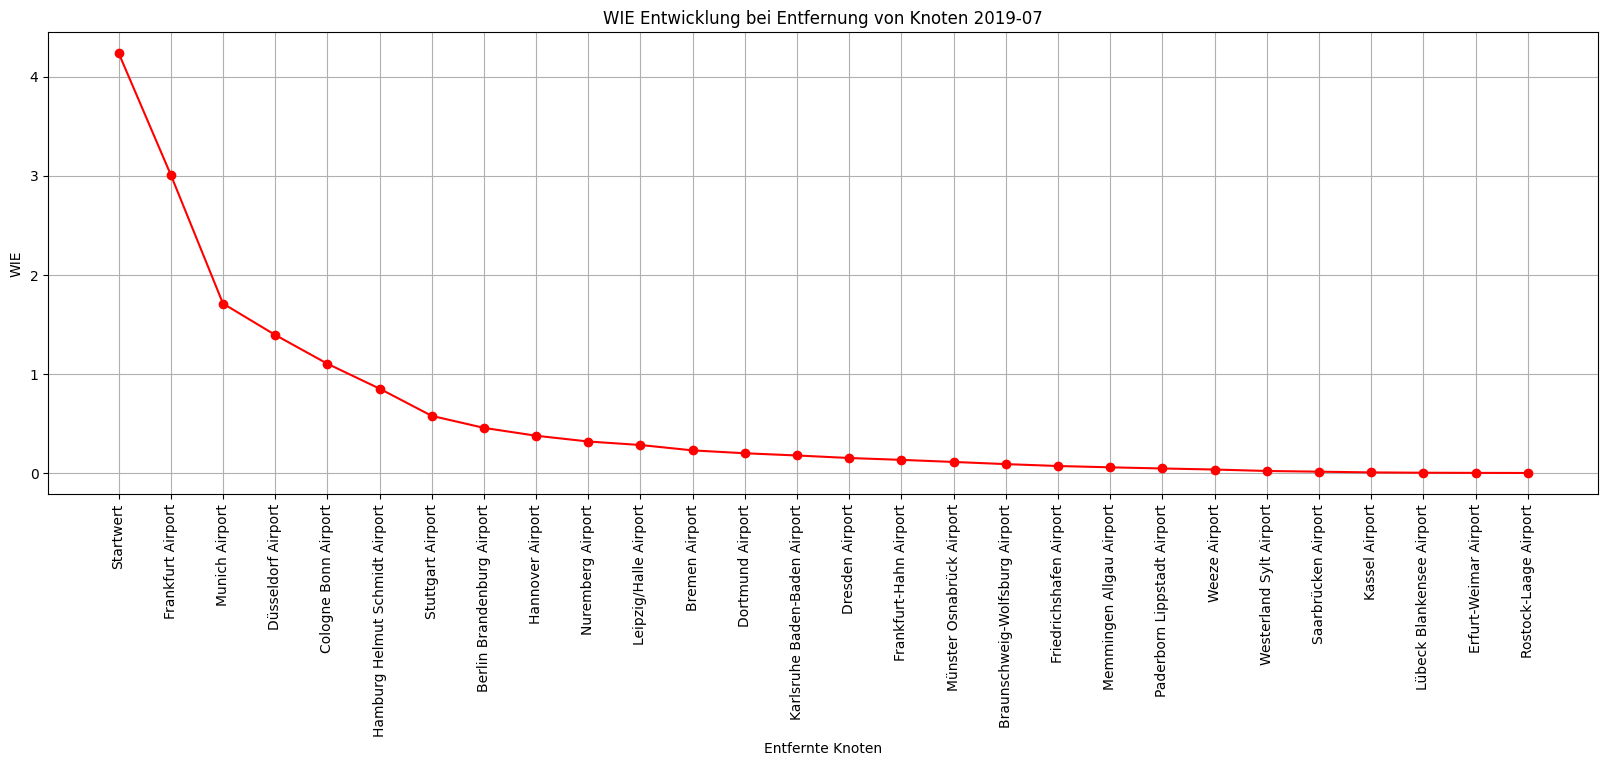

Number of nodes (airports): 972
Number of edges (flight routes): 5420, sum of weights (flights) 66071.0
Found 1382 international airports to check against
WIE_post has become zero.
International robustness for 2019-08: 0.7154808700894387


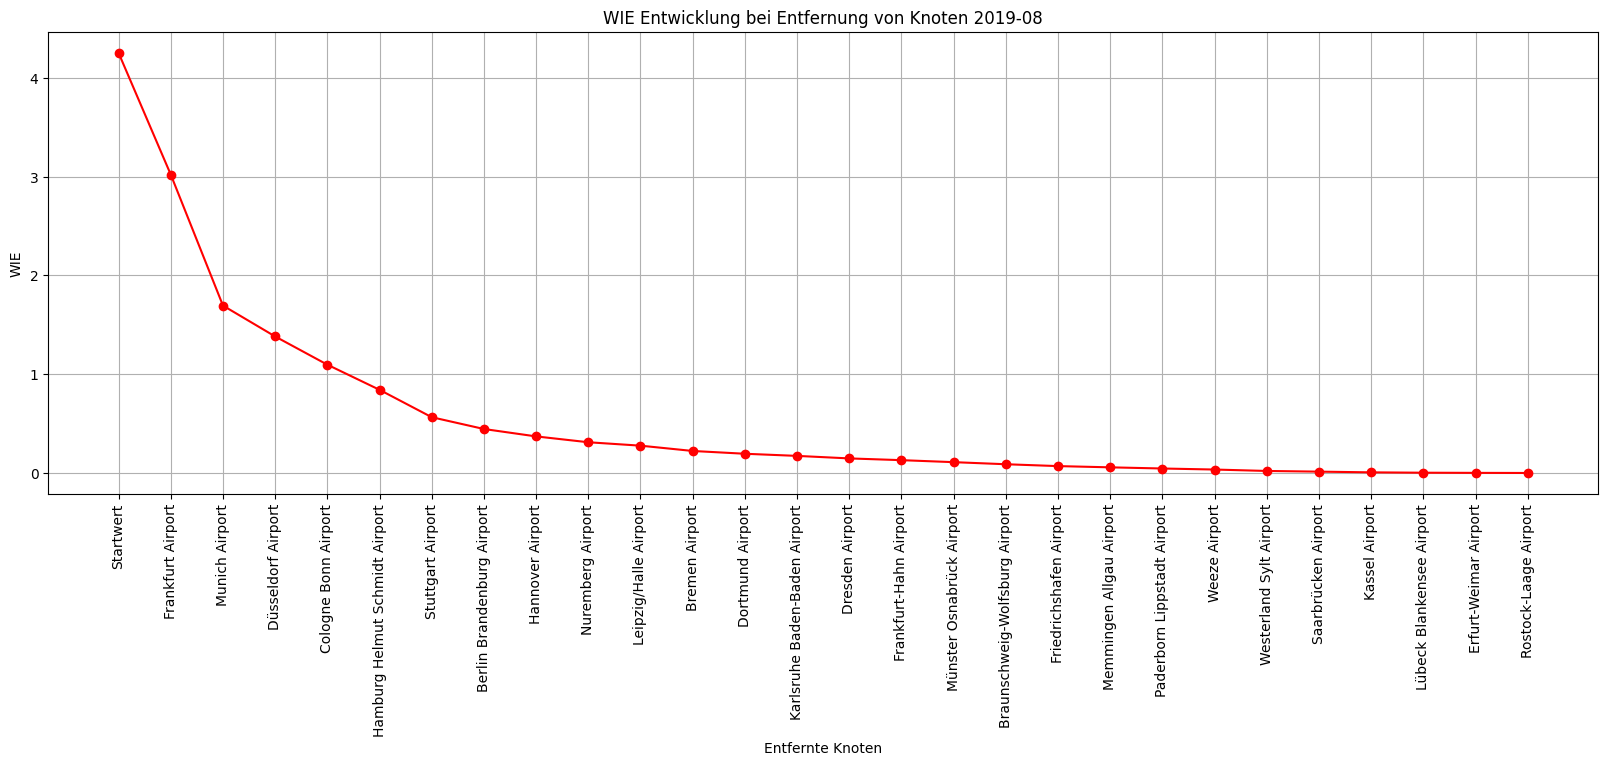

Number of nodes (airports): 994
Number of edges (flight routes): 5487, sum of weights (flights) 66182.0
Found 1382 international airports to check against
WIE_post has become zero.
International robustness for 2019-09: 0.7128067874649369


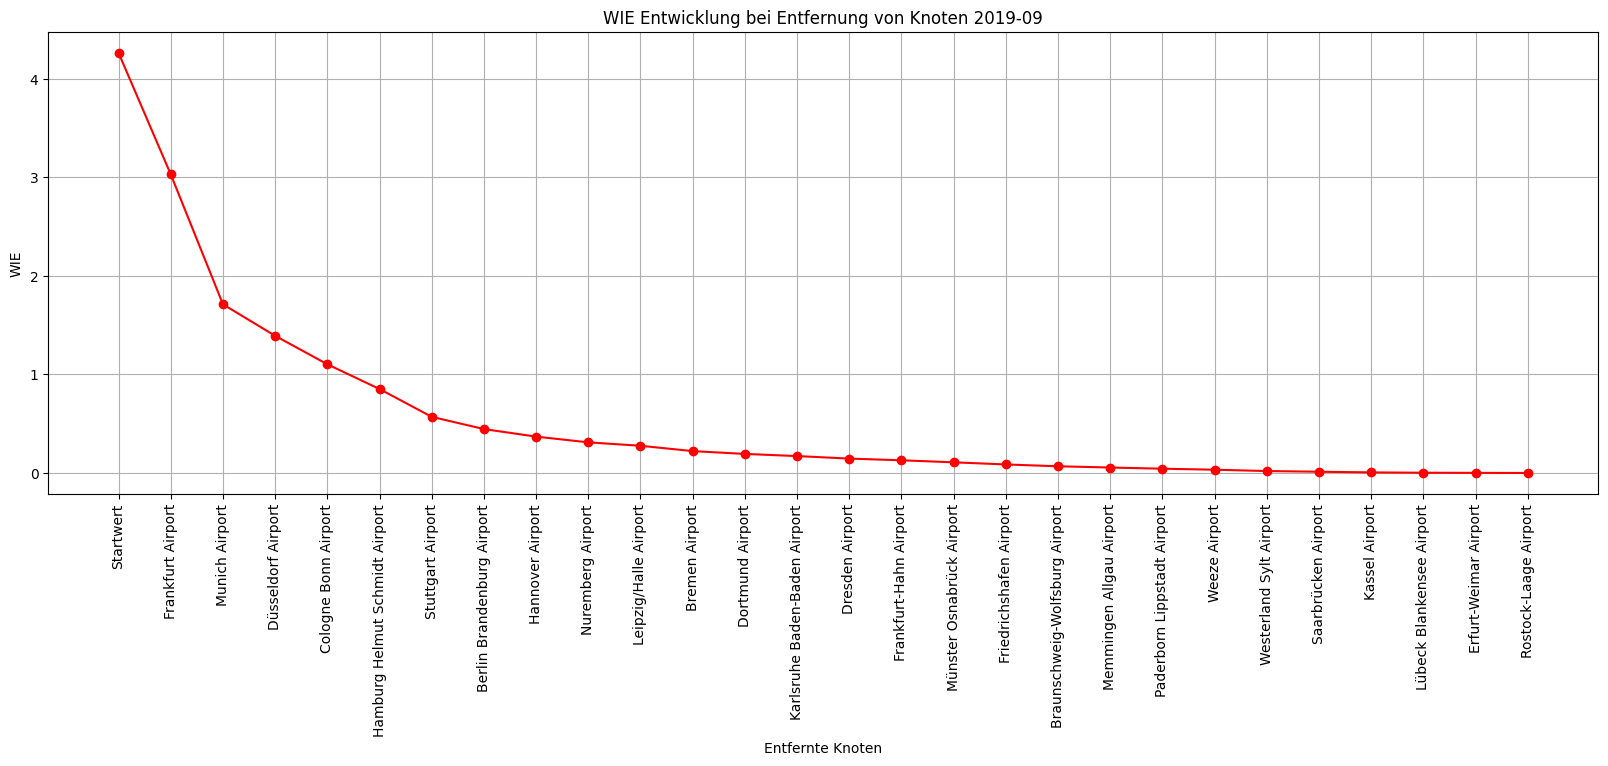

/content/drive/My Drive/2024KomplexeNetze/Daten/2019-10-01_2020-01-01_deutschland.csv
Number of nodes (airports): 933
Number of edges (flight routes): 5163, sum of weights (flights) 57585.0
Found 1209 international airports to check against
WIE_post has become zero.
International robustness for 2019-10: 0.7224711795403554


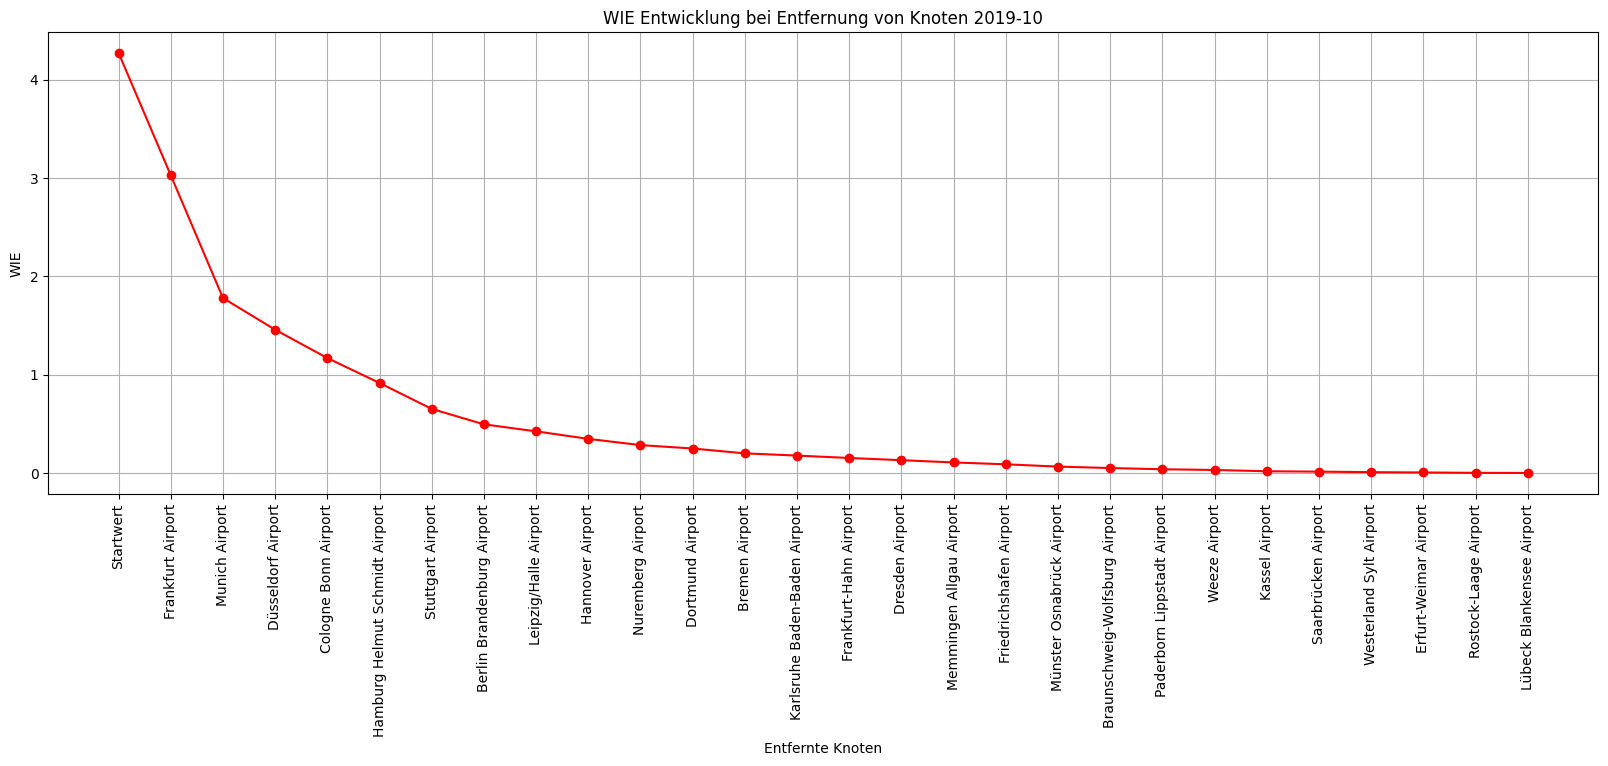

Number of nodes (airports): 813
Number of edges (flight routes): 4938, sum of weights (flights) 57086.0
Found 1209 international airports to check against
WIE_post has become zero.
International robustness for 2019-11: 0.7223440845231546


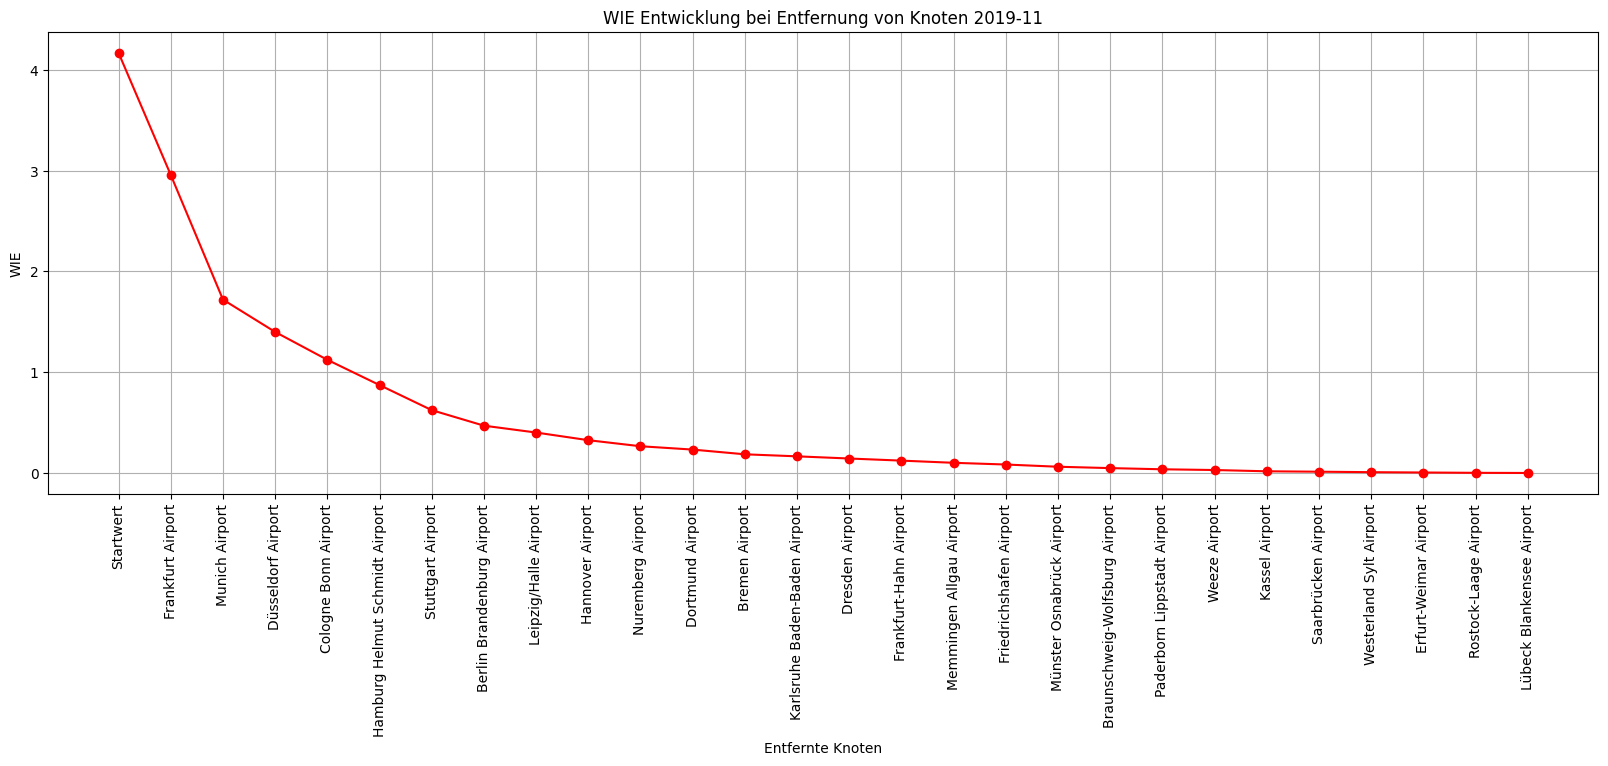

Number of nodes (airports): 836
Number of edges (flight routes): 4927, sum of weights (flights) 57017.0
Found 1209 international airports to check against
WIE_post has become zero.
International robustness for 2019-12: 0.7218618424635614


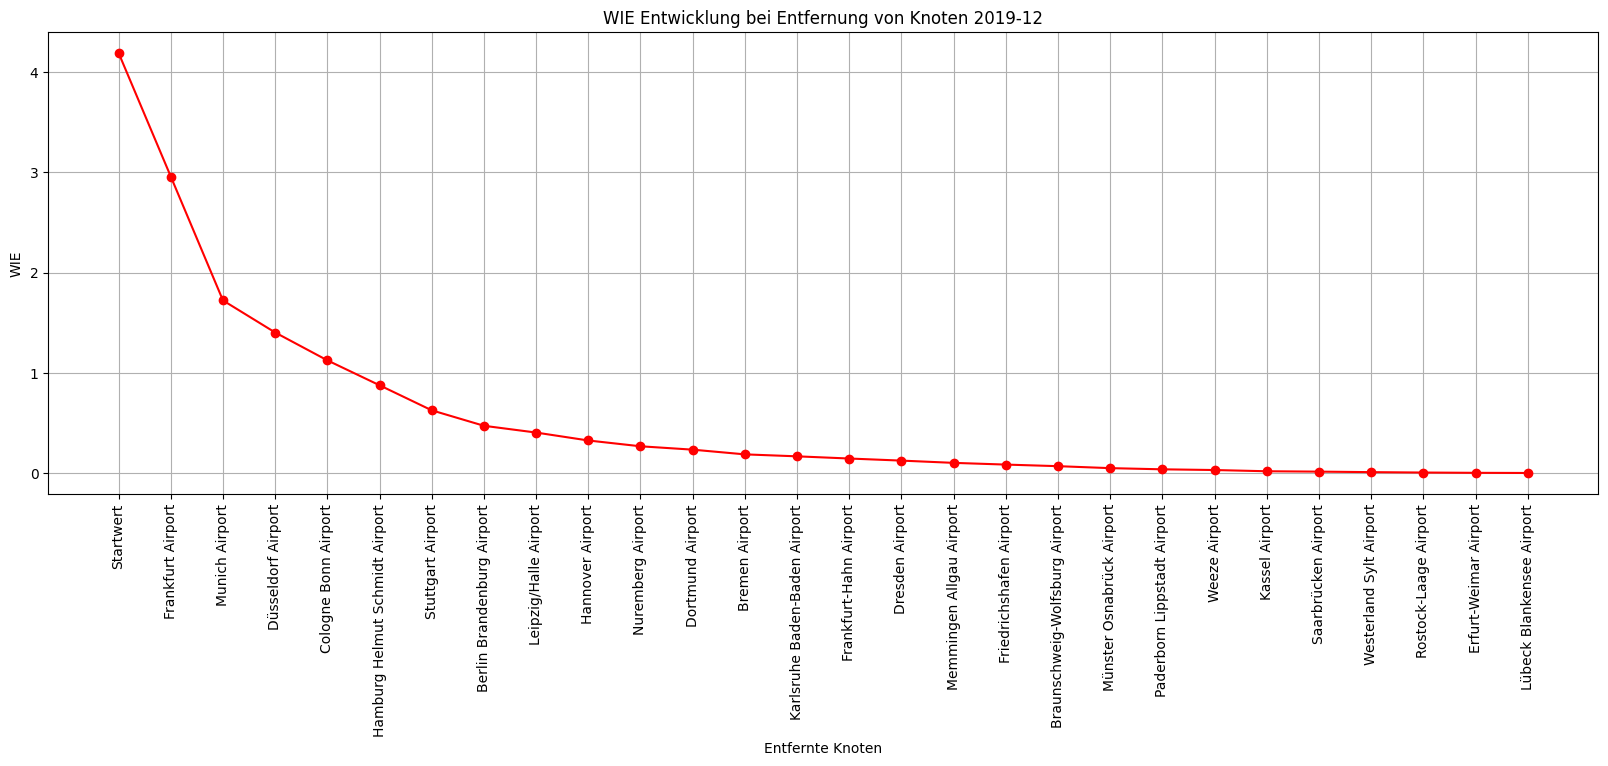

/content/drive/My Drive/2024KomplexeNetze/Daten/2020-01-01_2020-04-01_deutschland.csv
Number of nodes (airports): 833
Number of edges (flight routes): 4508, sum of weights (flights) 37995.0
Found 1147 international airports to check against
WIE_post has become zero.
International robustness for 2020-01: 0.7169418680288544


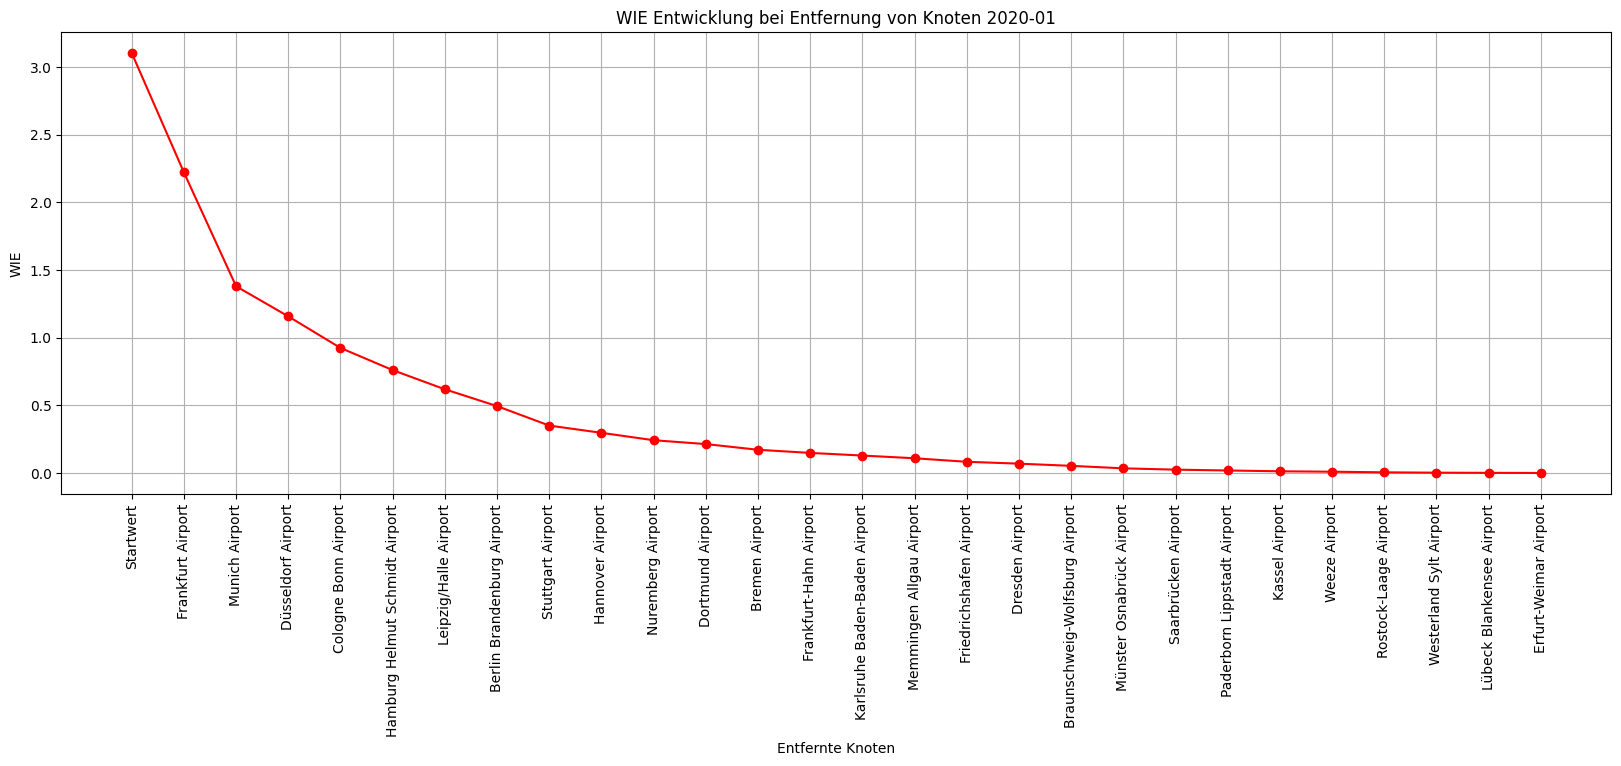

Number of nodes (airports): 808
Number of edges (flight routes): 4498, sum of weights (flights) 38006.0
Found 1147 international airports to check against
WIE_post has become zero.
International robustness for 2020-02: 0.7166018317583236


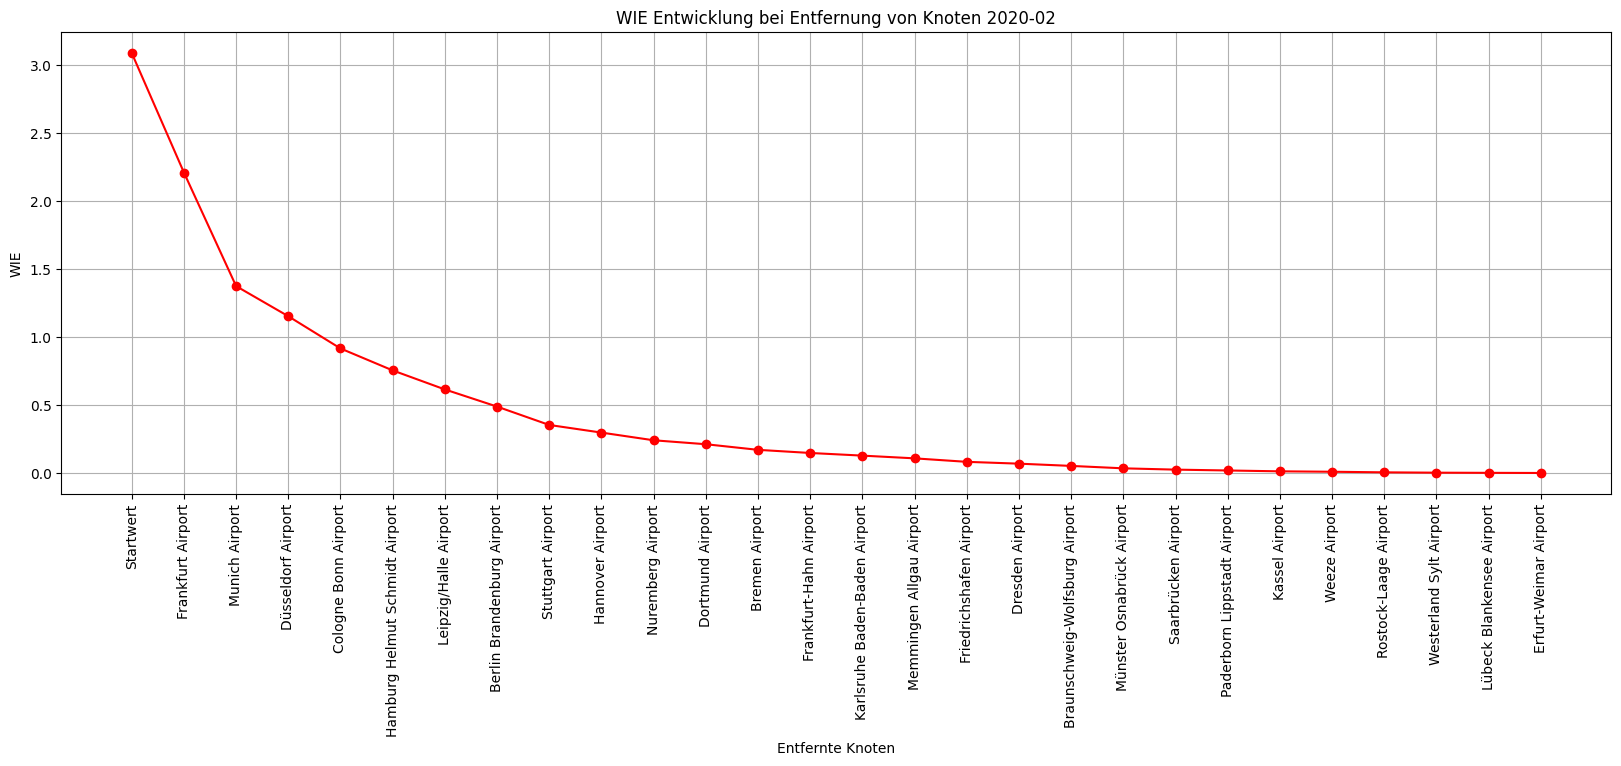

Number of nodes (airports): 809
Number of edges (flight routes): 4425, sum of weights (flights) 37887.0
Found 1147 international airports to check against
WIE_post has become zero.
International robustness for 2020-03: 0.715587221787545


/content/drive/My Drive/2024KomplexeNetze/Daten/2020-04-01_2020-07-01_deutschland.csv
Number of nodes (airports): 577
Number of edges (flight routes): 3300, sum of weights (flights) 16648.0
Found 959 international airports to check against
WIE_post has become zero.
International robustness for 2020-04: 0.7324327243713358


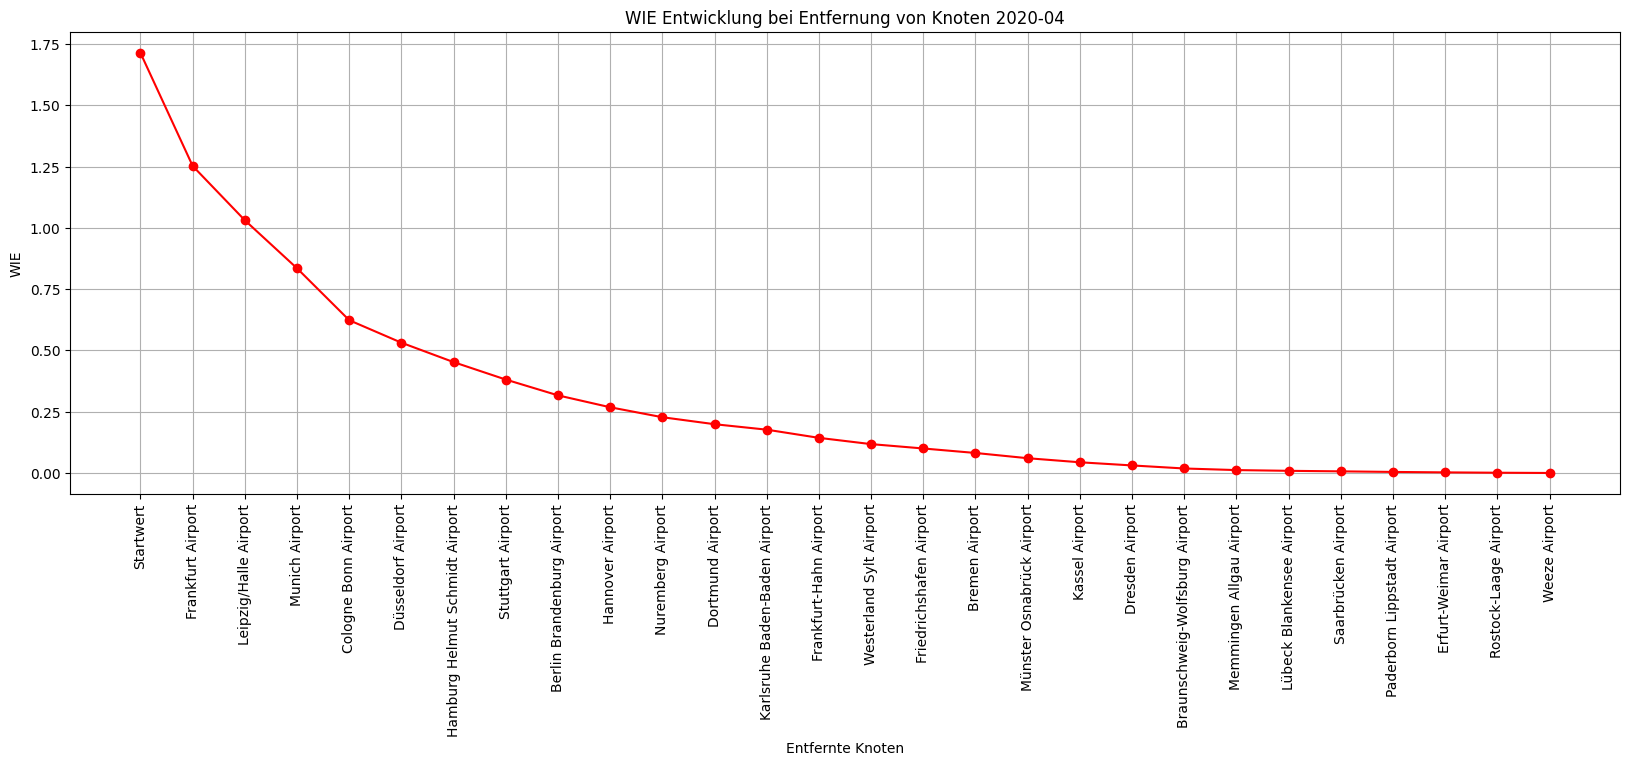

Number of nodes (airports): 642
Number of edges (flight routes): 3512, sum of weights (flights) 17284.0
Found 959 international airports to check against
WIE_post has become zero.
International robustness for 2020-05: 0.7315080227250322


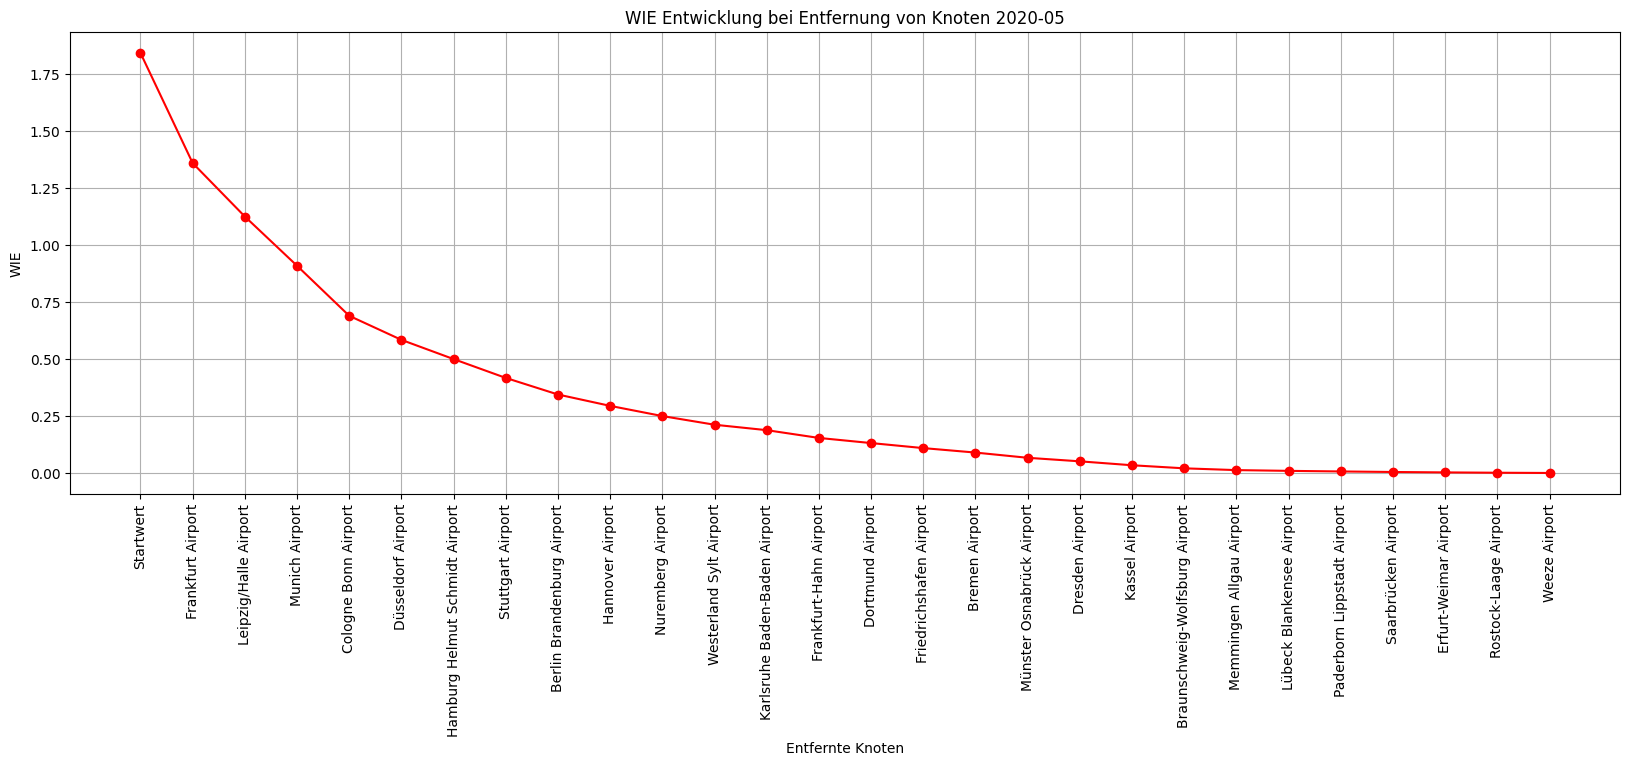

Number of nodes (airports): 778
Number of edges (flight routes): 3785, sum of weights (flights) 17680.0
Found 959 international airports to check against
WIE_post has become zero.
International robustness for 2020-06: 0.7322734661508362


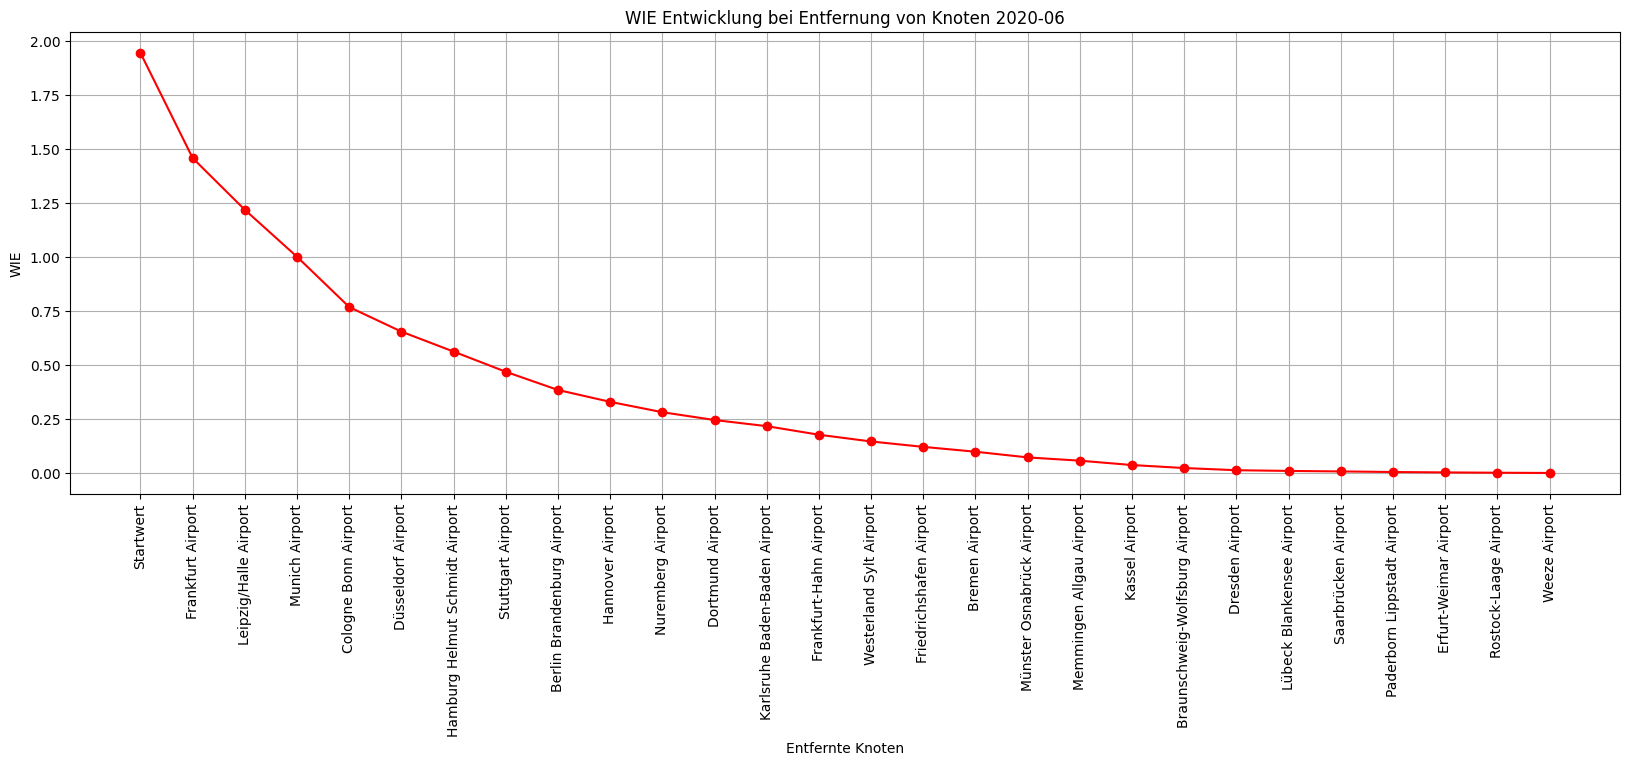

/content/drive/My Drive/2024KomplexeNetze/Daten/2020-07-01_2020-10-01_deutschland.csv
Number of nodes (airports): 890
Number of edges (flight routes): 5363, sum of weights (flights) 34020.0
Found 1221 international airports to check against
WIE_post has become zero.
International robustness for 2020-07: 0.7403599457149277


Number of nodes (airports): 890
Number of edges (flight routes): 5402, sum of weights (flights) 33799.0
Found 1221 international airports to check against
WIE_post has become zero.
International robustness for 2020-08: 0.7407066757652232


Number of nodes (airports): 891
Number of edges (flight routes): 5345, sum of weights (flights) 33692.0
Found 1221 international airports to check against
WIE_post has become zero.
International robustness for 2020-09: 0.7394671650479115


/content/drive/My Drive/2024KomplexeNetze/Daten/2020-10-01_2021-01-01_deutschland.csv
Number of nodes (airports): 824
Number of edges (flight routes): 4516, sum of weights (flights) 23396.0
Found 1068 international airports to check against
WIE_post has become zero.
International robustness for 2020-10: 0.7406135399830457


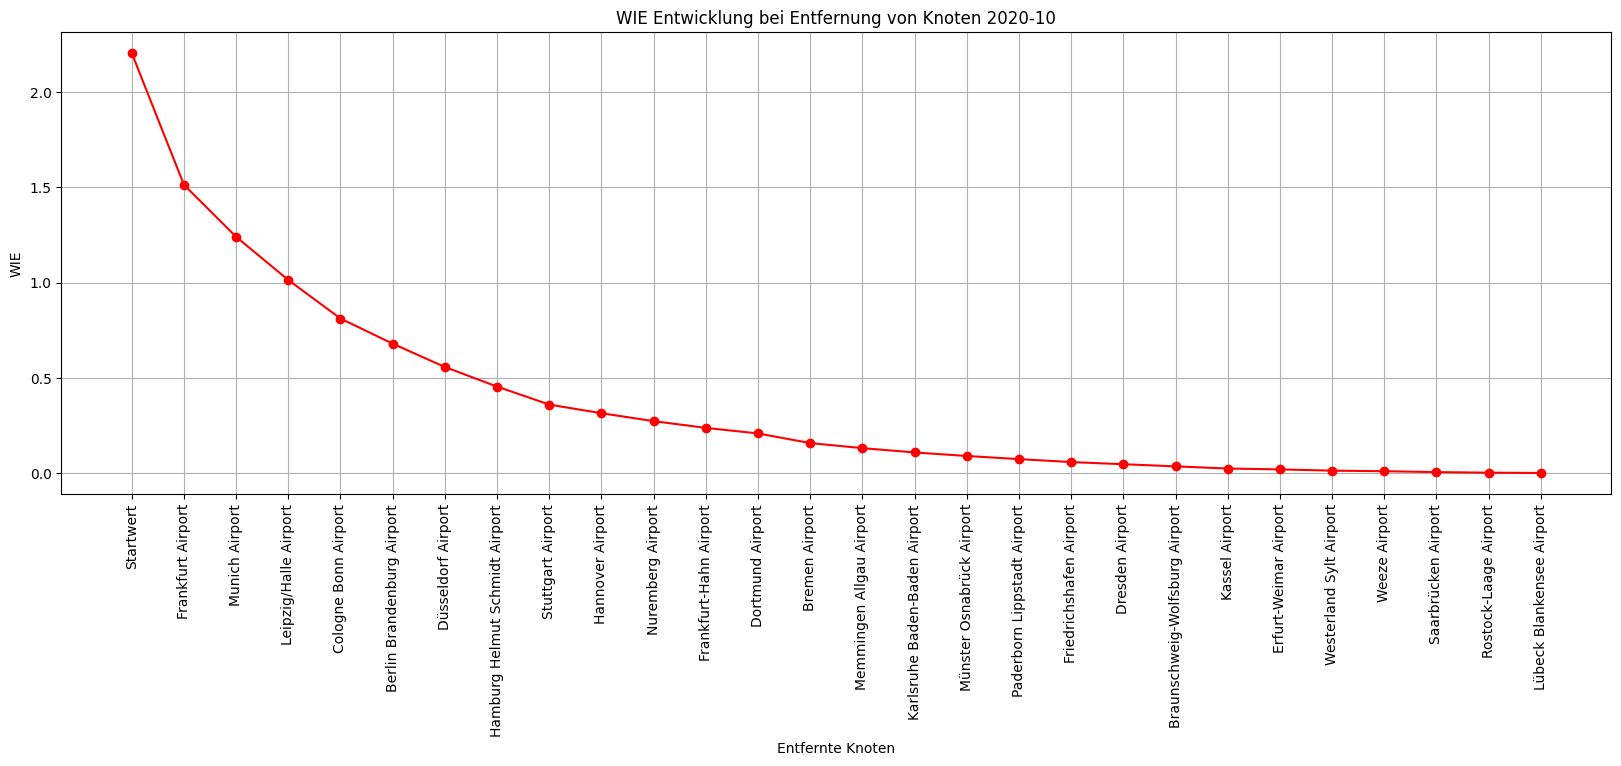

Number of nodes (airports): 708
Number of edges (flight routes): 4247, sum of weights (flights) 22979.0
Found 1068 international airports to check against
WIE_post has become zero.
International robustness for 2020-11: 0.7391549145239915


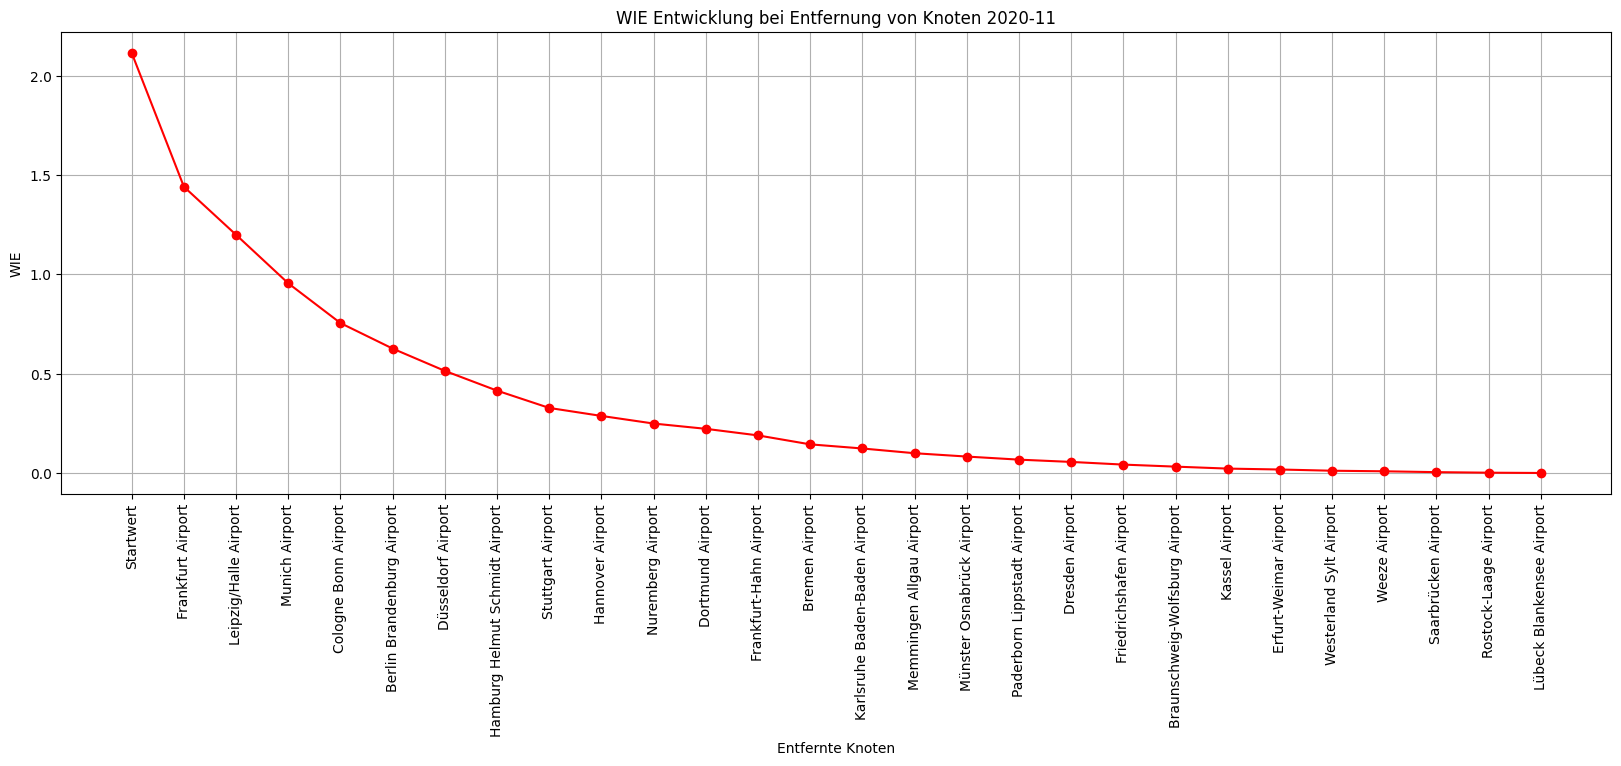

Number of nodes (airports): 696
Number of edges (flight routes): 4127, sum of weights (flights) 22665.0
Found 1068 international airports to check against
WIE_post has become zero.
International robustness for 2020-12: 0.7408632884366434


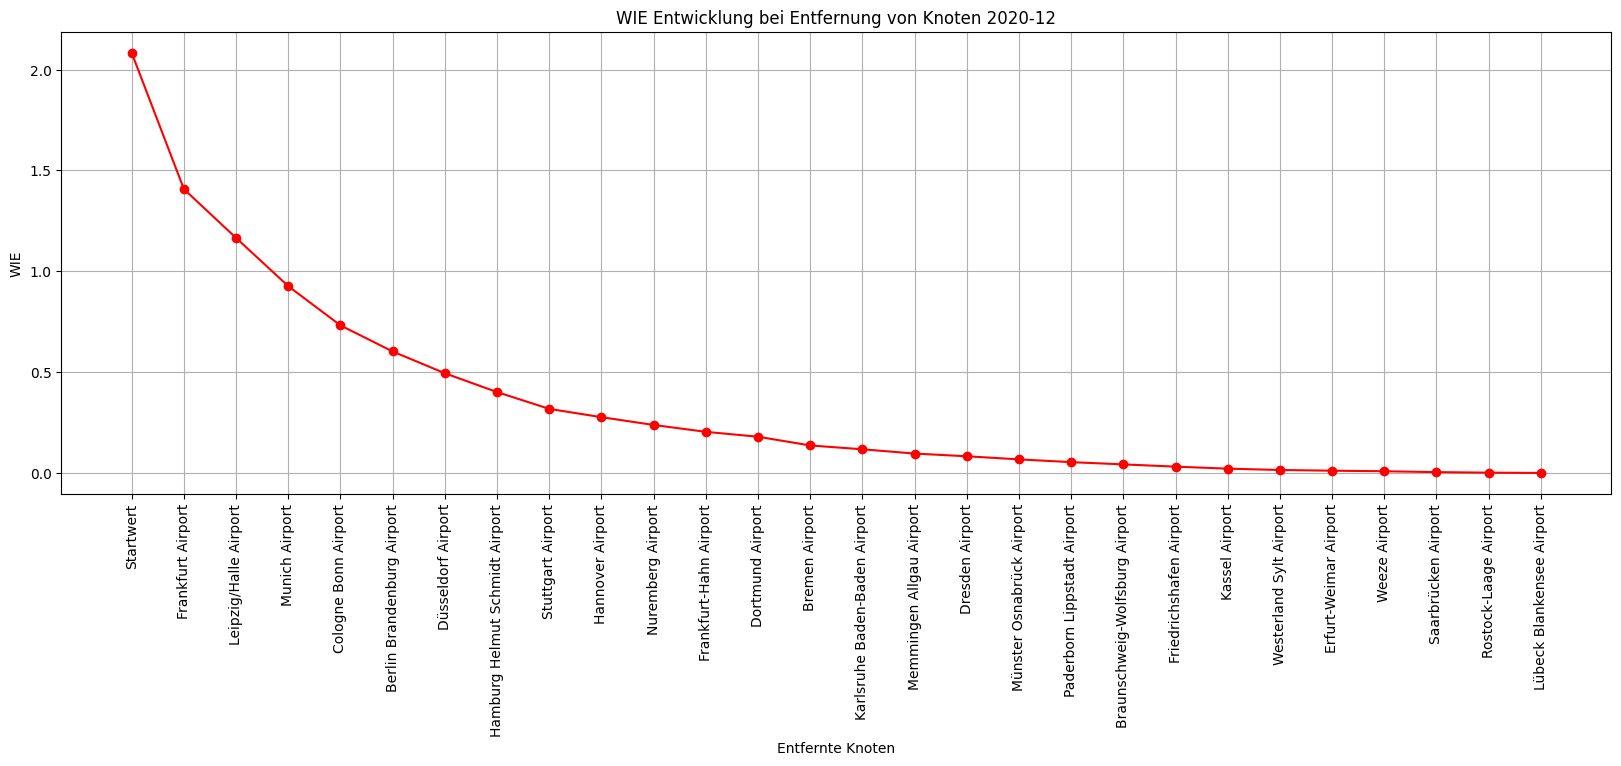

/content/drive/My Drive/2024KomplexeNetze/Daten/2021-01-01_2021-04-01_deutschland.csv
Number of nodes (airports): 654
Number of edges (flight routes): 3705, sum of weights (flights) 21022.0
Found 991 international airports to check against
WIE_post has become zero.
International robustness for 2021-01: 0.7299301628159627


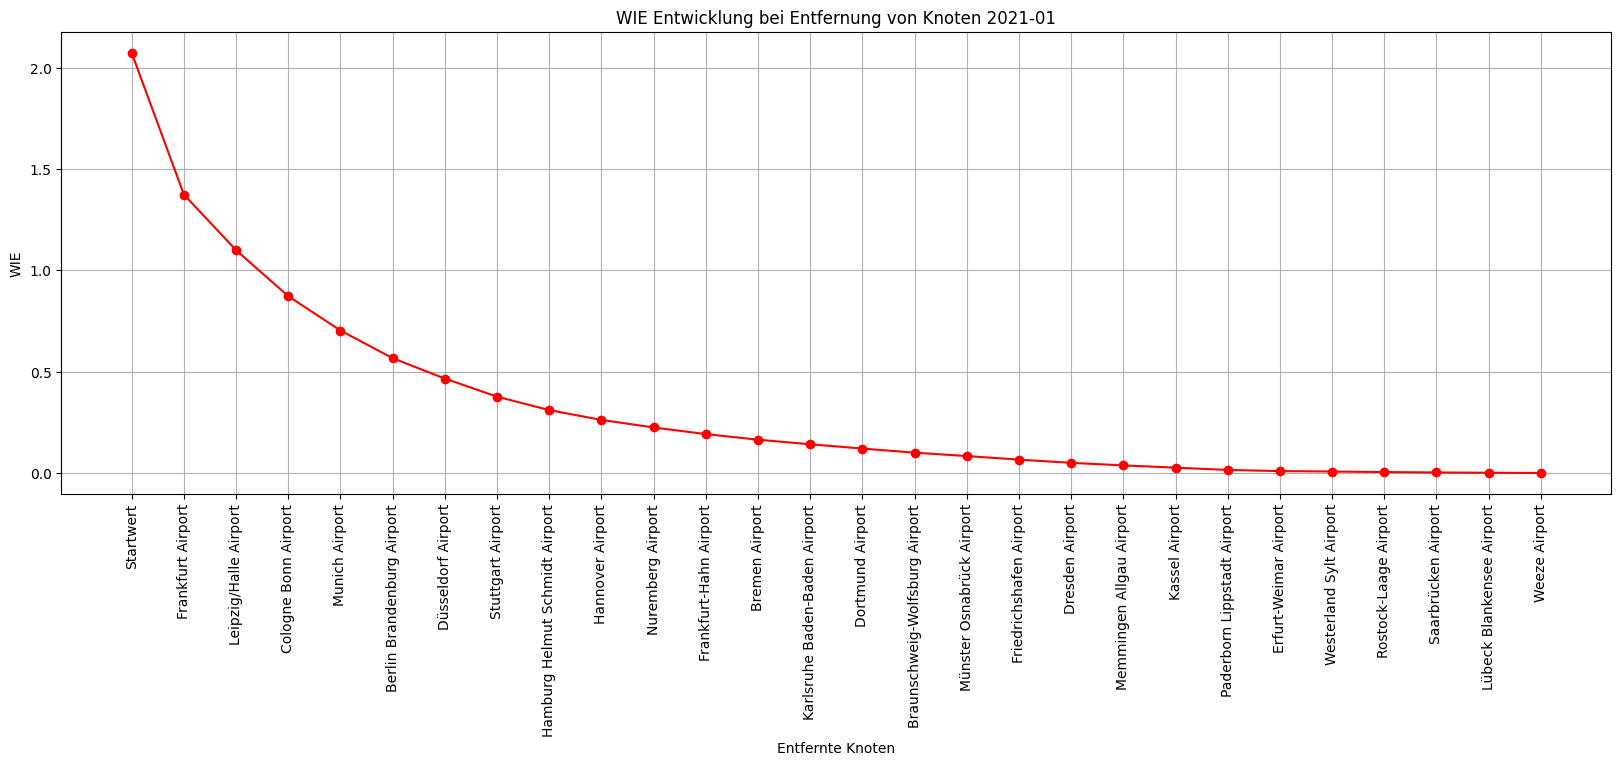

Number of nodes (airports): 702
Number of edges (flight routes): 3784, sum of weights (flights) 21168.0
Found 991 international airports to check against
WIE_post has become zero.
International robustness for 2021-02: 0.7281666649449244


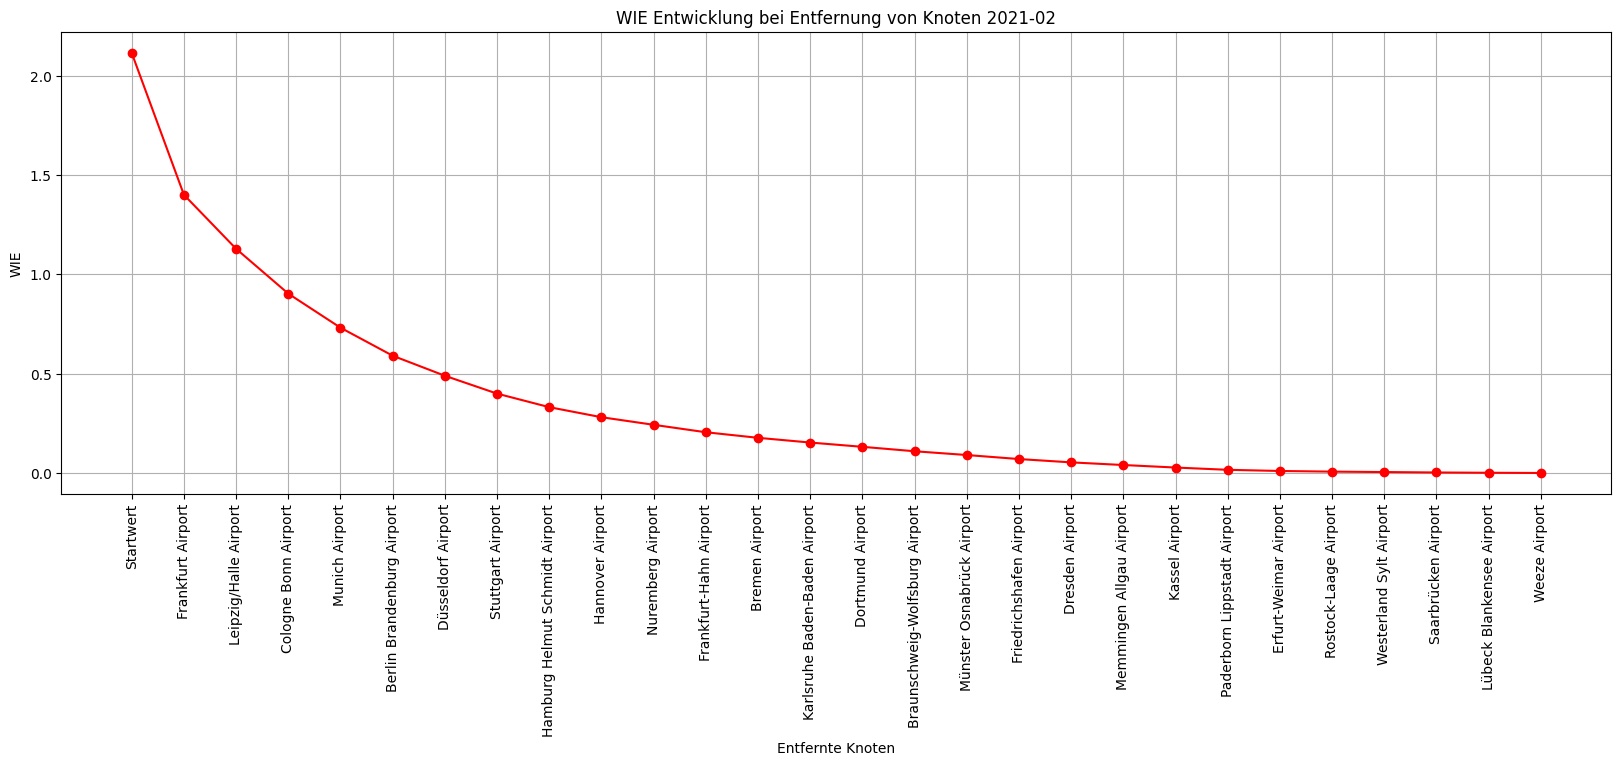

Number of nodes (airports): 753
Number of edges (flight routes): 3880, sum of weights (flights) 21225.0
Found 991 international airports to check against
WIE_post has become zero.
International robustness for 2021-03: 0.7262428116183782


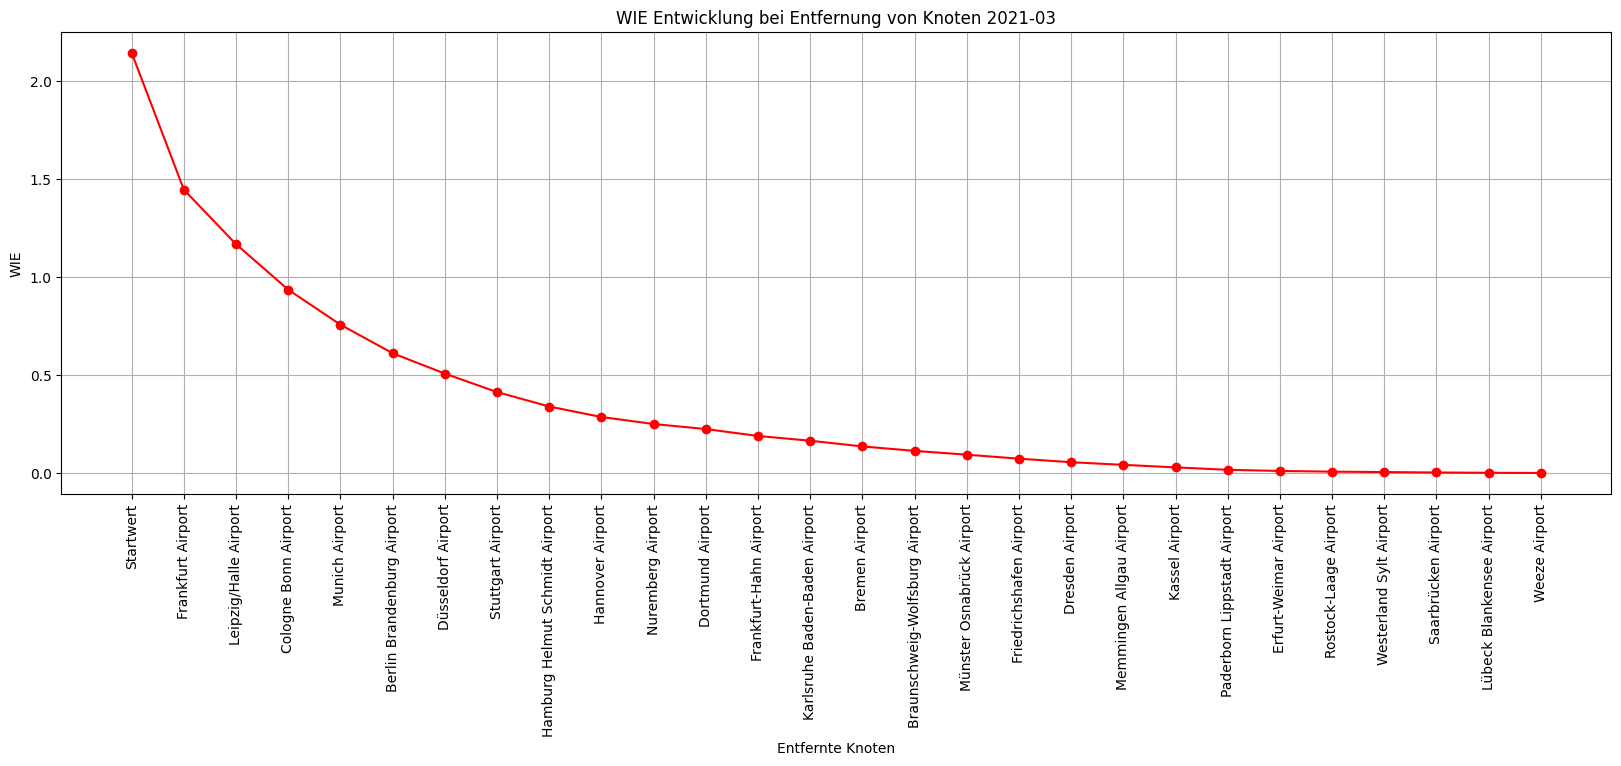

/content/drive/My Drive/2024KomplexeNetze/Daten/2021-04-01_2021-07-01_deutschland.csv
Number of nodes (airports): 784
Number of edges (flight routes): 4932, sum of weights (flights) 33355.0
Found 1194 international airports to check against
WIE_post has become zero.
International robustness for 2021-04: 0.7440100609834883


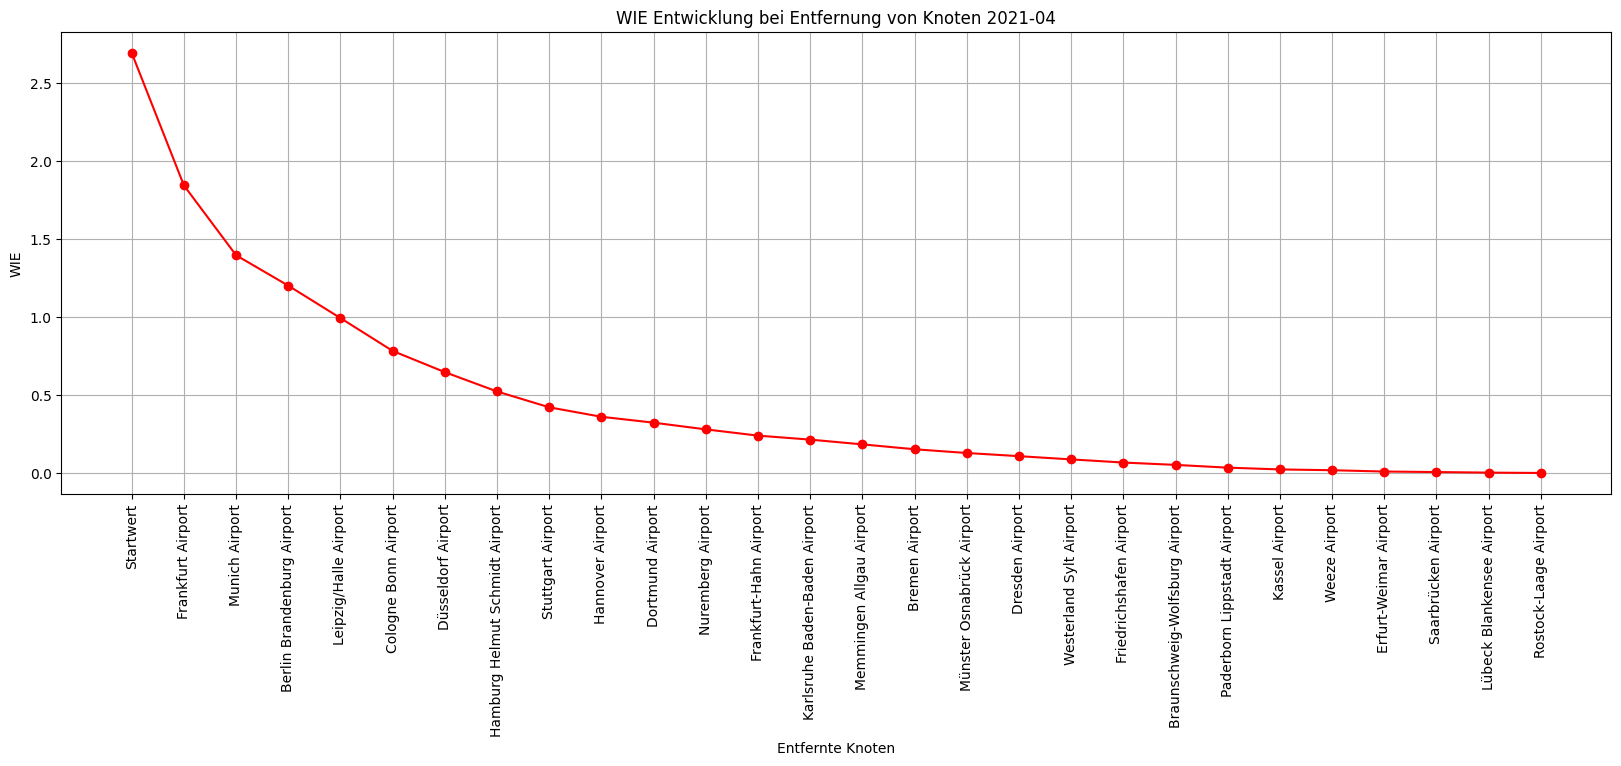

Number of nodes (airports): 843
Number of edges (flight routes): 5125, sum of weights (flights) 33778.0
Found 1194 international airports to check against
WIE_post has become zero.
International robustness for 2021-05: 0.7429336312709743


Number of nodes (airports): 942
Number of edges (flight routes): 5297, sum of weights (flights) 34076.0
Found 1194 international airports to check against
WIE_post has become zero.
International robustness for 2021-06: 0.7427869335145957


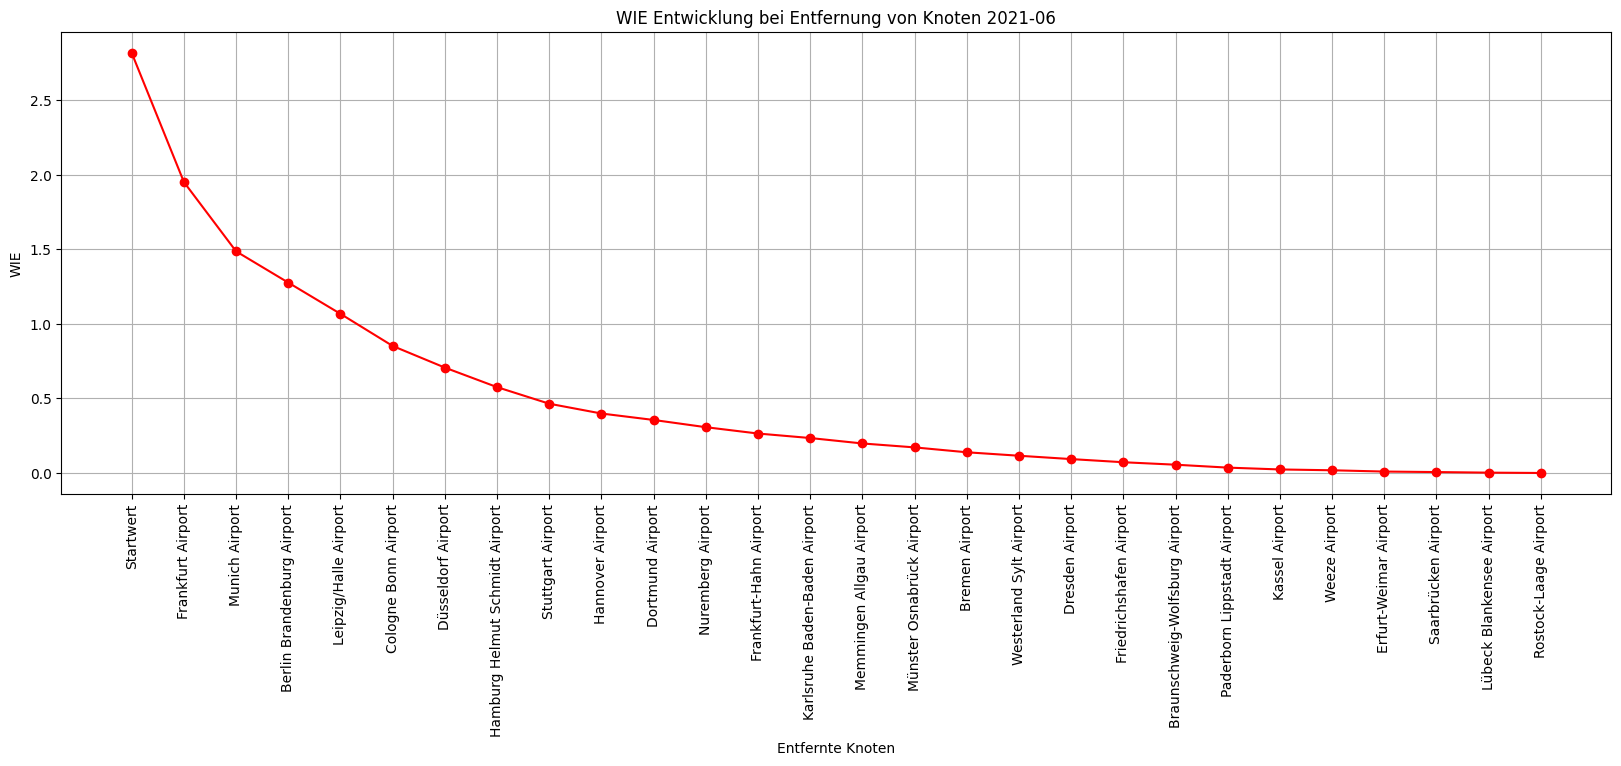

/content/drive/My Drive/2024KomplexeNetze/Daten/2021-07-01_2021-10-01_deutschland.csv
Number of nodes (airports): 999
Number of edges (flight routes): 6479, sum of weights (flights) 49426.0
Found 1370 international airports to check against
WIE_post has become zero.
International robustness for 2021-07: 0.7404620463205153


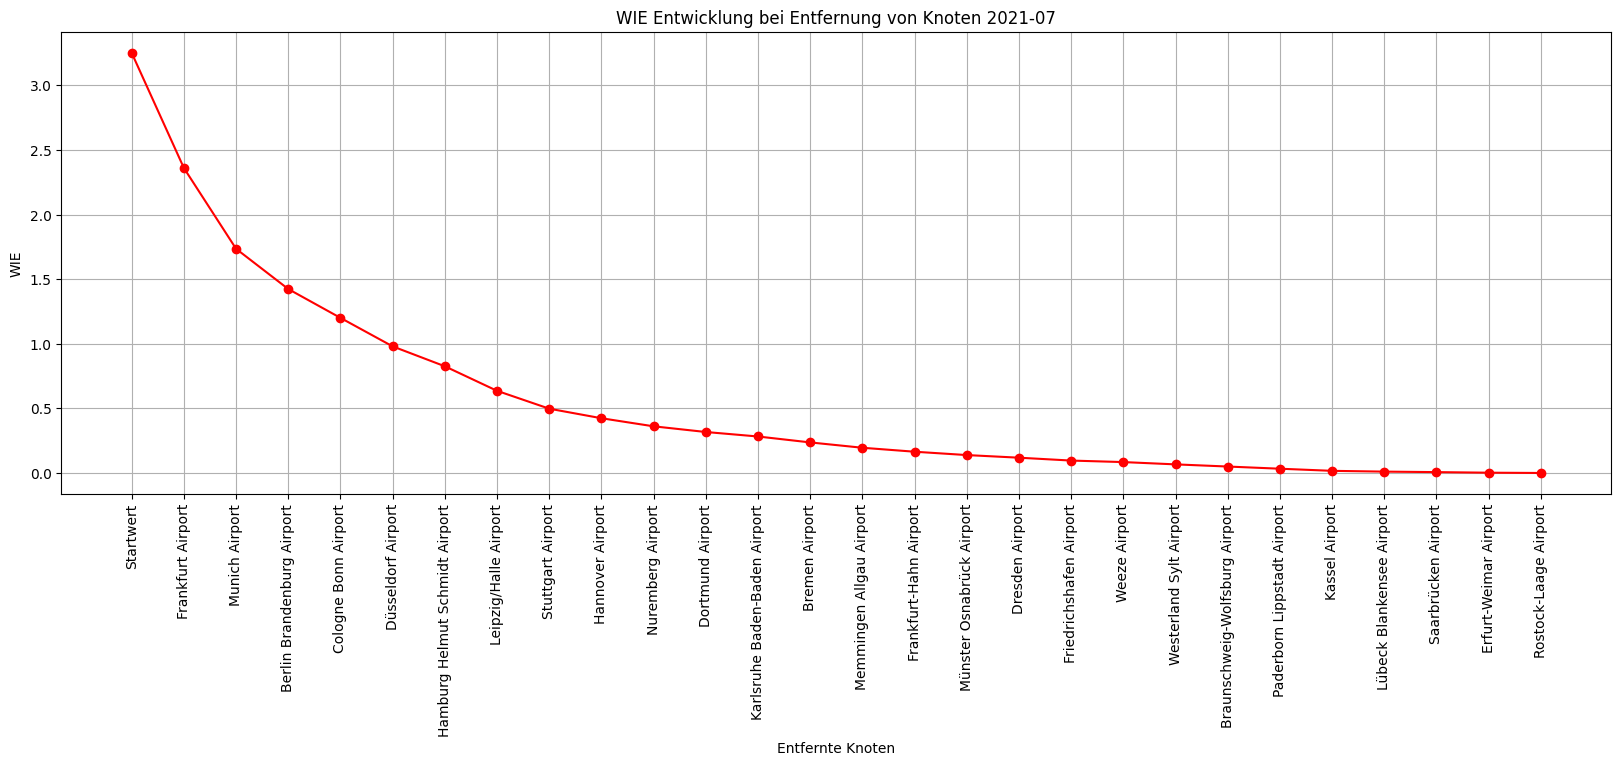

Number of nodes (airports): 973
Number of edges (flight routes): 6375, sum of weights (flights) 49235.0
Found 1370 international airports to check against
WIE_post has become zero.
International robustness for 2021-08: 0.7411236105015911


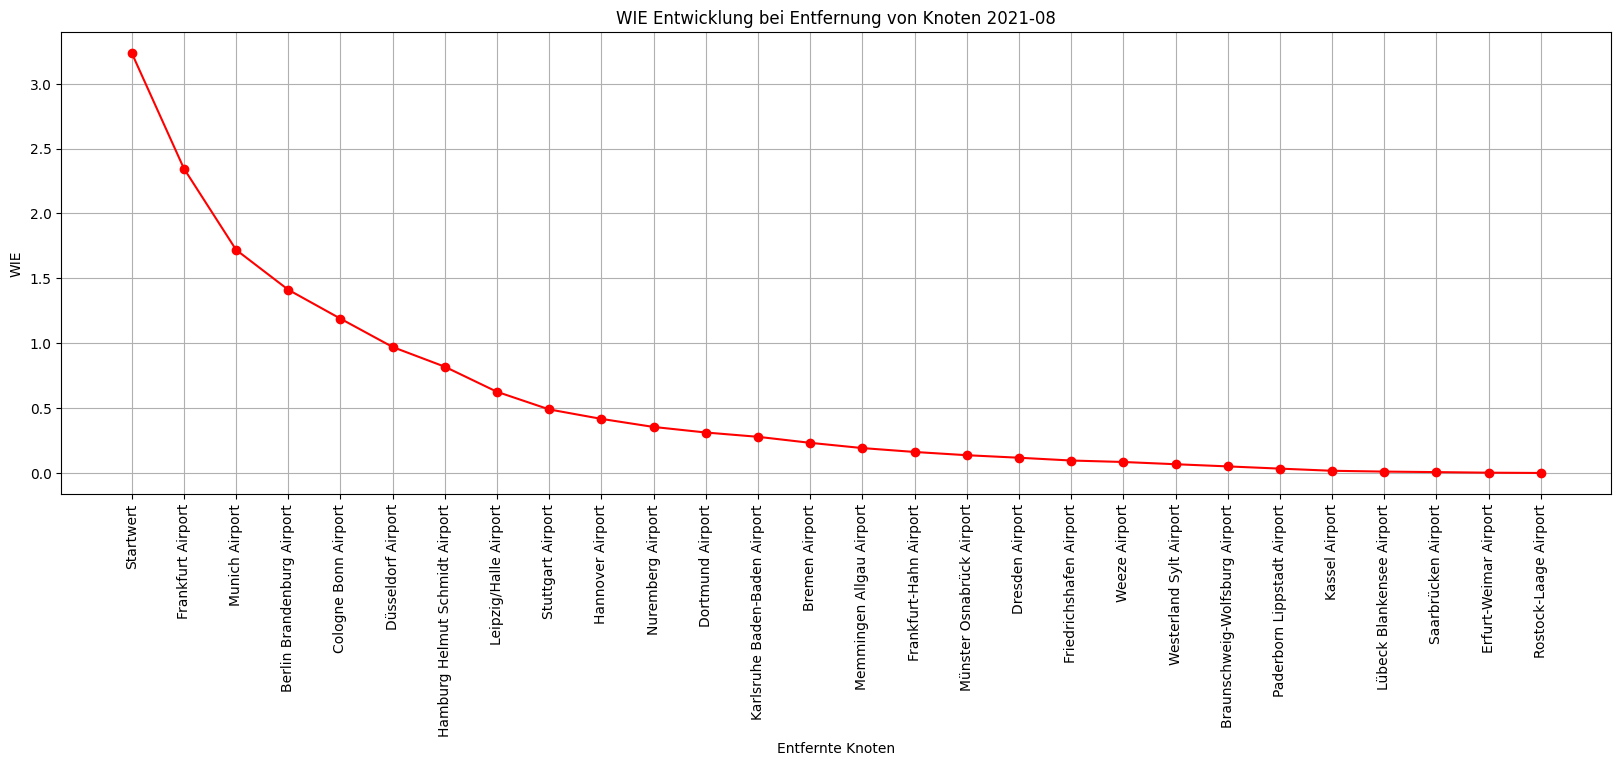

Number of nodes (airports): 1039
Number of edges (flight routes): 6439, sum of weights (flights) 49188.0
Found 1370 international airports to check against
WIE_post has become zero.
International robustness for 2021-09: 0.7419533526387075


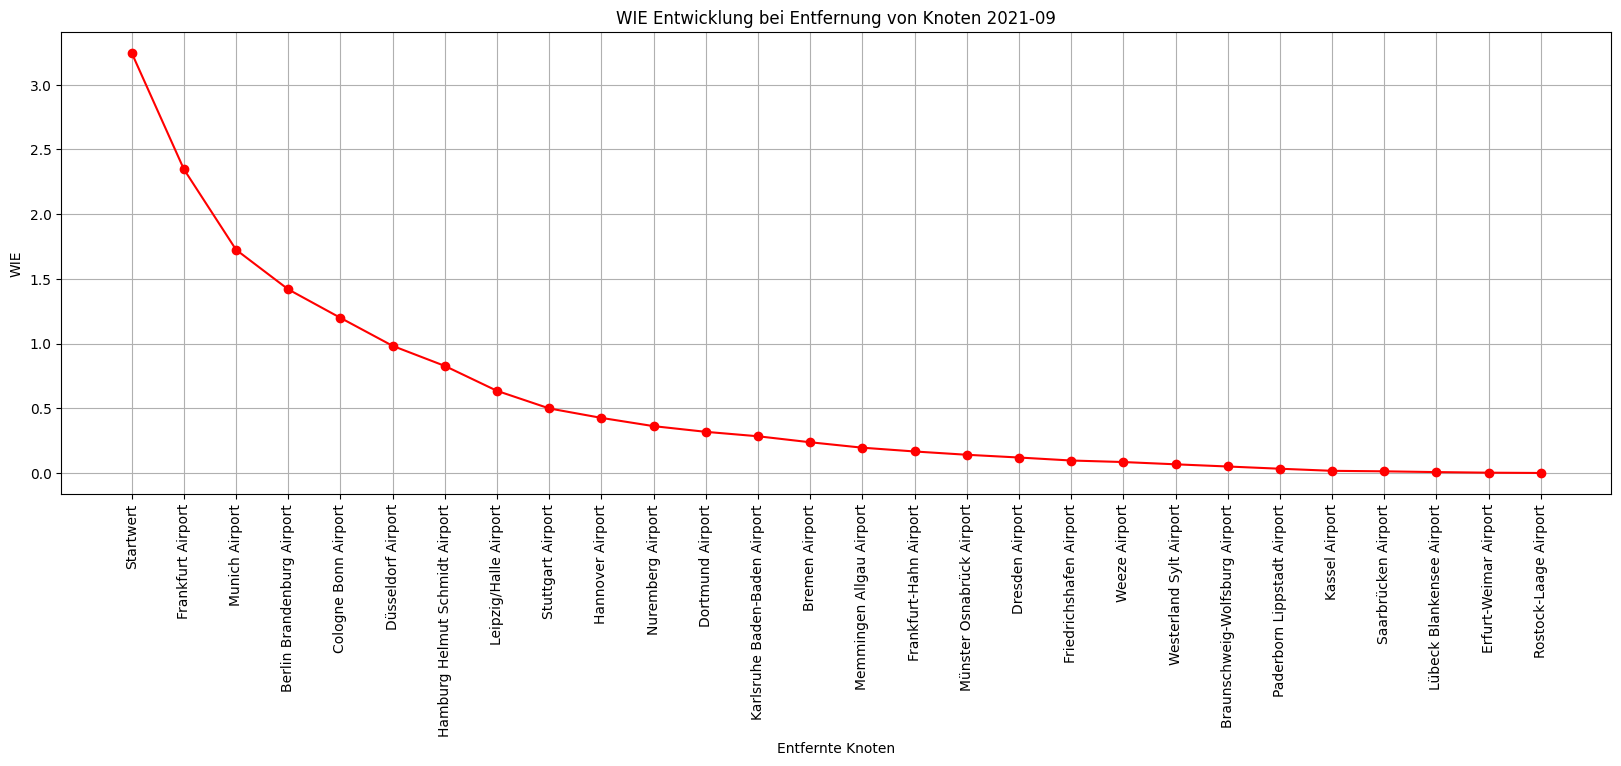

/content/drive/My Drive/2024KomplexeNetze/Daten/2021-10-01_2022-01-01_deutschland.csv
Number of nodes (airports): 1124
Number of edges (flight routes): 6179, sum of weights (flights) 48452.0
Found 1359 international airports to check against
WIE_post has become zero.
International robustness for 2021-10: 0.7299363532300448


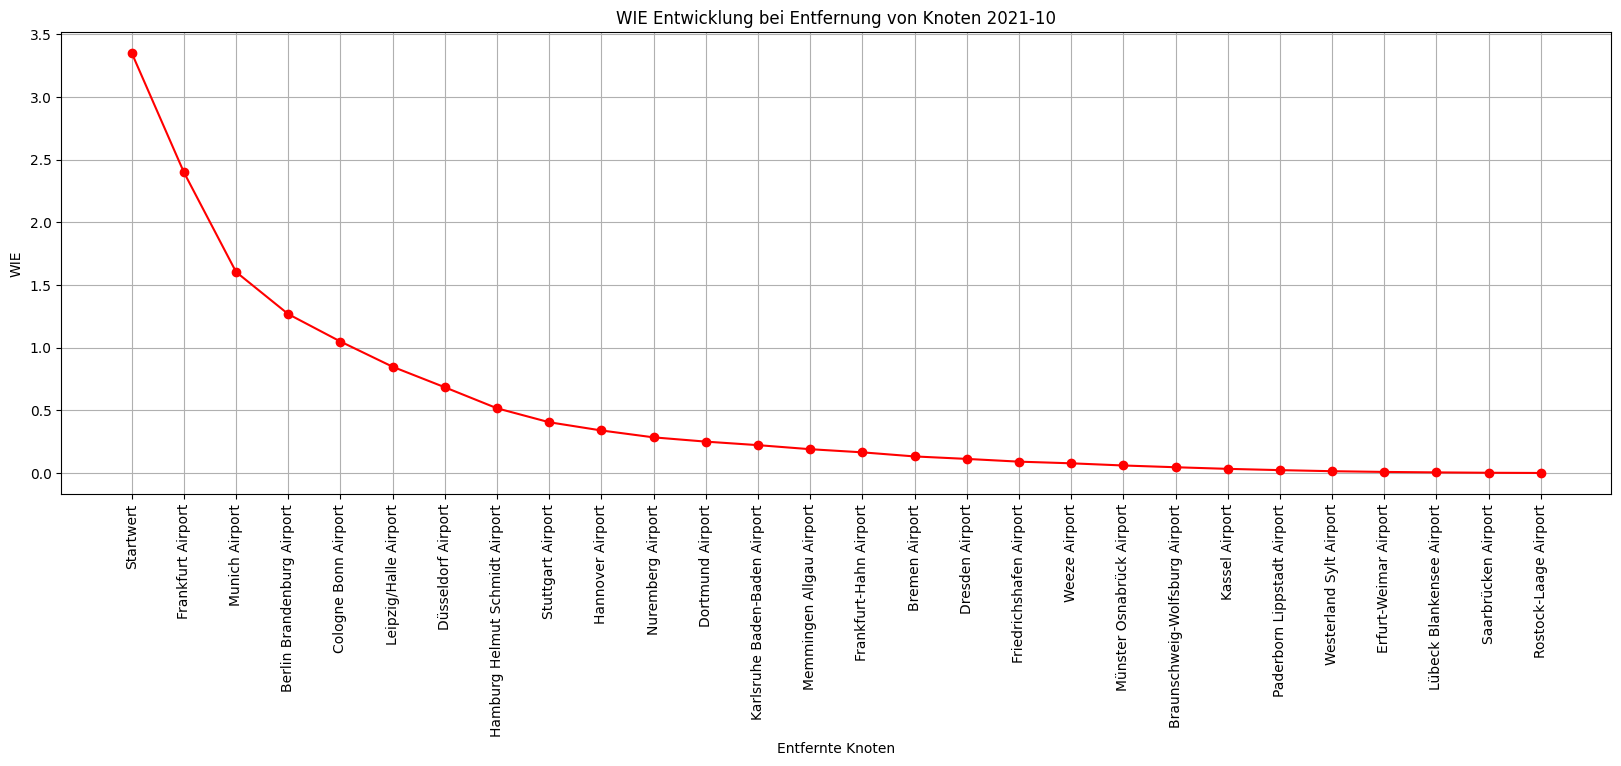

Number of nodes (airports): 844
Number of edges (flight routes): 5577, sum of weights (flights) 47611.0
Found 1359 international airports to check against
WIE_post has become zero.
International robustness for 2021-11: 0.7291944554429427


Number of nodes (airports): 824
Number of edges (flight routes): 5458, sum of weights (flights) 47481.0
Found 1359 international airports to check against
WIE_post has become zero.
International robustness for 2021-12: 0.7302135053454245


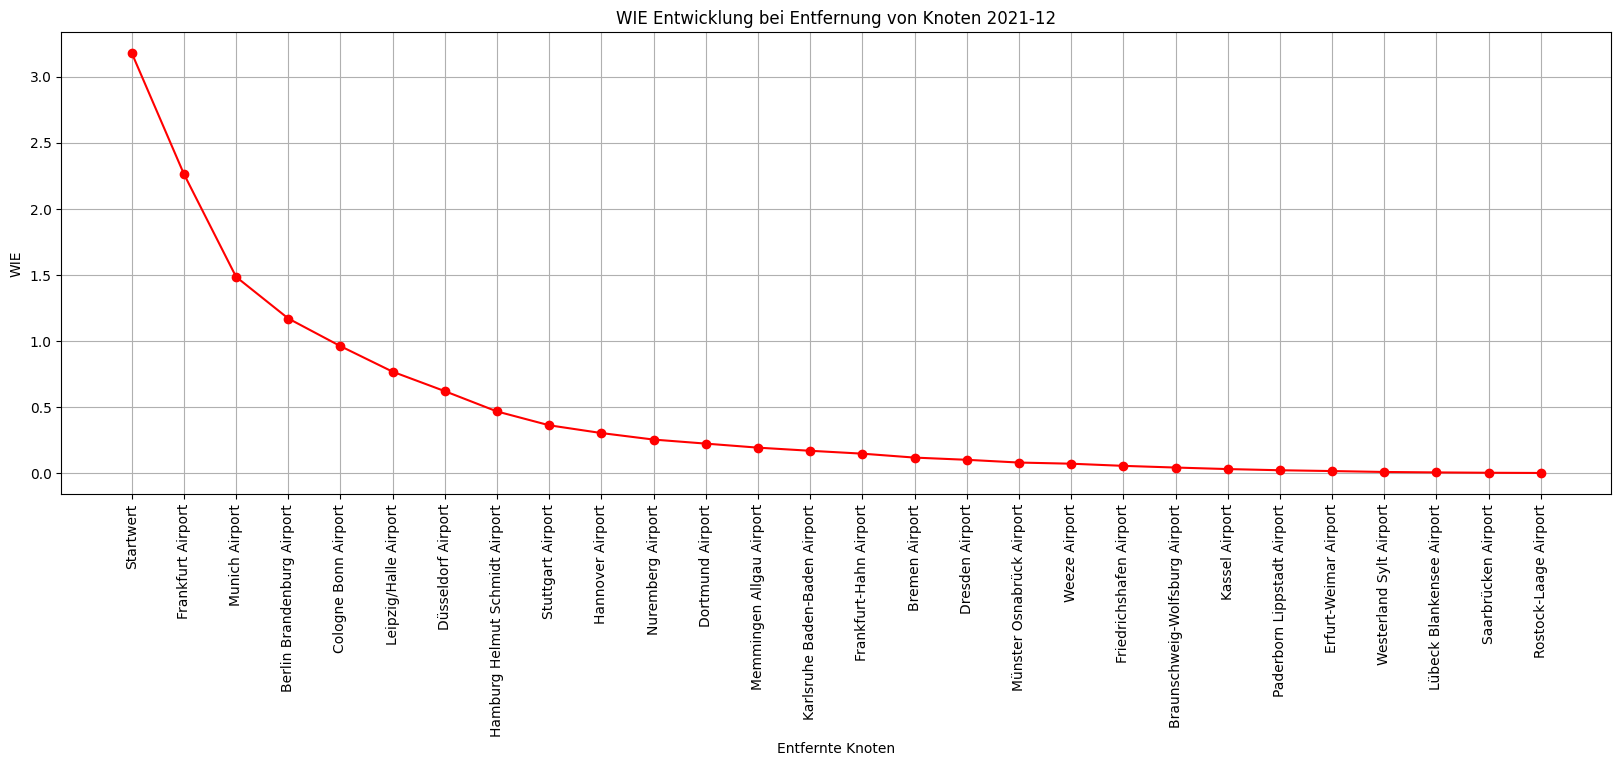

/content/drive/My Drive/2024KomplexeNetze/Daten/2023-01-01_2023-04-01_deutschland.csv
Number of nodes (airports): 847
Number of edges (flight routes): 5352, sum of weights (flights) 54852.0
Found 1249 international airports to check against
WIE_post has become zero.
International robustness for 2023-01: 0.7330385243410323


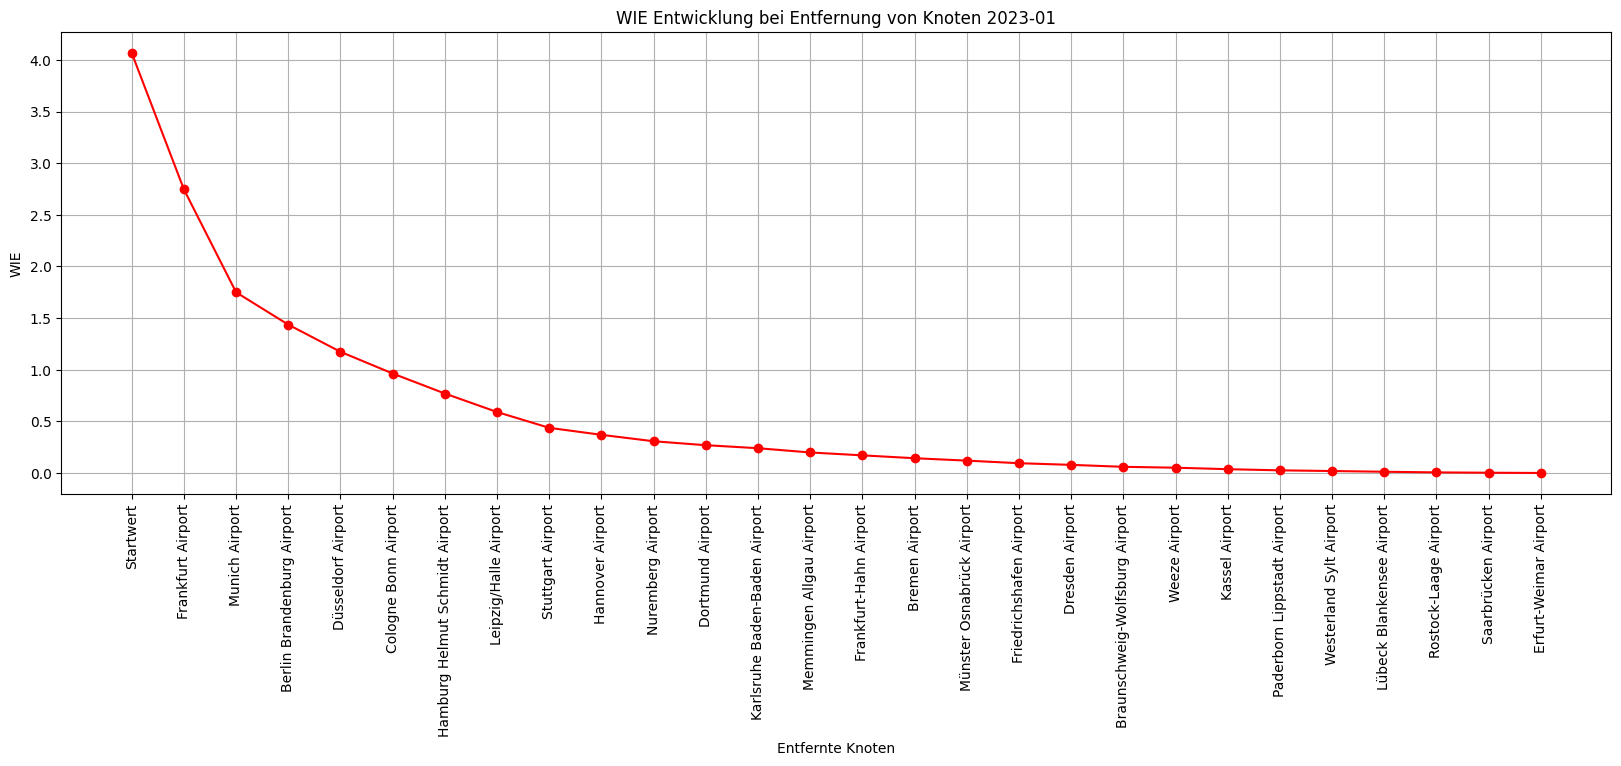

Number of nodes (airports): 857
Number of edges (flight routes): 5375, sum of weights (flights) 54932.0
Found 1249 international airports to check against
WIE_post has become zero.
International robustness for 2023-02: 0.734068607079928


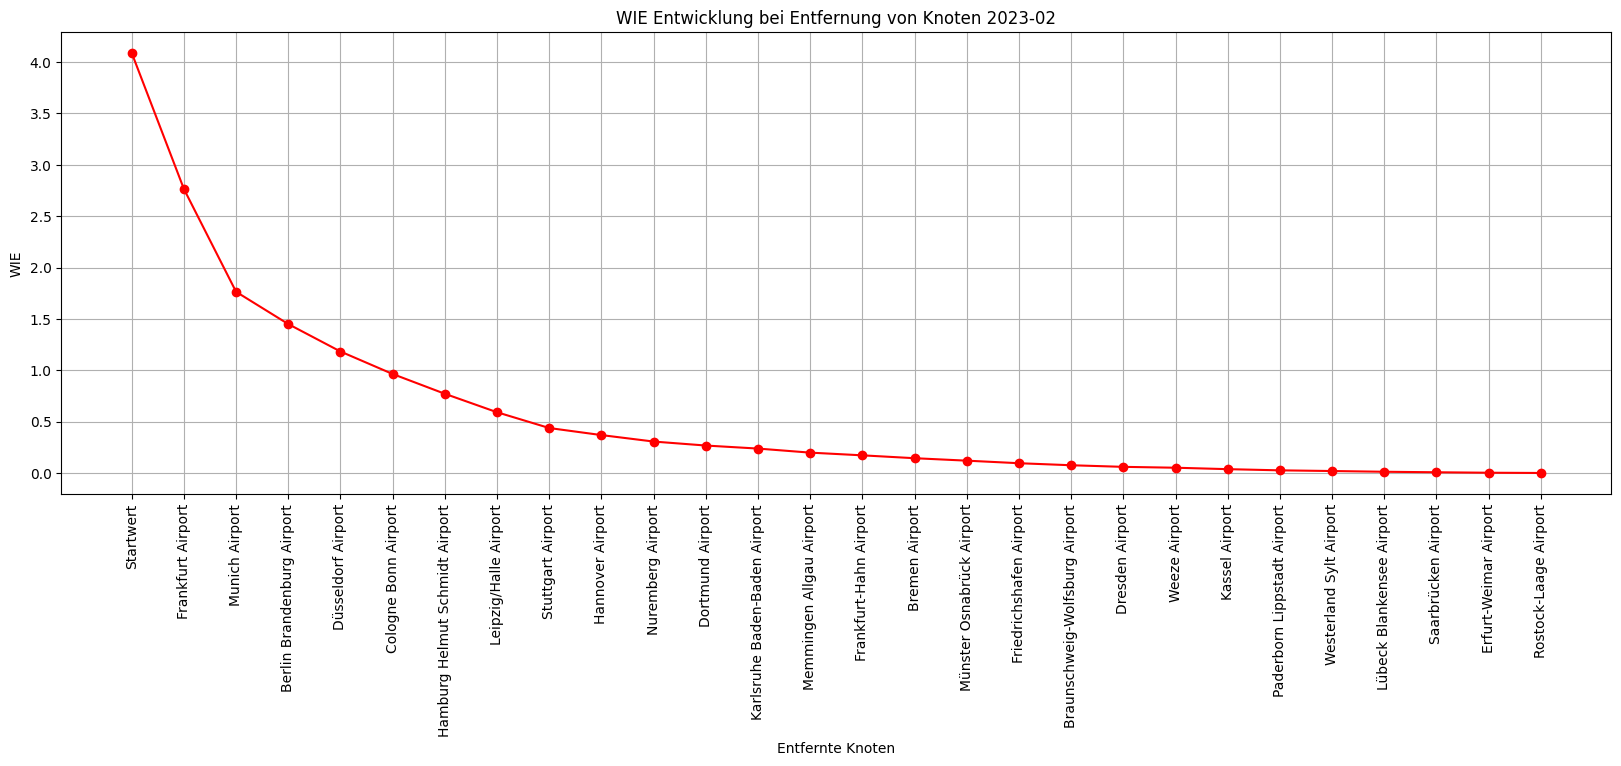

Number of nodes (airports): 938
Number of edges (flight routes): 5581, sum of weights (flights) 55409.0
Found 1249 international airports to check against
WIE_post has become zero.
International robustness for 2023-03: 0.7349337128510357


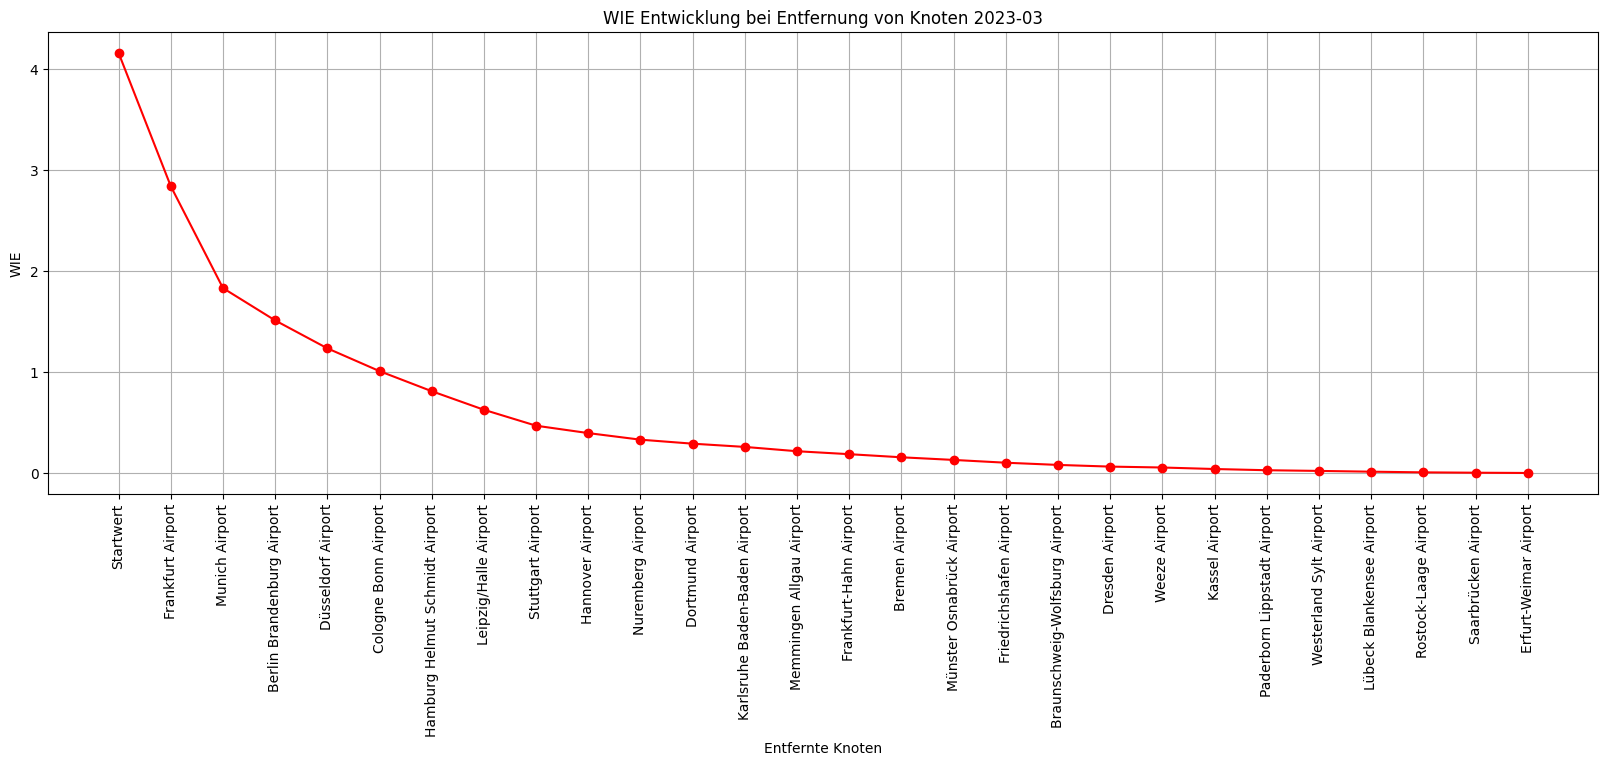

/content/drive/My Drive/2024KomplexeNetze/Daten/2023-04-01_2023-07-01_deutschland.csv
Number of nodes (airports): 1047
Number of edges (flight routes): 6935, sum of weights (flights) 66557.0
Found 1472 international airports to check against
WIE_post has become zero.
International robustness for 2023-04: 0.7377837341537519


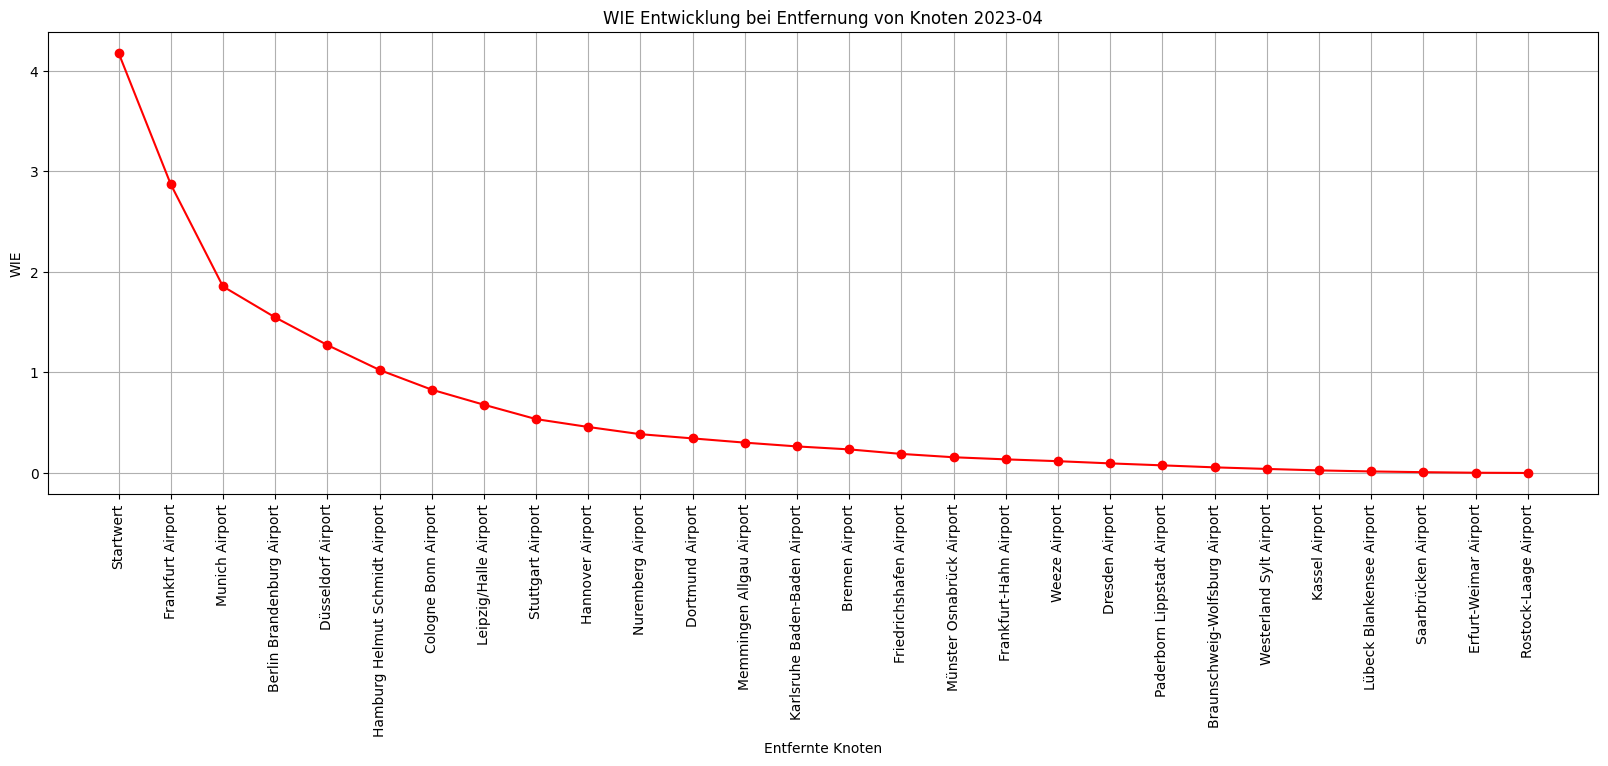

Number of nodes (airports): 1072
Number of edges (flight routes): 7078, sum of weights (flights) 67226.0
Found 1472 international airports to check against
WIE_post has become zero.
International robustness for 2023-05: 0.7386206316999133


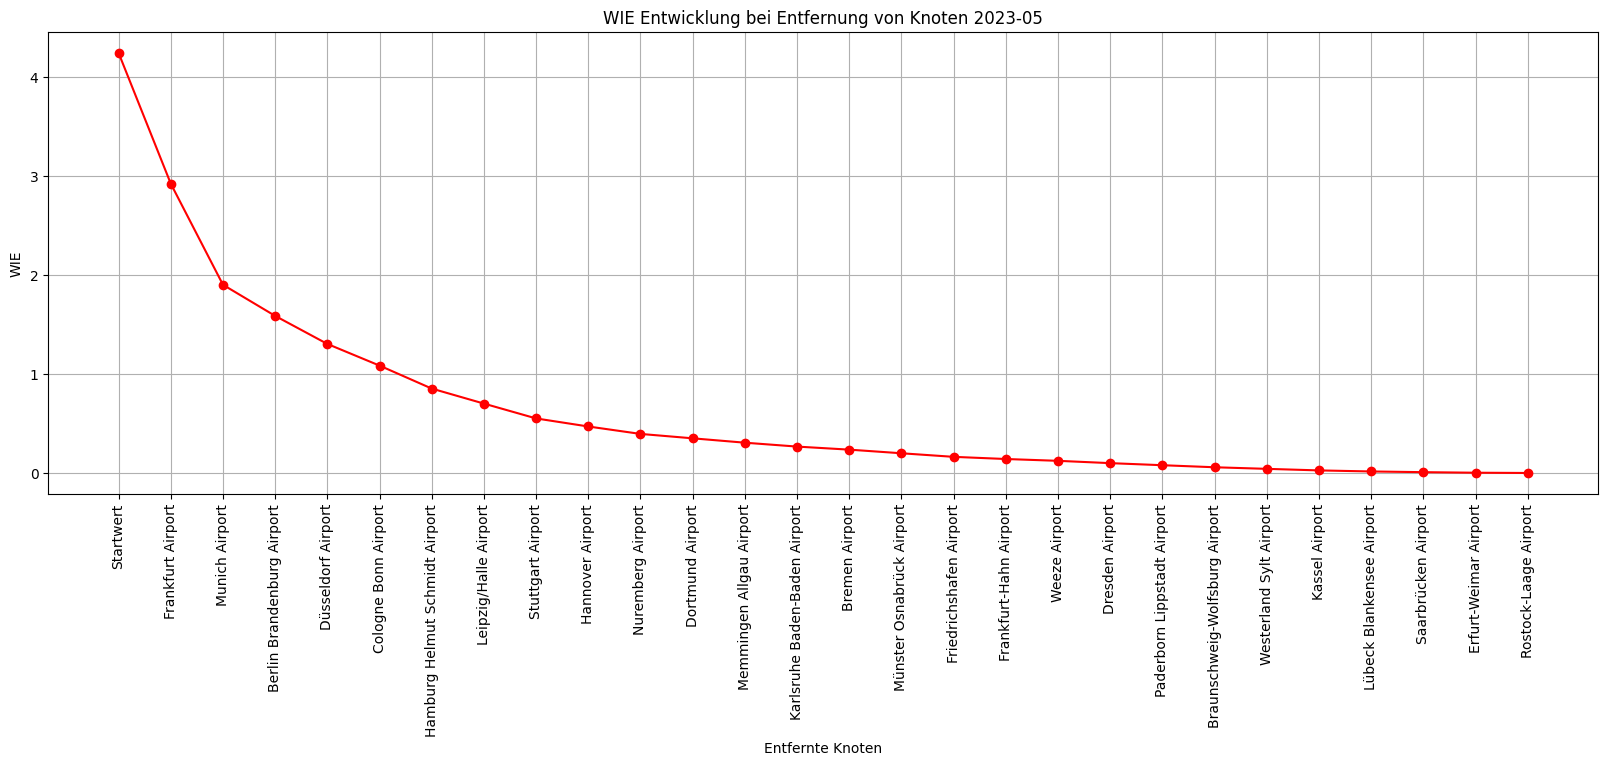

Number of nodes (airports): 1133
Number of edges (flight routes): 7161, sum of weights (flights) 67297.0
Found 1472 international airports to check against
WIE_post has become zero.
International robustness for 2023-06: 0.7376517944675555


/content/drive/My Drive/2024KomplexeNetze/Daten/2023-07-01_2023-10-01_deutschland.csv
Number of nodes (airports): 1115
Number of edges (flight routes): 7283, sum of weights (flights) 70290.0
Found 1476 international airports to check against
WIE_post has become zero.
International robustness for 2023-07: 0.740637710484843


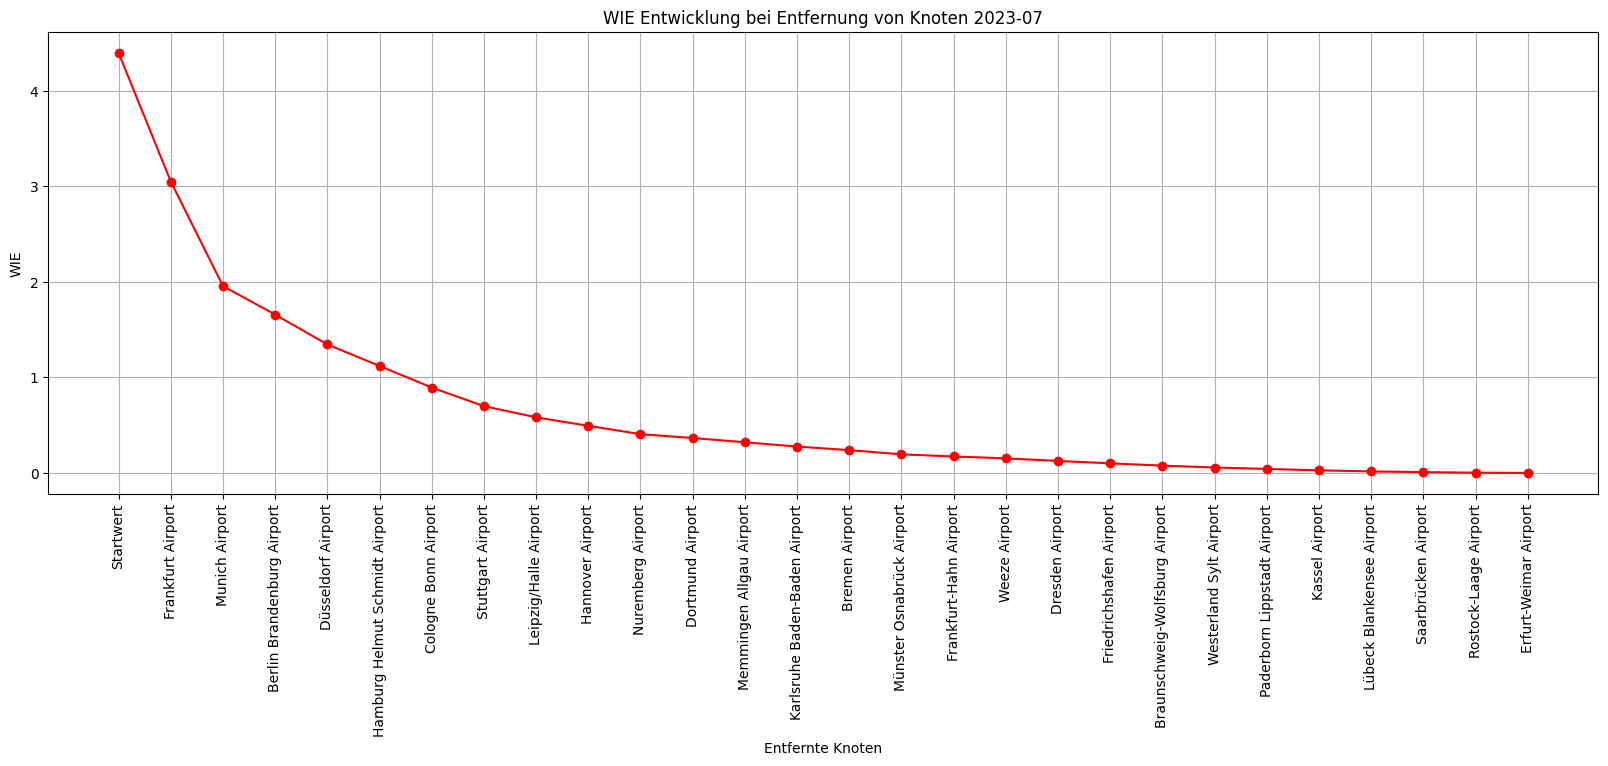

Number of nodes (airports): 1096
Number of edges (flight routes): 7279, sum of weights (flights) 70480.0
Found 1476 international airports to check against
WIE_post has become zero.
International robustness for 2023-08: 0.7401312423156855


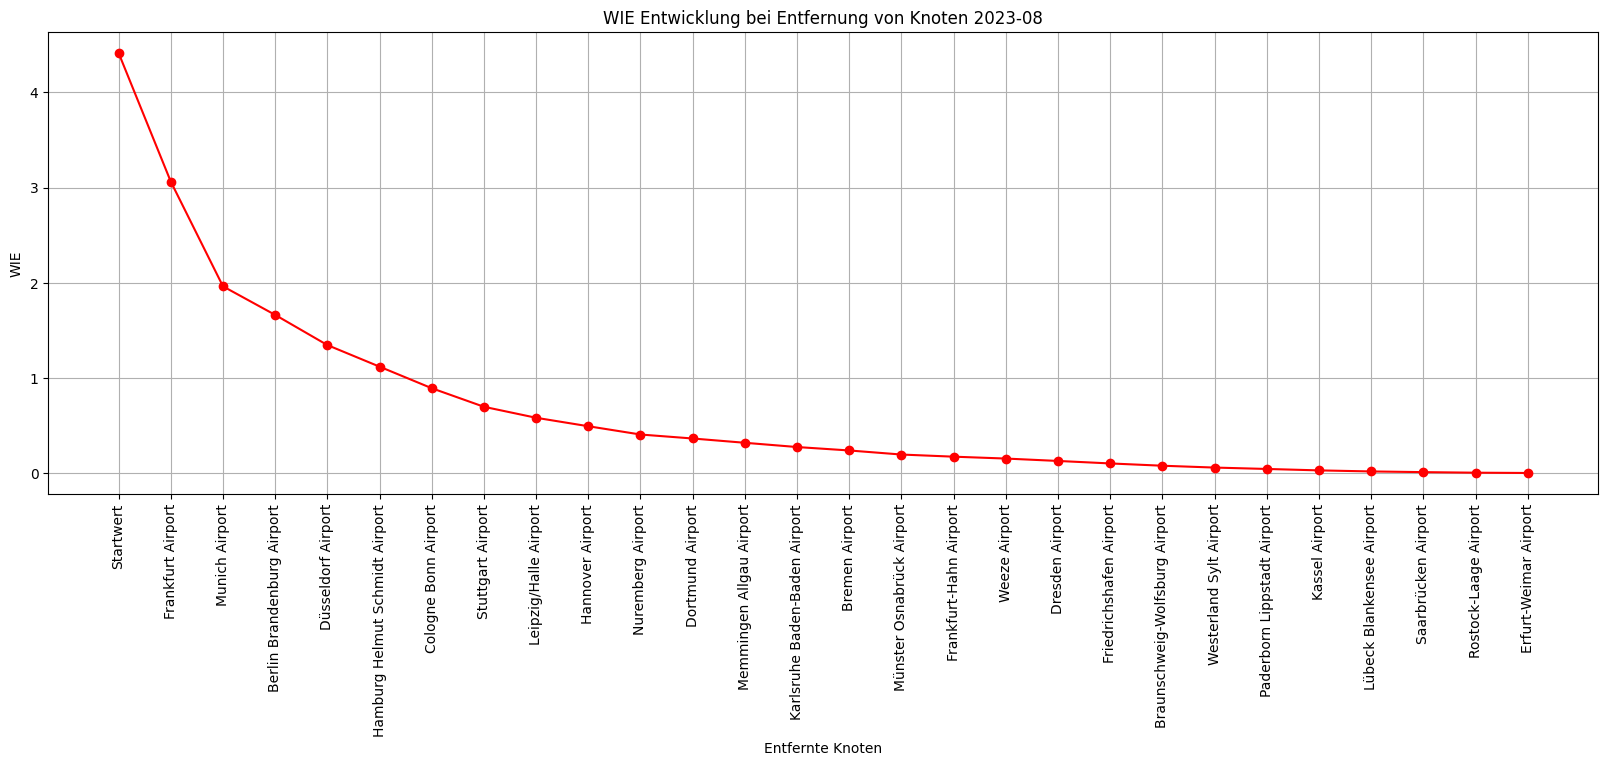

Number of nodes (airports): 1111
Number of edges (flight routes): 7276, sum of weights (flights) 70352.0
Found 1476 international airports to check against
WIE_post has become zero.
International robustness for 2023-09: 0.740593492920904


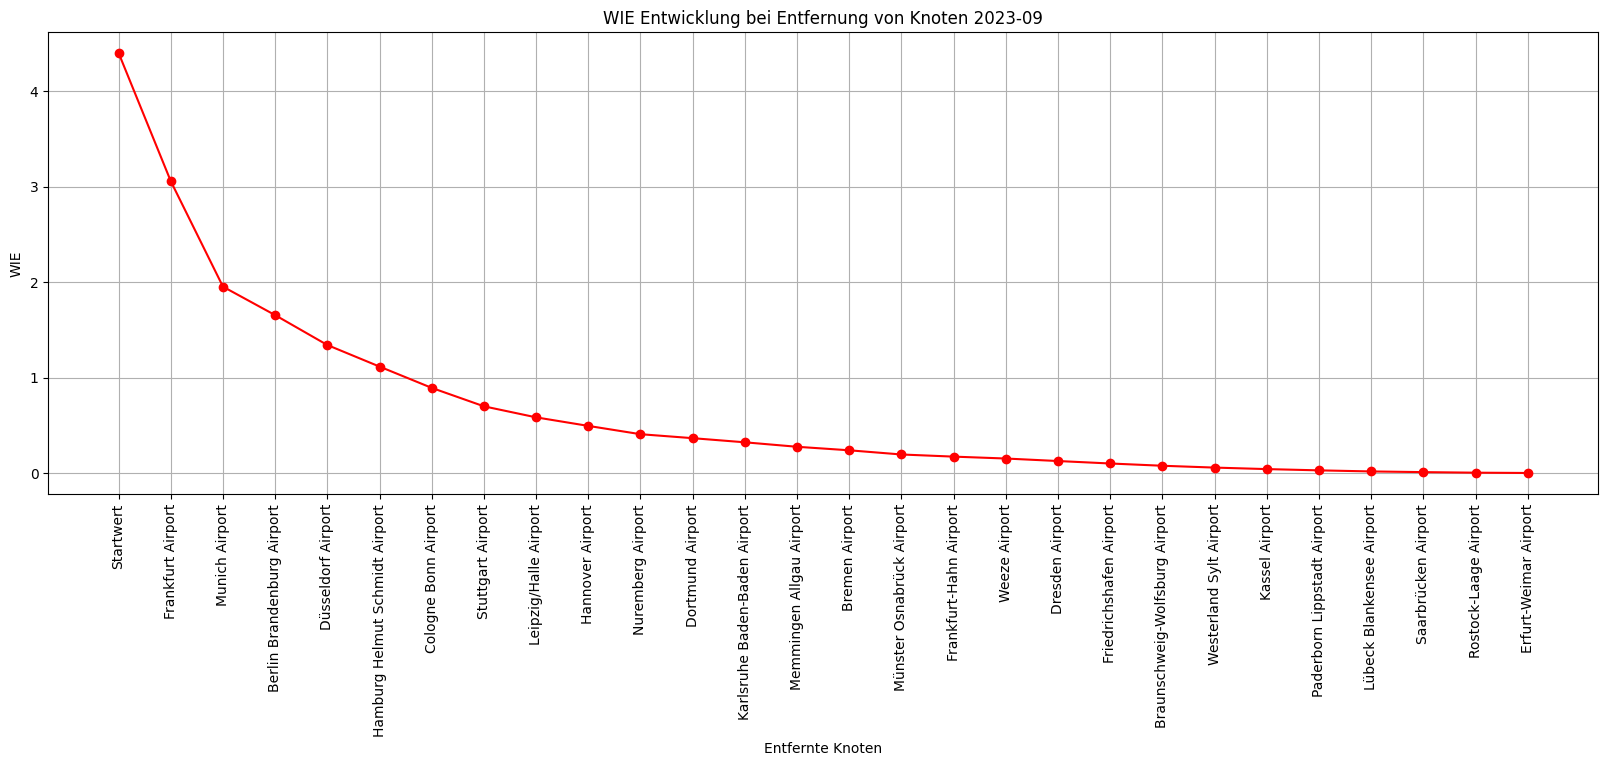

/content/drive/My Drive/2024KomplexeNetze/Daten/2023-10-01_2024-01-01_deutschland.csv
Number of nodes (airports): 1106
Number of edges (flight routes): 6096, sum of weights (flights) 49365.0
Found 1343 international airports to check against
WIE_post has become zero.
International robustness for 2023-10: 0.735020508992486


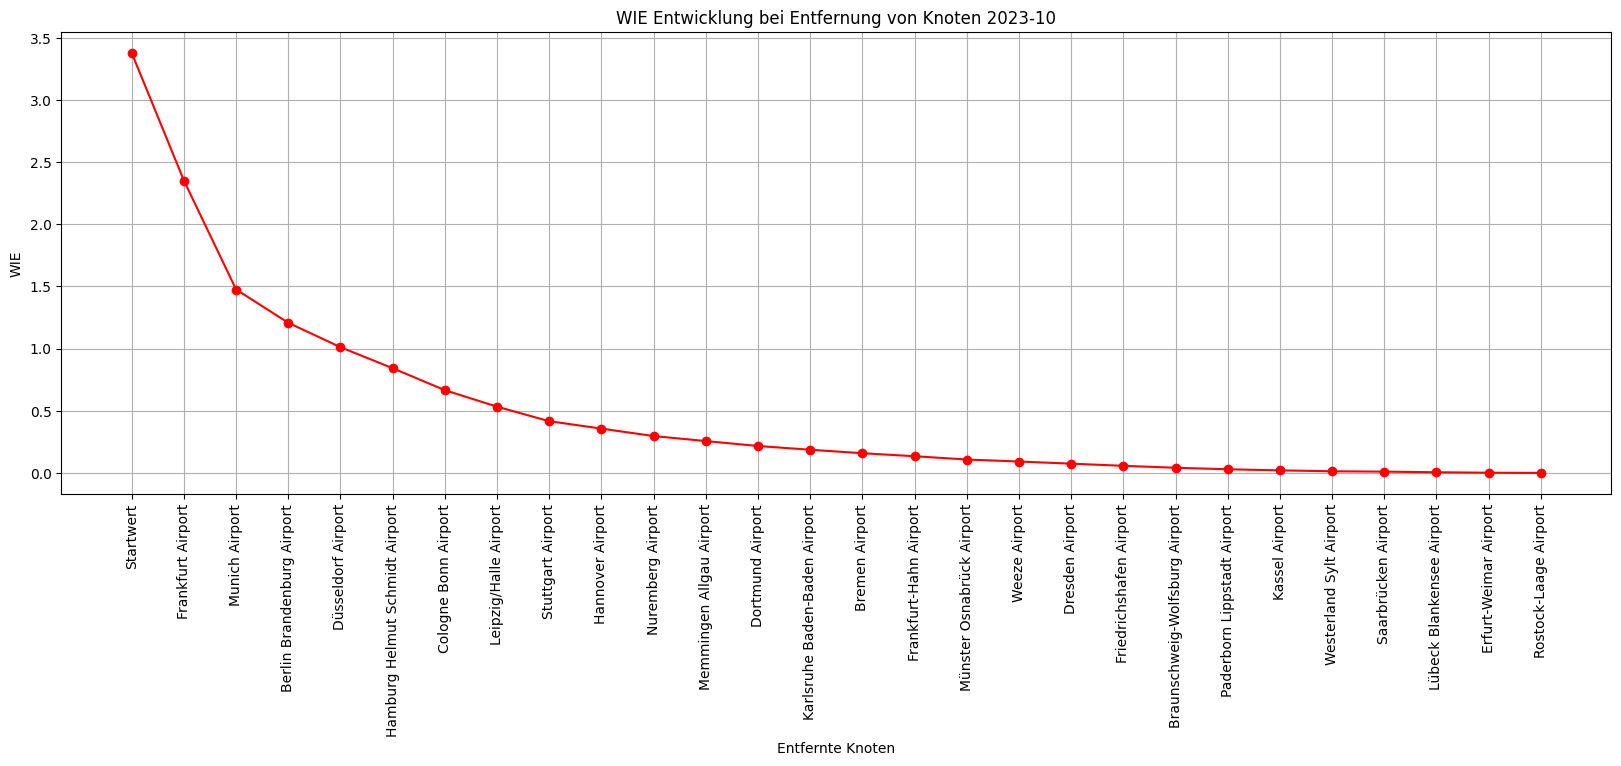

Number of nodes (airports): 889
Number of edges (flight routes): 5606, sum of weights (flights) 48298.0
Found 1343 international airports to check against
WIE_post has become zero.
International robustness for 2023-11: 0.7340805896253982


Number of nodes (airports): 811
Number of edges (flight routes): 5426, sum of weights (flights) 48082.0
Found 1343 international airports to check against
WIE_post has become zero.
International robustness for 2023-12: 0.7341883394743133


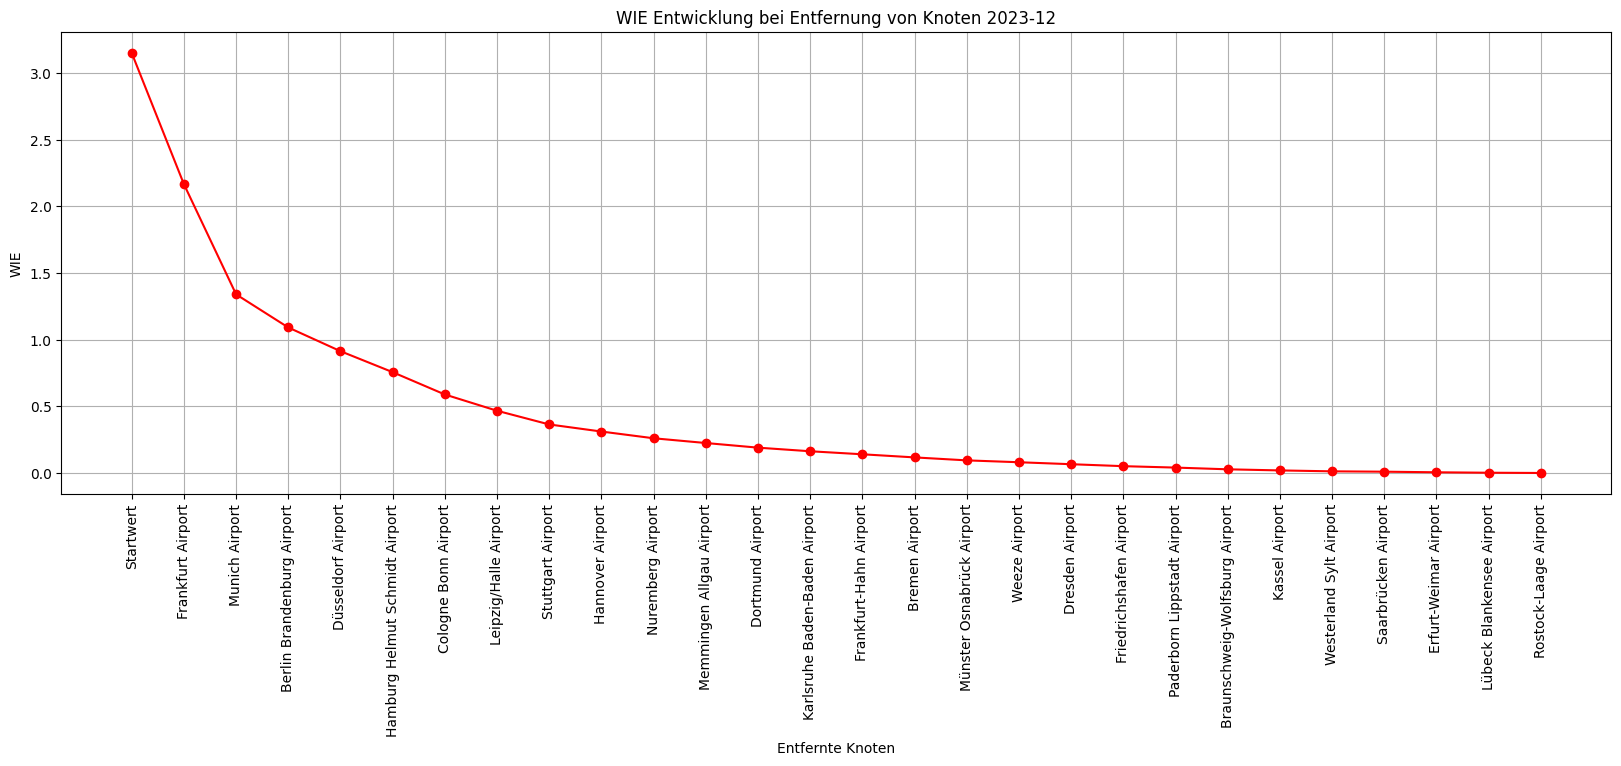

/content/drive/My Drive/2024KomplexeNetze/Daten/2024-01-01_2024-04-01_deutschland.csv
Number of nodes (airports): 889
Number of edges (flight routes): 5553, sum of weights (flights) 54583.0
Found 1299 international airports to check against
WIE_post has become zero.
International robustness for 2024-01: 0.7352064601443329


Number of nodes (airports): 905
Number of edges (flight routes): 5555, sum of weights (flights) 54644.0
Found 1299 international airports to check against
WIE_post has become zero.
International robustness for 2024-02: 0.7354154246523007


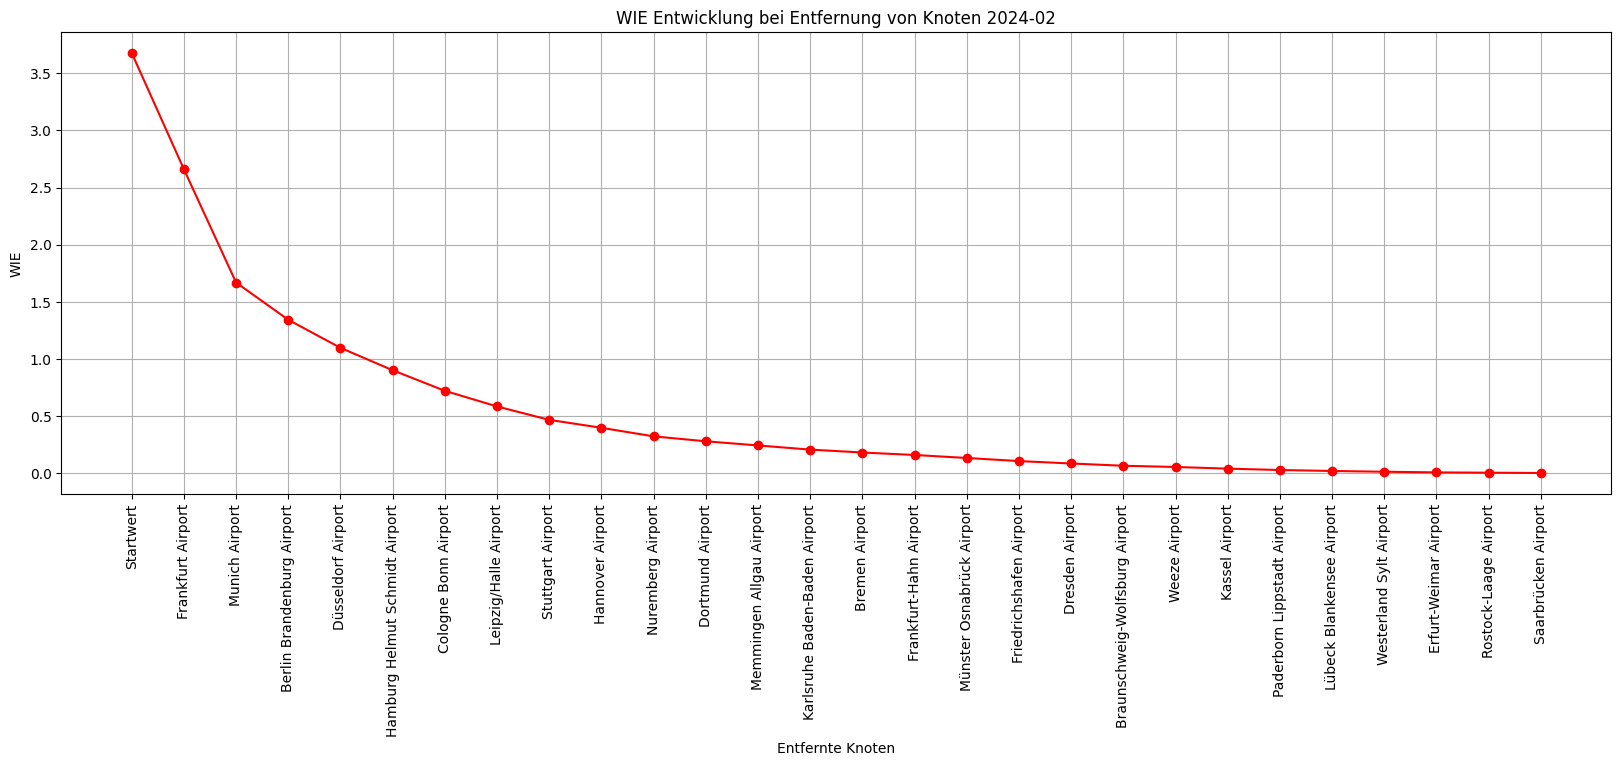

Number of nodes (airports): 994
Number of edges (flight routes): 5733, sum of weights (flights) 54892.0
Found 1299 international airports to check against
WIE_post has become zero.
International robustness for 2024-03: 0.7364077032905681


/content/drive/My Drive/2024KomplexeNetze/Daten/2024-04-01_2024-07-01_deutschland.csv
Number of nodes (airports): 1065
Number of edges (flight routes): 7002, sum of weights (flights) 65494.0
Found 1531 international airports to check against
WIE_post has become zero.
International robustness for 2024-04: 0.7462066754826142


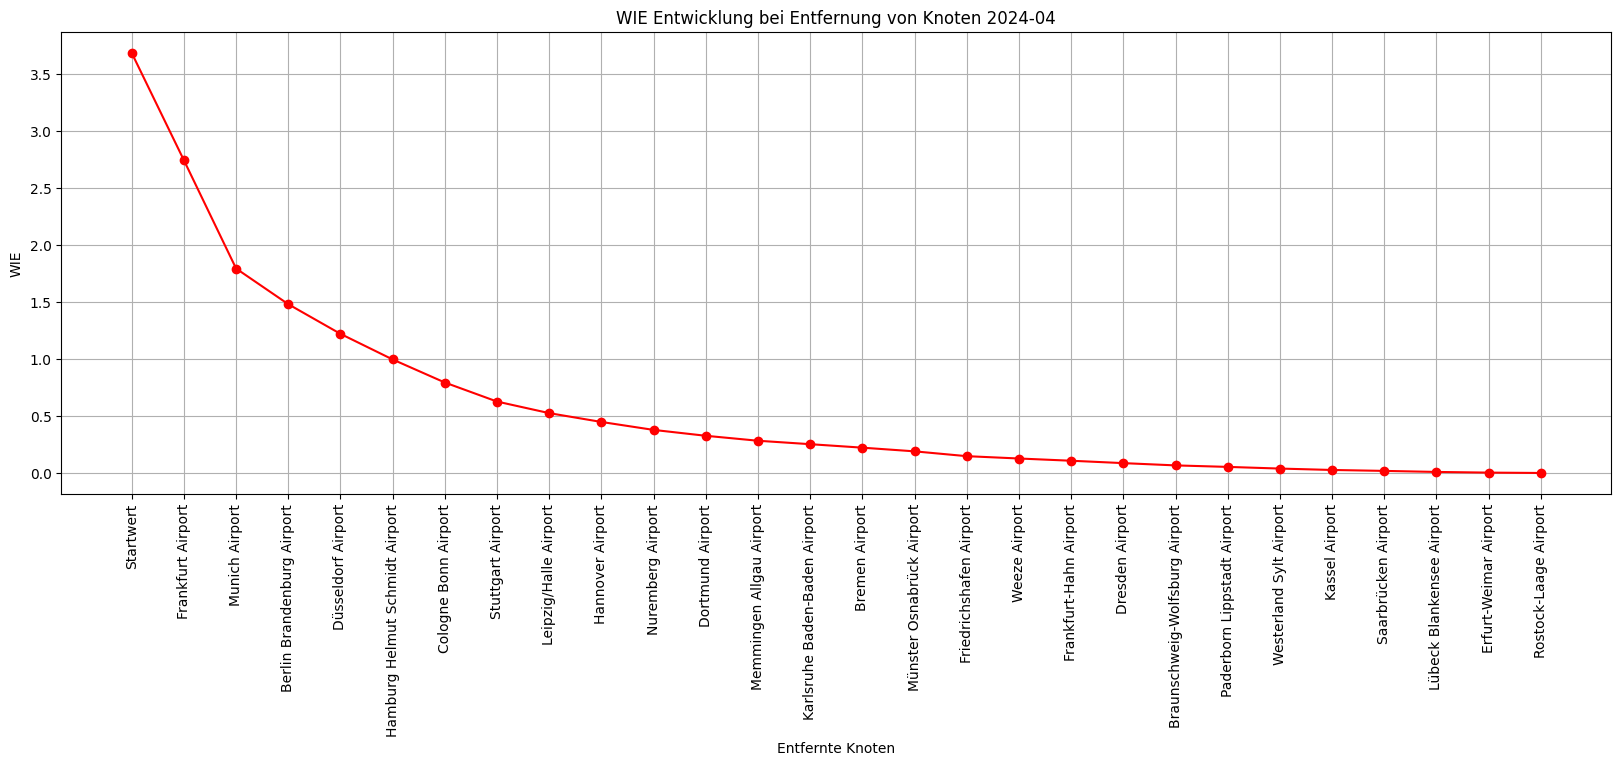

Number of nodes (airports): 1104
Number of edges (flight routes): 7179, sum of weights (flights) 66008.0
Found 1531 international airports to check against
WIE_post has become zero.
International robustness for 2024-05: 0.7462348998256642


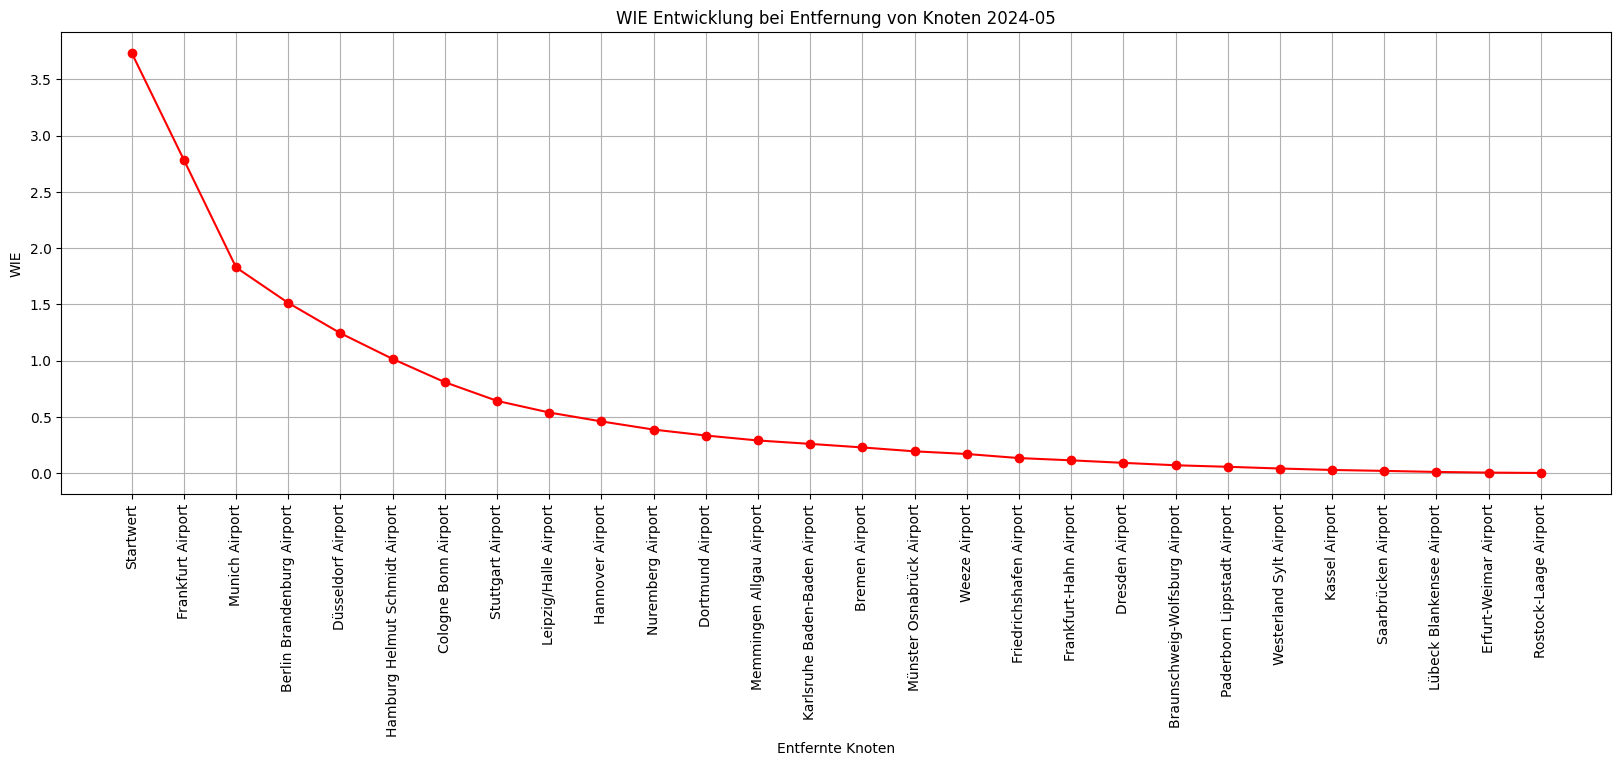

Number of nodes (airports): 1178
Number of edges (flight routes): 7347, sum of weights (flights) 66226.0
Found 1531 international airports to check against
WIE_post has become zero.
International robustness for 2024-06: 0.7450165590160351


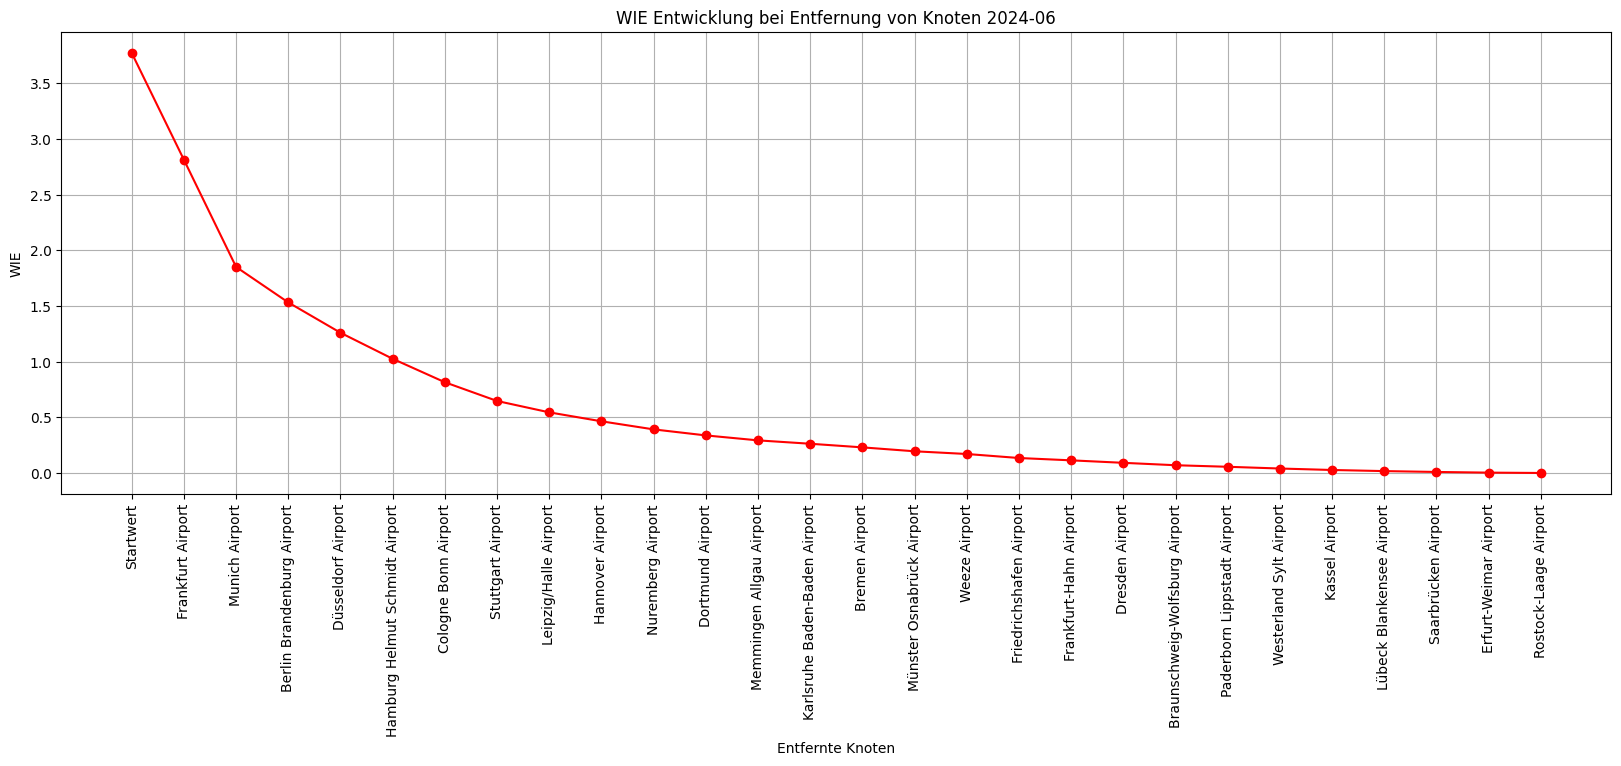

/content/drive/My Drive/2024KomplexeNetze/Daten/2024-07-01_2024-10-01_deutschland.csv
Number of nodes (airports): 1118
Number of edges (flight routes): 7293, sum of weights (flights) 72596.0
Found 1472 international airports to check against
WIE_post has become zero.
International robustness for 2024-07: 0.7477861671215097


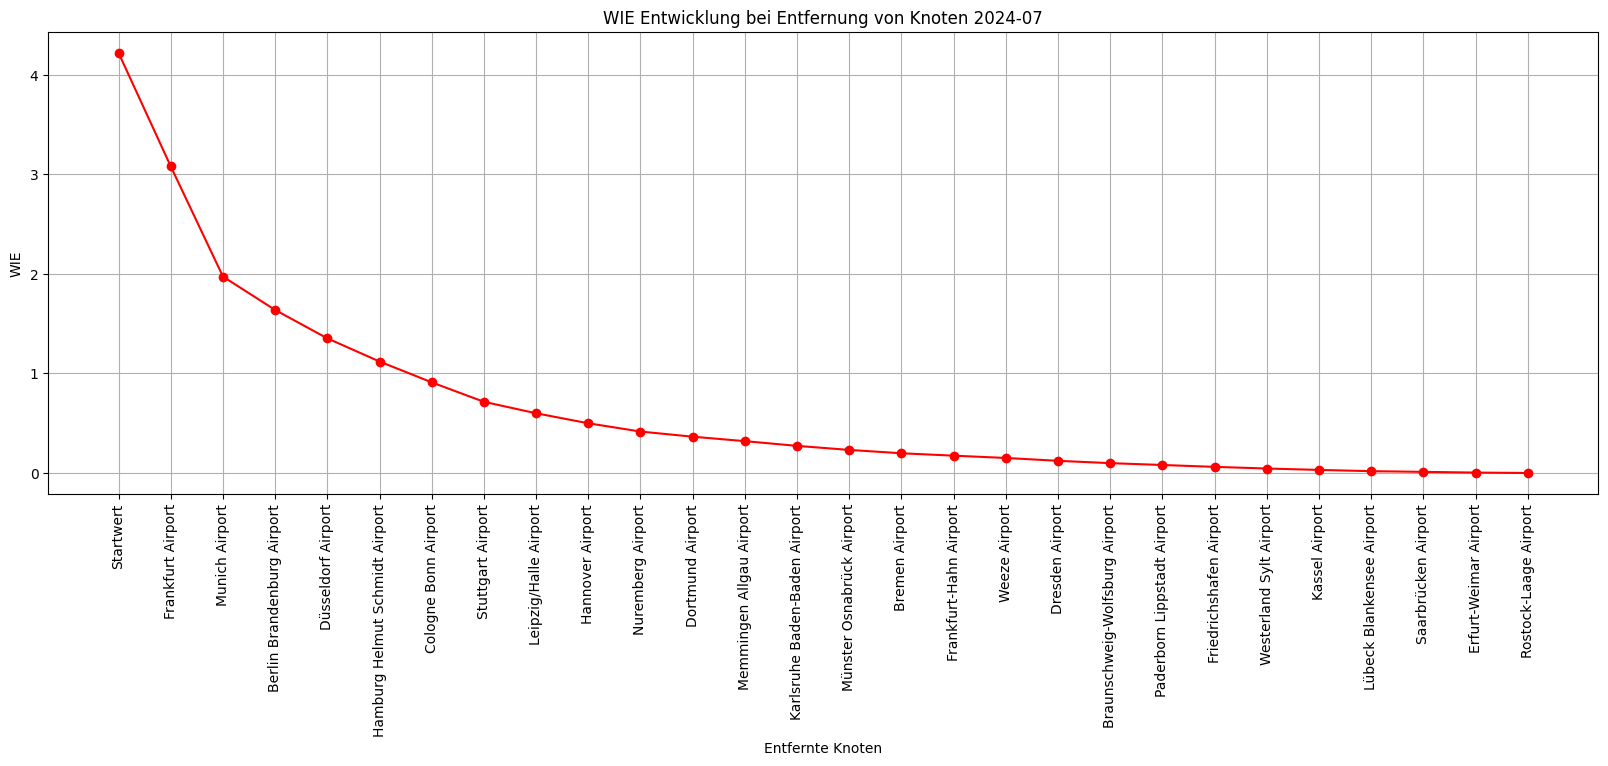

Number of nodes (airports): 1103
Number of edges (flight routes): 7273, sum of weights (flights) 72829.0
Found 1472 international airports to check against
WIE_post has become zero.
International robustness for 2024-08: 0.748055655386564


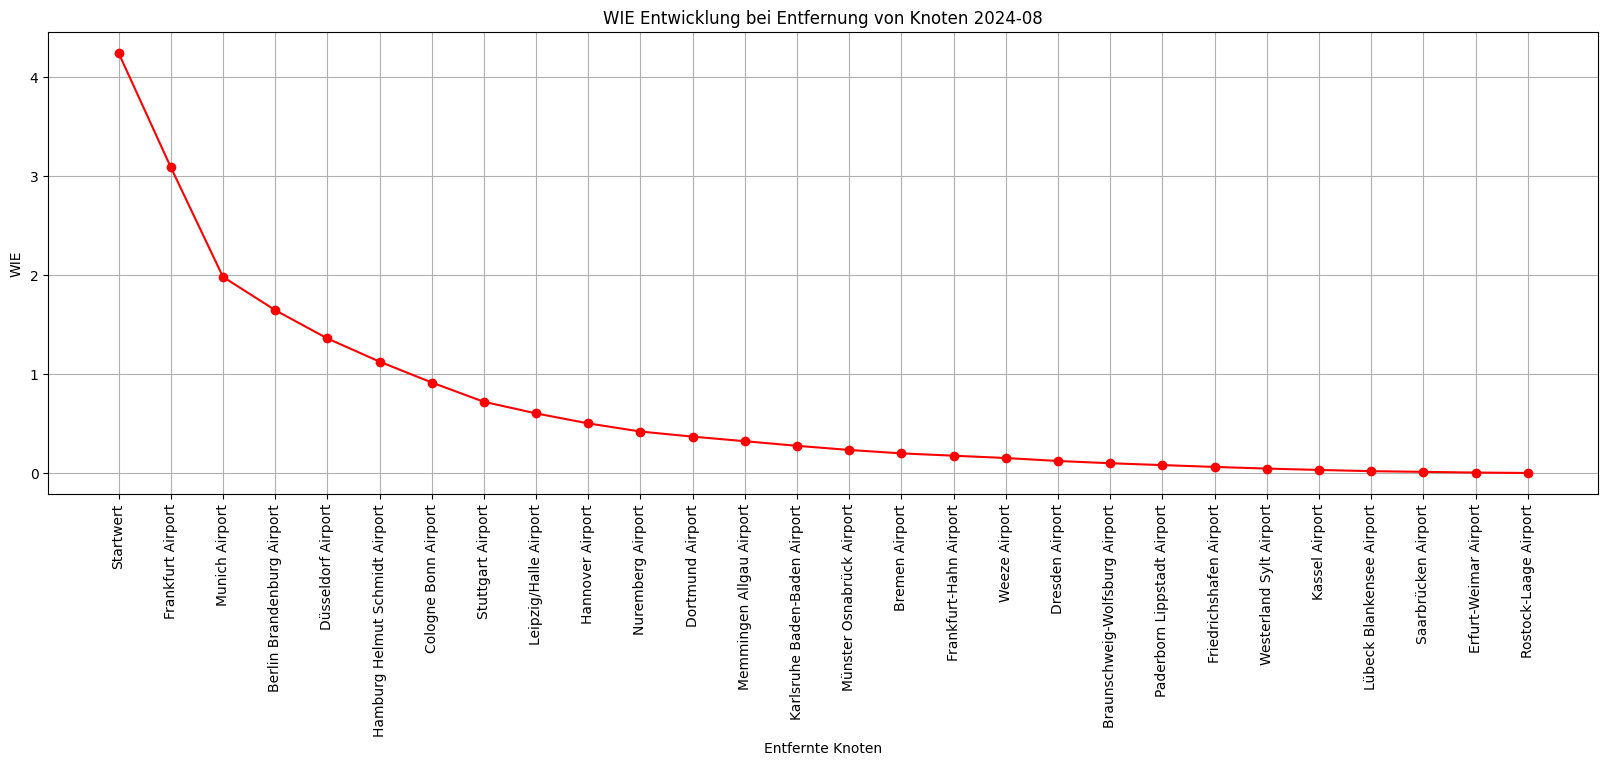

Number of nodes (airports): 1083
Number of edges (flight routes): 7214, sum of weights (flights) 72654.0
Found 1472 international airports to check against
WIE_post has become zero.
International robustness for 2024-09: 0.7473013591108288


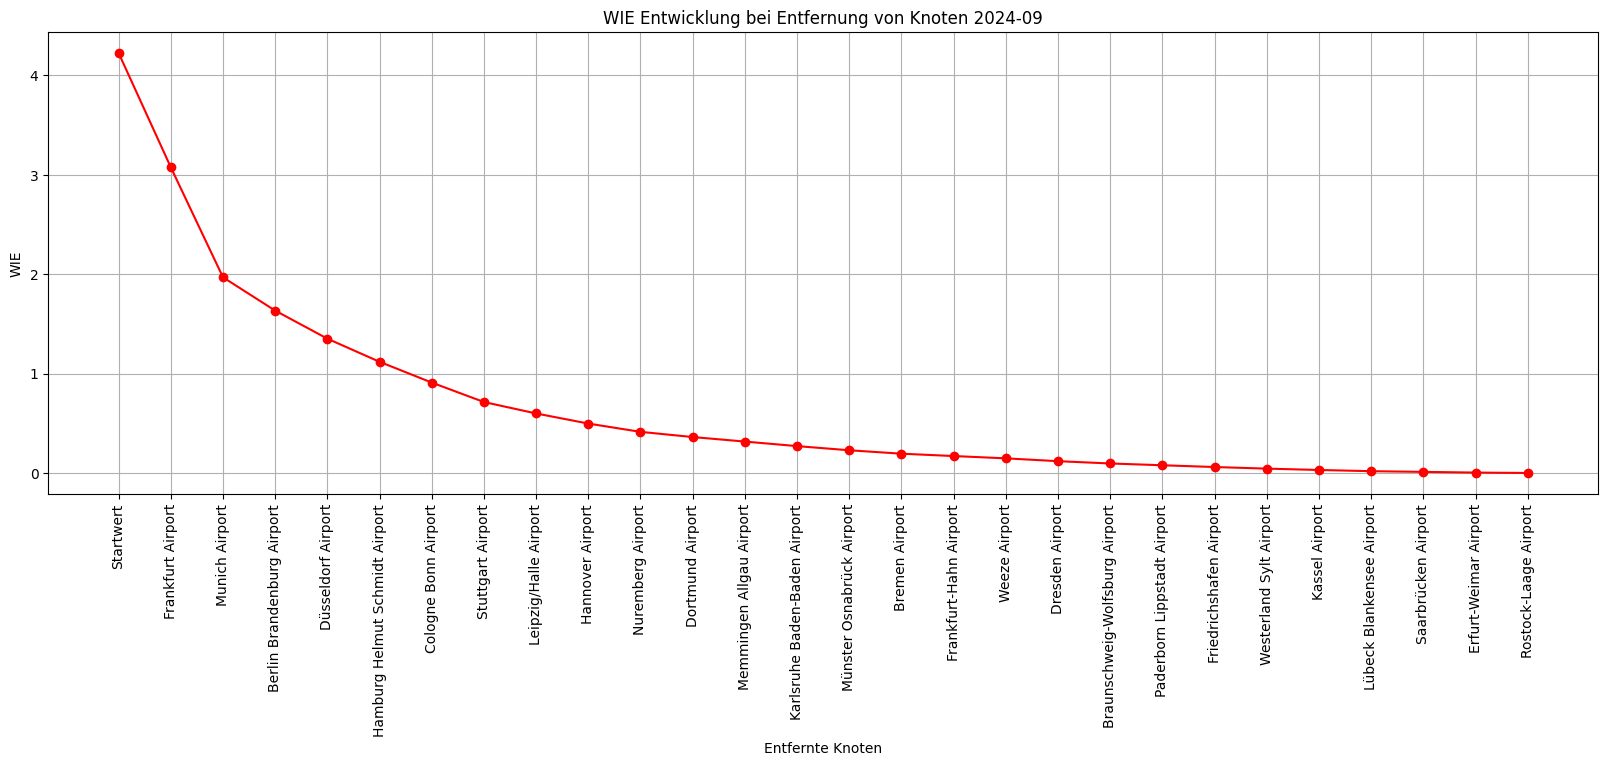

/content/drive/My Drive/2024KomplexeNetze/Daten/2024-10-01_2024-12-01_deutschland.csv
Number of nodes (airports): 1078
Number of edges (flight routes): 5597, sum of weights (flights) 57968.0
Found 1230 international airports to check against
WIE_post has become zero.
International robustness for 2024-10: 0.735488209779175


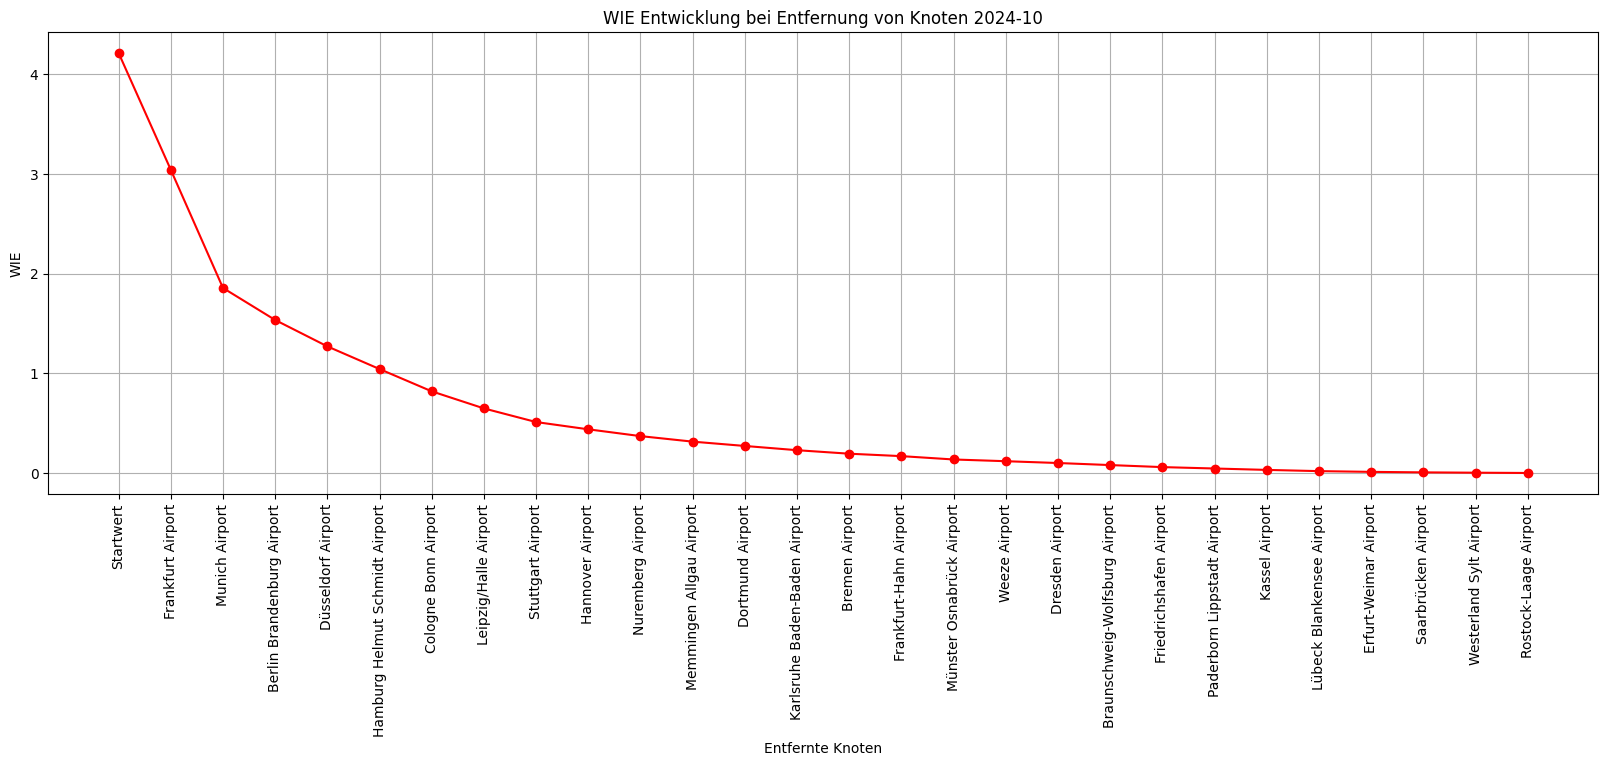

Number of nodes (airports): 901
Number of edges (flight routes): 5265, sum of weights (flights) 57333.0
Found 1230 international airports to check against
WIE_post has become zero.
International robustness for 2024-11: 0.7364392974507251


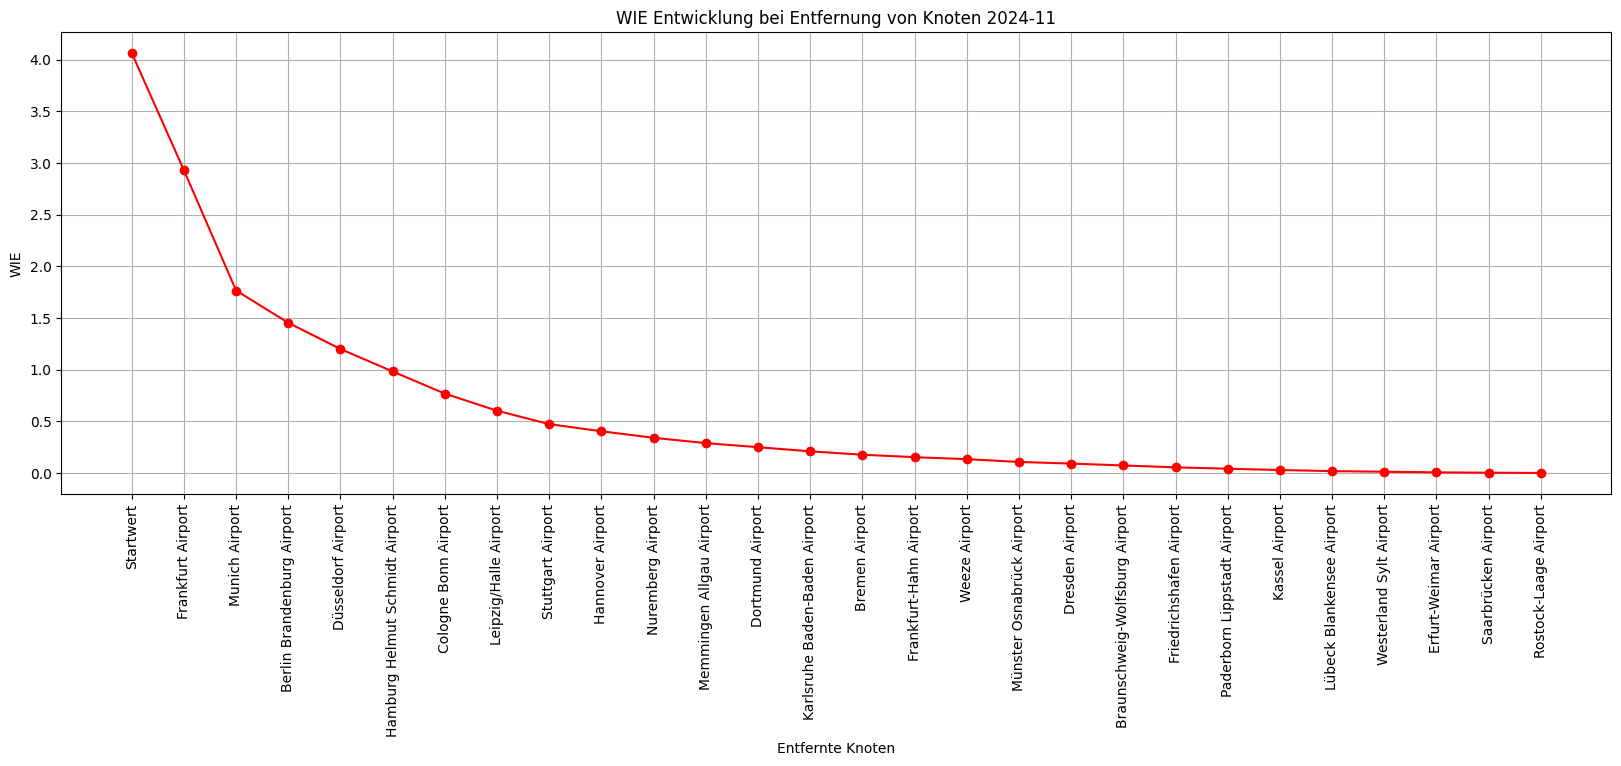

DataFrame saved to: /content/drive/My Drive/2024KomplexeNetze/Ergebnisse/ir_deutschland_20241229_195317.csv


In [11]:
# Get the current date and time
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

# Initialize lists to store WIE and IR values for each year
wie_2019 = []
wie_2018 = []
wie_2023 = []
wie_2024 = []
ir_2019 = []
ir_2018 = []
ir_2023 = []
ir_2024 = []
ieflight_2019 = []
ieflight_2018 = []
ieflight_2023 = []
ieflight_2024 = []
neroute_2019 = []
neroute_2018 = []
neroute_2023 = []
neroute_2024 = []
months_2019 = []
months_2018 = []
months_2023 = []
months_2024 = []

for csv_file in csv_files:

  flightdata = pd.read_csv(csv_file, parse_dates=["firstseen", "lastseen", "day"])
  print(csv_file)


  #flightdata.head()
  #flightdata.describe()
  #nan_percentage = (flightdata.isna().sum() / len(flightdata)) * 100
  #print(nan_percentage)
  flightdata.dropna(inplace=True)
#  flightdata.describe()

  #departure_counts = flightdata['departure'].value_counts()
  #eddm_count = departure_counts.get('EDDM', 0)
  #eddf_count = departure_counts.get('EDDF', 0)
  #print(f"at the start: The departure value 'EDDF' appears {eddf_count} times, and EDDM {eddm_count} times.")

  flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="departure", right_on="icao", how="left", )
  flightdata = flightdata.rename(columns={"municipality": "departure_city"})
  flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="arrival", right_on="icao", how="left", )
  flightdata = flightdata.rename(columns={"municipality": "arrival_city"})

  # add a column to flightdata dataframe with contains week-and-year
  flightdata['week_and_year'] = flightdata['day'].dt.strftime('%Y-%U')
  #flightdata.tail()

  # add a column to flightdata dataframe with contains month-and-year
  flightdata['month_and_year'] = flightdata['day'].dt.strftime('%Y-%m')
  #flightdata.tail()

  # query dataframe for everything starting/ending at one of the selected airports
  #flightdata = flightdata[flightdata['departure'].isin(icaolist) | flightdata['arrival'].isin(icaolist)]
  flightdata = flightdata[flightdata['departure'].isin(icaolist)]

  # analyse the data by month
  for month_year in flightdata['month_and_year'].unique():
    # Filter the flightdata for the chosen year_month
    filtered_flightdata = flightdata[flightdata['month_and_year'] == month_year]
    #departure_counts = filtered_flightdata['departure'].value_counts()
    #eddm_count = departure_counts.get('EDDM', 0)
    #eddf_count = departure_counts.get('EDDF', 0)
    #print(f"after selecting {month_year}: The departure value 'EDDF' appears {eddf_count} times, and EDDM {eddm_count} times.")

    # Create a directed graph
    #    trafficgraph = nx.DiGraph()
    weightedgraph = nx.DiGraph()

    # Part 1: Add nodes from the flights data
    for index, row in filtered_flightdata.iterrows():
        origin = row['departure']
        destination = row['arrival']

        # Add the origin and destination as nodes if they don't exist (and are not identical)
        if origin != destination:
          if origin not in weightedgraph:
              weightedgraph.add_node(origin)
          if destination not in weightedgraph:
              weightedgraph.add_node(destination)


    print("Number of nodes (airports):", weightedgraph.number_of_nodes())

    # Part 2: Add weighted edges from the flights data

    # Group flights by origin, destination, and day to count weekly connections
    #weekly_connections = flightdata.groupby(['departure', 'arrival', 'week_and_year']).size().reset_index(name='connections')
    #print(weekly_connections.tail())
    #average_connections = weekly_connections.groupby(['departure', 'arrival'])['connections'].mean().reset_index()
    #print(average_connections.tail())

    # Group flights by origin, destination, and day to count monthly connections
    monthly_connections = flightdata.groupby(['departure', 'arrival', 'month_and_year']).size().reset_index(name='connections')
    #print(monthly_connections.head())

    # Calculate the average connections for each departure-arrival combination
    #average_connections = monthly_connections.groupby(['departure', 'arrival'])['connections'].mean().reset_index()
    #print(average_connections.tail())

    # Add weighted edges based on average connections
    for index, row in monthly_connections.iterrows():
      if row['departure'] != row['arrival']:
        origin = row['departure']
        destination = row['arrival']
        weight = row['connections']

        # Add the edge with the calculated weight
        if origin in weightedgraph and destination in weightedgraph:
            weightedgraph.add_edge(origin, destination, weight=weight)

    nflights= weightedgraph.size(weight="weight")
    nroutes=weightedgraph.number_of_edges()
    print(f"Number of edges (flight routes): {nroutes}, sum of weights (flights) {nflights}" )
    #print(list(weightedgraph.degree(['EDDF','EDDM'], weight="weight")))

    international_list = flightdata[~flightdata['arrival'].isin(icaolist)]['arrival'].unique()
    print (f'Found {len(international_list)} international airports to check against')

    domestic_departure_graph = weightedgraph.copy()
#    domestic_departure_graph = nx.DiGraph()
#    for u, v, data in weightedgraph.edges(data=True):
#      if u in icaolist:
#        domestic_departure_graph.add_edge(u, v, **data) # Keep the edge data/weight
#    print("Number of edges (flights) in domestic graph:", domestic_departure_graph.number_of_edges())


#    ddd = dict(domestic_departure_graph.degree(weight='weight'))
#    nx.draw(domestic_departure_graph.degree, pos=nx.spring_layout(domestic_departure_graph), nodelist=ddd.keys(), node_size=[(1+nv) * 100 for nv in ddd.values()])
#    plt.show()

    # Extract year and month
    year, month = map(int, month_year.split('-'))

    # Let's see what the WIE is
    # While doing that, calculate the ratio of post- and pre- WIEs.
    modified_graph = domestic_departure_graph.copy()
    sum_ratio = 0
    WIE_pre = analyze_graph_WIE(modified_graph.copy())
    if year == 2019:
      wie_2019.append(WIE_pre)
      months_2019.append(f'{month:02}')
    elif year == 2018:
      wie_2018.append(WIE_pre)
      months_2018.append(f'{month:02}')
    elif year == 2023:
      wie_2023.append(WIE_pre)
      months_2023.append(f'{month:02}')
    elif year == 2024:
      wie_2024.append(WIE_pre)
      months_2024.append(f'{month:02}')

    ratio_values = []
    removed_nodes = []
    ratio_values.append(WIE_pre)
    removed_nodes.append("Startwert")
    while True and WIE_pre > 0:
        nodes_in_icaolist = [node for node in modified_graph.nodes if node in icaolist]
        if not nodes_in_icaolist:
            break
        modified_graph, removed_node = remove_highest_degree_node(modified_graph, icaolist)
        WIE_post=analyze_graph_WIE(modified_graph.copy())
        ratio = WIE_post/WIE_pre
        if WIE_post == 0:
            print("WIE_post has become zero.")
        WIE_pre = WIE_post
        sum_ratio += ratio
        ratio_values.append(WIE_post)
        #print(f"removed node: {removed_node}, WIE_pre: {WIE_pre}, WIE_post: {WIE_post}, ratio: {ratio}")
        removed_nodes.append(airports[removed_node].name)
        #removed_nodes.append(removed_node)

    ir = sum_ratio / len(icaolist)
    if year == 2019:
      ir_2019.append(ir)
      ieflight_2019.append(nflights)
      neroute_2019.append(nroutes)
    elif year == 2018:
      ir_2018.append(ir)
      ieflight_2018.append(nflights)
      neroute_2018.append(nroutes)
    elif year == 2023:
      ir_2023.append(ir)
      ieflight_2023.append(nflights)
      neroute_2023.append(nroutes)
    elif year == 2024:
      ir_2024.append(ir)
      ieflight_2024.append(nflights)
      neroute_2024.append(nroutes)
#      ieflight_2024.append(weightedgraph.number_of_edges())
#      neroute_2024.append(domestic_departure_graph.number_of_edges())
    print(f"International robustness for {month_year}: {ir}")


    # Plotting after the loops
    fig = fig = plt.figure(figsize=(20, 6))
    #plt.plot(range(1, len(ratio_values) + 1), ratio_values, marker='o', linestyle='-')
    #plt.xlabel('Loop Iteration')
    #plt.title('WIE Value vs. Loop Iteration')
    plt.plot(removed_nodes, ratio_values, markerToUse,  color=colorToUse)
    plt.xlabel('Entfernte Knoten')
    plt.xticks(rotation=90)
    plt.title(f'WIE Entwicklung bei Entfernung von Knoten {month_year}')
    plt.ylabel('WIE')
    plt.grid(True)
    resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/wieloop_{year}_{month}_{countryname}_{timestamp}.png"
    plt.savefig(resultfilename, bbox_inches=Bbox([[0,-3],fig.get_size_inches()]))
    resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/wieloop_{year}_{month}_{countryname}_{timestamp}.svg"
    plt.savefig(resultfilename, bbox_inches=Bbox([[0,-3],fig.get_size_inches()]))
    plt.show()


    # hack to make up for the fact that I don't include 2024 december data yet, but matplotplib wants same-length-lists
    if year == 2024 and month == 11:
      wie_2024.append(-1)
      ir_2024.append(-1)
      ieflight_2024.append(-1)
      neroute_2024.append(-1)
      months_2024.append(f'12')


    # Create a DataFrame for the current month_year
    df_current_month = pd.DataFrame({
        'month': [month] * len(ratio_values),
        'year': [year] * len(ratio_values),
        'removed_nodes': removed_nodes,
        'ratio_values': ratio_values
    })

    # Concatenate the current month's DataFrame with the existing DataFrame (if it exists)
    if 'df_all_months' not in locals():
        df_all_months = df_current_month
    else:
        df_all_months = pd.concat([df_all_months, df_current_month], ignore_index=True)



# When the loop is done, save the dataframe with all the WIE-steps to a CSV file in Google Drive
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/wie_{countryname}_{timestamp}.csv"
df_all_months.to_csv(resultfilename, index=False)
print(f"DataFrame saved to: {resultfilename}")

-------------------------
Export the results

In [17]:
# Create a list to store all dataframes for each year
dfs = []

# Iterate through the years
for year in [2018, 2019, 2023, 2024]:
    # Create a dictionary to hold data for the current year
    year_data = {
        'Month': [],
        'WIE': [],
        'IR': [],
        'ieflight': [],
        'neroute': []
    }

    # Assign the correct month list and data lists for the year
    if year == 2018:
        months = months_2018
        wie = wie_2018
        ir = ir_2018
        ieflight = ieflight_2018
        neroute = neroute_2018
    elif year == 2019:
        months = months_2019
        wie = wie_2019
        ir = ir_2019
        ieflight = ieflight_2019
        neroute = neroute_2019
    elif year == 2023:
        months = months_2023
        wie = wie_2023
        ir = ir_2023
        ieflight = ieflight_2023
        neroute = neroute_2023
    elif year == 2024:
        months = months_2024
        wie = wie_2024
        ir = ir_2024
        ieflight = ieflight_2024
        neroute = neroute_2024
    else:
        continue

    # print the lengths of the different lists
    print(f"months: {len(months)}, wie: {len(wie)}, ir: {len(ir)}, ieflight: {len(ieflight)}, neroute: {len(neroute)}")
    print(months)
    print(ieflight)

    # Populate the year_data dictionary
    year_data['Month'] = months
    year_data['WIE'] = wie
    year_data['IR'] = ir
    year_data['ieflight'] = ieflight
    year_data['neroute'] = neroute

    # Create a dataframe for the current year
    df_year = pd.DataFrame(year_data)
    df_year['Year'] = year  # Add a 'Year' column

    #Append the year's dataframe to the list
    dfs.append(df_year)


# Concatenate all dataframes into a single dataframe
dfresult = pd.concat(dfs, ignore_index=True)

# Define the filename with the timestamp
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/ir_{countryname}_{timestamp}.csv"

# Save the result dataframe to a CSV file in Google Drive
dfresult.to_csv(resultfilename, index=False)
print(f"DataFrame saved to: {resultfilename}")


months: 12, wie: 12, ir: 12, ieflight: 12, neroute: 12
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
[47461.0, 47451.0, 47453.0, 49851.0, 54218.0, 54201.0, 51929.0, 52368.0, 51976.0, 49215.0, 48709.0, 48628.0]
months: 12, wie: 12, ir: 12, ieflight: 12, neroute: 12
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
[54488.0, 54683.0, 54866.0, 59049.0, 59897.0, 59902.0, 65897.0, 66071.0, 66182.0, 57585.0, 57086.0, 57017.0]
months: 12, wie: 12, ir: 12, ieflight: 12, neroute: 12
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
[54852.0, 54932.0, 55409.0, 66557.0, 67226.0, 67297.0, 70290.0, 70480.0, 70352.0, 49365.0, 48298.0, 48082.0]
months: 12, wie: 12, ir: 12, ieflight: 12, neroute: 12
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
[54583.0, 54644.0, 54892.0, 65494.0, 66008.0, 66226.0, 72596.0, 72829.0, 72654.0, 57968.0, 57333.0, -1]
DataFrame saved to: /content/drive/My Drive/2024KomplexeN

Now make some plots of the reults

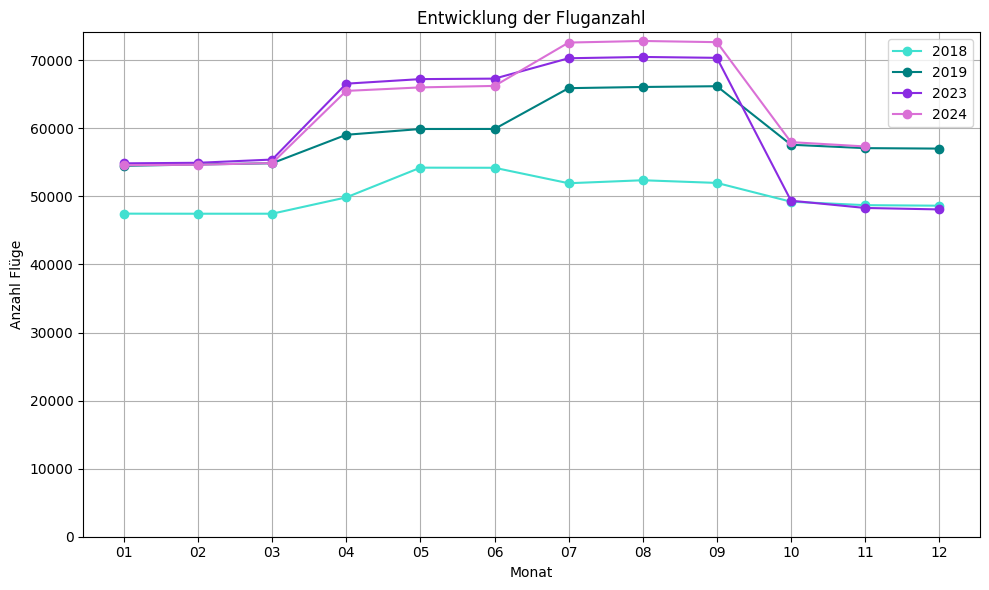

In [13]:
# Sort the data based on months
#sorted_data = sorted(zip(months_2018, ieflight_2018, ieflight_2019, ieflight_2023, ieflight_2024), key=lambda x: x[0])
#months_sorted, ieflight_2018_sorted, ieflight_2019_sorted, ieflight_2023_sorted, ieflight_2024_sorted = zip(*sorted_data)

# Create the plot for number of nodes
#fig = plt.figure(figsize=(10, 6))
#plt.plot(months_sorted, ieflight_2018_sorted, markerToUse, color='turquoise', label='2018')
#plt.plot(months_sorted, ieflight_2019_sorted, markerToUse, color='teal', label='2019')
#plt.plot(months_sorted, ieflight_2023_sorted, markerToUse, color='blueviolet', label='2023')
#plt.plot(months_sorted, ieflight_2024_sorted, markerToUse, color='orchid', label='2024')


fig = plt.figure(figsize=(10, 6))
plt.plot(months_2018, ieflight_2018, markerToUse, color='turquoise', label='2018')
plt.plot(months_2019, ieflight_2019, markerToUse, color='teal', label='2019')
plt.plot(months_2023, ieflight_2023, markerToUse, color='blueviolet', label='2023')
# ensure all lists have the same length
plt.plot(months_2024[:-1], ieflight_2024[:-1], markerToUse, color='orchid', label='2024')

plt.xlabel('Monat')
plt.ylabel('Anzahl Flüge')
plt.title('Entwicklung der Fluganzahl')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(bottom=0)

filetitle="ieflight"
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/{filetitle}_{countryname}_{timestamp}.png"
plt.savefig(resultfilename)
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/{filetitle}_{countryname}_{timestamp}.svg"
plt.savefig(resultfilename)

plt.show()


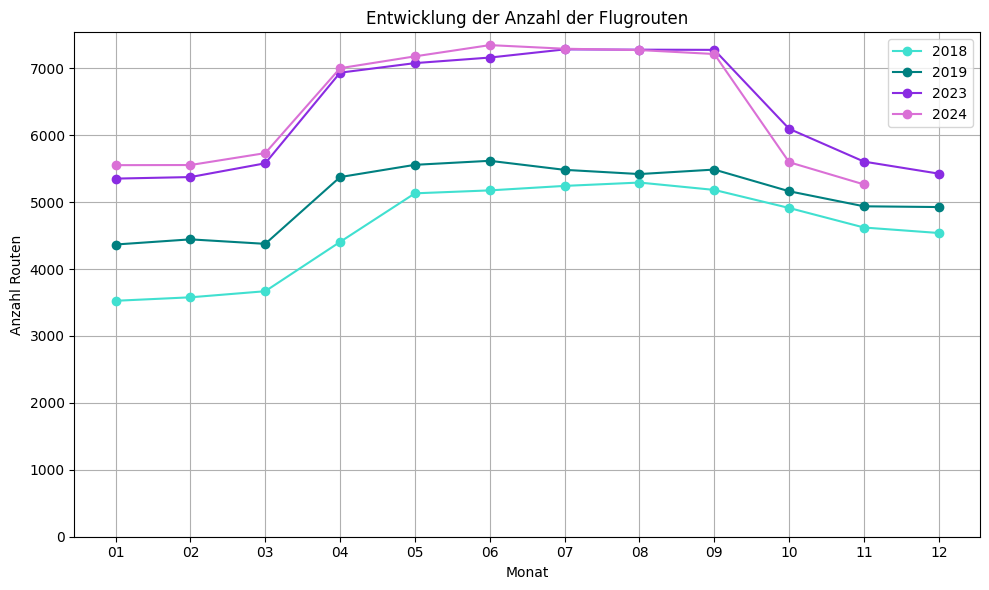

In [14]:
# # Create the plot for number of nodes

fig = plt.figure(figsize=(10, 6))
plt.plot(months_2018, neroute_2018, markerToUse, color='turquoise', label='2018')
plt.plot(months_2019, neroute_2019, markerToUse, color='teal', label='2019')
plt.plot(months_2023, neroute_2023, markerToUse, color='blueviolet', label='2023')
# don't plot the make-up point for 2024
plt.plot(months_2024[:-1], neroute_2024[:-1], markerToUse, color='orchid', label='2024')

plt.xlabel('Monat')
plt.ylabel('Anzahl Routen')
plt.title('Entwicklung der Anzahl der Flugrouten')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()

filetitle="neroute"
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/{filetitle}_{countryname}_{timestamp}.png"
plt.savefig(resultfilename)
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/{filetitle}_{countryname}_{timestamp}.svg"
plt.savefig(resultfilename)

plt.show()

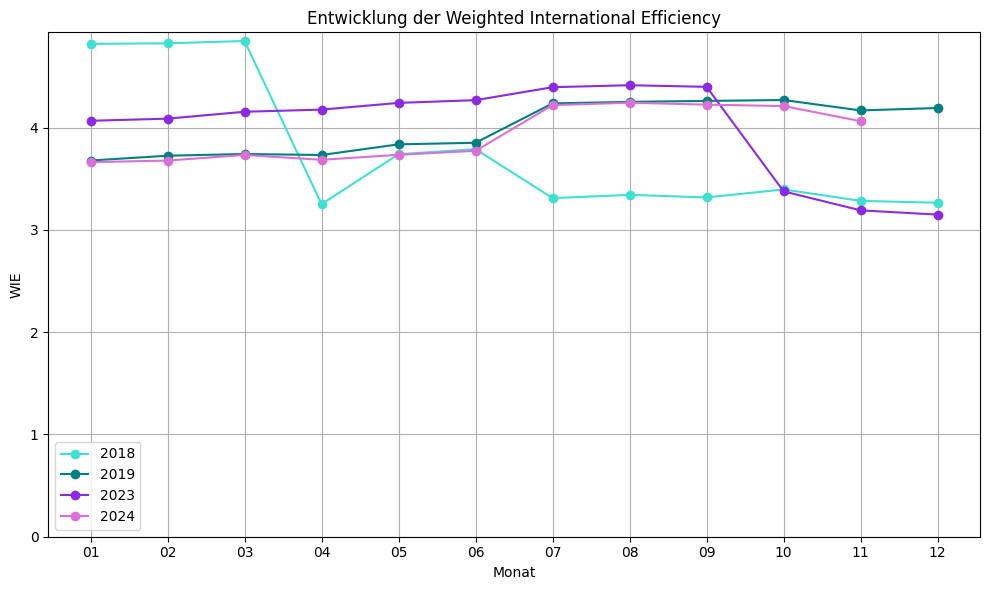

In [15]:
# # Create the plot for WIE
fig = plt.figure(figsize=(10, 6))
plt.plot(months_2018, wie_2018, markerToUse, color='turquoise', label='2018')
plt.plot(months_2019, wie_2019, markerToUse, color='teal', label='2019')
plt.plot(months_2023, wie_2023, markerToUse, color='blueviolet', label='2023')
# don't plot the make-up point for 2024
plt.plot(months_2024[:-1], wie_2024[:-1], markerToUse, color='orchid', label='2024')

plt.xlabel('Monat')
plt.ylabel('WIE')
plt.title('Entwicklung der Weighted International Efficiency')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()

filetitle="WIE"
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/{filetitle}_{countryname}_{timestamp}.png"
plt.savefig(resultfilename)
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/{filetitle}_{countryname}_{timestamp}.svg"
plt.savefig(resultfilename)

plt.show()

In [16]:
# # Create the plot for ir
fig = plt.figure(figsize=(10, 6))
plt.plot(months_2018, ir_2018, markerToUse, color='turquoise', label='2018')
plt.plot(months_2019, ir_2019, markerToUse, color='teal', label='2019')
plt.plot(months_2023, ir_2023, markerToUse, color='blueviolet', label='2023')
# don't plot the make-up point for 2024
plt.plot(months_2024[:-1], ir_2024[:-1], markerToUse, color='orchid', label='2024')

plt.xlabel('Monat')
plt.ylabel('IR')
plt.title('Entwicklung der International Robustness')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(bottom=0)
#plt.ylim(ymin=0)

filetitle="IR"
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/{filetitle}_{countryname}_{timestamp}.png"
plt.savefig(resultfilename)
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/{filetitle}_{countryname}_{timestamp}.svg"
plt.savefig(resultfilename)

plt.show()